# Contents
- [Imports](#Imports)
- [Parameters](#Parameters)
- [Scans](#Scans)
- [Plot_alpha](#Plot_alpha)
- [Plot_1Ds](#Plot_1Ds)
- [Debugging](#Debugging)
- [Convergence](#Convergence)

# Imports

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from arc import *
from time import time
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from typing import List, Dict
import gc

from basics import *
from utility import *
from floquet_hamiltonian import *


pi=np.pi
tau=2*pi

# Parameters
## Computational Parameters

In [60]:
# Initialize to None when computational paramters are changed. Lets downstream program know when to re-build basis
basis = None
levels = None
basis_n = None

energies = None
eigenstates = None

# Computational Parameters
scheme = ["red", "mid", "low"][1]

if scheme == "low":
    t_level = RydStateFS(52,1,1/2)
else:
    t_level = RydStateFS(52,1,3/2)
    
max_det = tau*40e9  # radians/s
dl = 2
n_max = 2
single_side = False  # True currently breaks code. Issue in utility.level_starts() function.

comp = {
    "max_det": max_det,
    "dl": dl,
    "n_max": n_max
}

zeeman_offset = 1e4 if scheme == "red" else 1e2

results_dir = r"Shirley-Floquet_results\PolarizabilityPlots\RawData"
plots_dir =  r"Shirley-Floquet_results\PolarizabilityPlots"

## Physical Parameters

In [3]:
# Physical Parameters
Edc = 0 # V/m
if scheme == "red":
    zerox = {1: 78.6, 2: 82.6, 3: 85.6, 4: 89.6}
    Eac = 89.6 # 19.5  # V/m
    ellipticity = 0.0120
else:
    ellipticity = 0
    if scheme == "mid":
        zero_x = [27.616, 31.346, 59.416]
        Eac = 40.0  # zerox here
        Eac = 28.0
    elif scheme == "low":
        Eac = 30  # zerox here
energy_bands = ellipticity > 1e-3  # TODO, choose a nice threshold for this

if scheme == "red":
    field_omega = tau*4.780e9  #radians/s
elif scheme == "mid":
    field_omega = tau*5.095e9  #radians/s # Mid Detuning
elif scheme == "low":
    # resonance at 6720.5MHz
    field_omega = tau*6.62e9  #radians/s # 52P1/2

theta = 0.0*pi/2  # angle between quantization axis and electric field (radians)

Eac_list = None
Edc_list = None
ellip_list = None
theta_list = None

fields = {
    "Eac": Eac,
    "ellipticity": ellipticity,
    "field_omega": field_omega,
    "Edc": Edc,
    "theta": theta
}

#Edc_list = np.linspace(0,15,100)  # V/m
Eac_list = np.linspace(0,90,300)  # V/m
#ellip_list = np.linspace(0,np.sqrt(0.07),100)**2
#theta_list = np.linspace(0,pi,100)

if Edc_list is not None:
    varied = ("Edc", Edc_list)
elif Eac_list is not None:
    varied = ("Eac", Eac_list)
elif ellip_list is not None:
    varied = ("ellipticity", ellip_list)
elif theta_list is not None:
    varied = ("theta", theta_list)
    
dataset=60
if dataset == 60:
# measured resonance between nP3/2 -> (n-1)D3/2 levels
    p3o2_d3o2_res = 4839*1e6*tau
# for 685nm at +80MHz wrt 4-6' transition. Generator at 191.25MHz
elif dataset == 80:
    p3o2_d3o2_res = 4840*1e6*tau
# effective laser induced AC stark shift
laser_dAC = detuning(RydStateFS(51,2,3/2), t_level, p3o2_d3o2_res)

# Build Basis Lists (Define Hilbert Space)

In [4]:
try:
    energies = None
    eigenstates = None
except NameError:
    pass
if basis is None or levels is None:
    levels, basis = build_basis(t_level,max_det,single_side=single_side, dl=dl)
    t_inds = [ind for ind, state in enumerate(basis) if [state.n, state.l, state.j] == [t_level.n, t_level.l, t_level.j]]
    t_states = [basis[i] for i in t_inds]
if basis_n is None:
    basis_n = build_n_basis(basis, n_max)
print(len(basis),len(basis_n))
basis_print(levels)
basis_print(basis_n)

48 240
[
	|52,S,1/2>,
	|48,F,5/2>,
	|48,F,7/2>,
	|52,P,1/2>,
	|52,P,3/2>,
	|51,D,3/2>,
	|51,D,5/2>,
	|53,S,1/2>,
	|49,F,5/2>,
	|49,F,7/2>
]
[
	|52,S,1/2;mj:-1/2,nphot:-2>,
	|52,S,1/2;mj:1/2,nphot:-2>,
	|48,F,5/2;mj:-5/2,nphot:-2>,
	|48,F,5/2;mj:-3/2,nphot:-2>,
	|48,F,5/2;mj:-1/2,nphot:-2>,
	|48,F,5/2;mj:1/2,nphot:-2>,
	|48,F,5/2;mj:3/2,nphot:-2>,
	|48,F,5/2;mj:5/2,nphot:-2>,
	|48,F,7/2;mj:-7/2,nphot:-2>,
	|48,F,7/2;mj:-5/2,nphot:-2>,
	|48,F,7/2;mj:-3/2,nphot:-2>,
	|48,F,7/2;mj:-1/2,nphot:-2>,
	|48,F,7/2;mj:1/2,nphot:-2>,
	|48,F,7/2;mj:3/2,nphot:-2>,
	|48,F,7/2;mj:5/2,nphot:-2>,
	|48,F,7/2;mj:7/2,nphot:-2>,
	|52,P,1/2;mj:-1/2,nphot:-2>,
	|52,P,1/2;mj:1/2,nphot:-2>,
	|52,P,3/2;mj:-3/2,nphot:-2>,
	|52,P,3/2;mj:-1/2,nphot:-2>,
	|52,P,3/2;mj:1/2,nphot:-2>,
	|52,P,3/2;mj:3/2,nphot:-2>,
	|51,D,3/2;mj:-3/2,nphot:-2>,
	|51,D,3/2;mj:-1/2,nphot:-2>,
	|51,D,3/2;mj:1/2,nphot:-2>,
	|51,D,3/2;mj:3/2,nphot:-2>,
	|51,D,5/2;mj:-5/2,nphot:-2>,
	|51,D,5/2;mj:-3/2,nphot:-2>,
	|51,D,5/2;mj:-1/2,nphot:-2>,
	

# Scans
## Scan Parameter specified in physical parameters

In [7]:
try:
    energies = None
    eigenstates = None
except NameError:
    pass
if basis is None or levels is None:
    levels, basis = build_basis(t_level,max_det,single_side=False, dl=dl)
    t_inds = [ind for ind, state in enumerate(basis) if [state.n, state.l, state.j] == [t_level.n, t_level.l, t_level.j]]
    t_states = [basis[i] for i in t_inds]
if basis_n is None:
    basis_n = build_n_basis(basis, n_max)


fields_p = {key: value for key, value in fields.items()}
fields_p[varied[0]] = varied[1]

#old_scans = eigen_find(t_level,comp, fields_p)
#loading = False
# TODO : this is broken rn. Implement eigen_terpolate then fix this.
#if loading and len(old_scans) > 0: 
#    energies = np.load(old_scans[0][0].format("energies"))
#    eigenstates = np.load(old_scans[0][0].format("eigenstates"))
#else:
zeeman_offset=1e2
H0 = build_H0(basis, t_level, offset_zeeman=zeeman_offset)
if scheme == "red":
    H0[t_inds,t_inds] += laser_dAC
f_inds = [(ind,state.j) for ind, state in enumerate(basis) if state.l == 3]
f_jsplit = 1e6
jsplit = False
if jsplit:
    for ind, j in f_inds:
        H0[ind,ind] += f_jsplit*j
    
energies, eigenstates, error = floquet_loop(
    basis,
    H0,
    n_max=n_max,
    varied=varied,
    energy_bands=energy_bands,
    **fields
)

#f_name = f"convergenceTest-nmax={n_max}-dw={max_det}-dl={dl}-{{}}"
#filepath = "Shirley-Floquet_results\\convergence_tests"
#np.save(os.path.join(filepath,f_name.format("energies")), energies)
#np.save(os.path.join(filepath,f_name.format("eigenstates")), eigenstates)
#eigen_save(t_level, comp, fields_p, energies, eigenstates)

240
Levels :

[
	|52,S,1/2>,
	|48,F,5/2>,
	|48,F,7/2>,
	|52,P,1/2>,
	|52,P,3/2>,
	|51,D,3/2>,
	|51,D,5/2>,
	|53,S,1/2>,
	|49,F,5/2>,
	|49,F,7/2>
]
little_d built in 0.008649587631225586
Hdc built in 0.0020189285278320312
Hfloquet put together in 0.0005030632019042969
Floquet matrix built after 0.012477874755859375 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 0.0, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.01186060905456543s
Normalization Complete after 0.004251241683959961 s
floquet_diag call completed in 0.028589725494384766s
Diagonalization complete for independent variable entry, value 0, 0.0
little_d built in 0.007000446319580078
Hdc built in 0.0010025501251220703
Hfloquet put together in 0.0009975433349609375
Floquet matrix built after 0.009000539779663086 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 0.3010033444816054, ellipticity 0, fiel

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 3.91304347826087, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19306588172912598s
Normalization Complete after 0.0035979747772216797 s
floquet_diag call completed in 0.20624876022338867s
Diagonalization complete for independent variable entry, value 13, 3.91304347826087
re-arrangement done after time 0.003995656967163086s
little_d built in 0.007055759429931641
Hdc built in 0.0010051727294921875
Hfloquet put together in 0.0
Floquet matrix built after 0.009059906005859375 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 4.214046822742475, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19176602363586426s
Normalization Complete after 0.002472400665283203 s
floquet_diag call completed in 0.20430684089660645s
Diagonalization complete for independent variable entry, value 14, 4.2

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 8.127090301003346, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19607305526733398s
Normalization Complete after 0.0040056705474853516 s
floquet_diag call completed in 0.2095940113067627s
Diagonalization complete for independent variable entry, value 27, 8.127090301003346
re-arrangement done after time 0.0054759979248046875s
little_d built in 0.008011817932128906
Hdc built in 0.0010001659393310547
Hfloquet put together in 0.0
Floquet matrix built after 0.009011983871459961 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 8.42809364548495, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19136977195739746s
Normalization Complete after 0.0035114288330078125 s
floquet_diag call completed in 0.20389318466186523s
Diagonalization complete for independent variable entry, value 28, 8

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 12.34113712374582, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.1951920986175537s
Normalization Complete after 0.002010345458984375 s
floquet_diag call completed in 0.20621323585510254s
Diagonalization complete for independent variable entry, value 41, 12.34113712374582
re-arrangement done after time 0.006018638610839844s
little_d built in 0.007998228073120117
Hdc built in 0.0
Hfloquet put together in 0.0012919902801513672
Floquet matrix built after 0.009794473648071289 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 12.642140468227426, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19417238235473633s
Normalization Complete after 0.003048419952392578 s
floquet_diag call completed in 0.20801496505737305s
Diagonalization complete for independent variable entry, value 42, 12

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 16.555183946488295, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19170308113098145s
Normalization Complete after 0.0030431747436523438 s
floquet_diag call completed in 0.20555710792541504s
Diagonalization complete for independent variable entry, value 55, 16.555183946488295
re-arrangement done after time 0.005104541778564453s
little_d built in 0.008999347686767578
Hdc built in 0.0010008811950683594
Hfloquet put together in 0.0
Floquet matrix built after 0.010000228881835938 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 16.8561872909699, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.18896055221557617s
Normalization Complete after 0.004007101058959961 s
floquet_diag call completed in 0.20438408851623535s
Diagonalization complete for independent variable entry, value 56, 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 20.76923076923077, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.18798279762268066s
Normalization Complete after 0.00400090217590332 s
floquet_diag call completed in 0.2009906768798828s
Diagonalization complete for independent variable entry, value 69, 20.76923076923077
re-arrangement done after time 0.005022525787353516s
little_d built in 0.008999824523925781
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.010006904602050781 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 21.070234113712377, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.20850586891174316s
Normalization Complete after 0.0030057430267333984 s
floquet_diag call completed in 0.2225184440612793s
Diagonalization complete for independent variable entry, value 70, 21.070234113712377
re

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 24.983277591973245, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.18637824058532715s
Normalization Complete after 0.0040323734283447266 s
floquet_diag call completed in 0.2004103660583496s
Diagonalization complete for independent variable entry, value 83, 24.983277591973245
re-arrangement done after time 0.006430149078369141s
little_d built in 0.008259296417236328
Hdc built in 0.0009999275207519531
Hfloquet put together in 0.0
Floquet matrix built after 0.009259223937988281 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 25.284280936454852, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.1942446231842041s
Normalization Complete after 0.0030972957611083984 s
floquet_diag call completed in 0.20768427848815918s
Diagonalization complete for independent variable entry, value 84,

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 29.19732441471572, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19460797309875488s
Normalization Complete after 0.004065752029418945 s
floquet_diag call completed in 0.20867443084716797s
Diagonalization complete for independent variable entry, value 97, 29.19732441471572
re-arrangement done after time 0.005001068115234375s
little_d built in 0.007995367050170898
Hdc built in 0.0010001659393310547
Hfloquet put together in 0.0
Floquet matrix built after 0.008995532989501953 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 29.498327759197327, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.20387530326843262s
Normalization Complete after 0.0030007362365722656 s
floquet_diag call completed in 0.21587157249450684s
Diagonalization complete for independent variable entry, value 98, 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 33.4113712374582, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19374847412109375s
Normalization Complete after 0.0010073184967041016 s
floquet_diag call completed in 0.20525717735290527s
Diagonalization complete for independent variable entry, value 111, 33.4113712374582
re-arrangement done after time 0.004001140594482422s
little_d built in 0.007999181747436523
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.009138107299804688 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 33.7123745819398, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.20091962814331055s
Normalization Complete after 0.0009999275207519531 s
floquet_diag call completed in 0.2110576629638672s
Diagonalization complete for independent variable entry, value 112, 33.7123745819398
re-

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 37.62541806020067, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19664955139160156s
Normalization Complete after 0.004510164260864258 s
floquet_diag call completed in 0.2097623348236084s
Diagonalization complete for independent variable entry, value 125, 37.62541806020067
re-arrangement done after time 0.006006002426147461s
little_d built in 0.00800013542175293
Hdc built in 0.0009999275207519531
Hfloquet put together in 0.0009999275207519531
Floquet matrix built after 0.009999990463256836 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 37.92642140468228, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19930481910705566s
Normalization Complete after 0.0023298263549804688 s
floquet_diag call completed in 0.21163463592529297s
Diagonalization complete for independent variable e

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 41.83946488294315, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.1966114044189453s
Normalization Complete after 0.0030059814453125 s
floquet_diag call completed in 0.2100358009338379s
Diagonalization complete for independent variable entry, value 139, 41.83946488294315
re-arrangement done after time 0.004390239715576172s
little_d built in 0.008697032928466797
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.010002851486206055 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 42.140468227424755, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.18914437294006348s
Normalization Complete after 0.004007101058959961 s
floquet_diag call completed in 0.2031543254852295s
Diagonalization complete for independent variable entry, value 140, 42.140468227424755
re-

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.05351170568562, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.20421433448791504s
Normalization Complete after 0.0042724609375 s
floquet_diag call completed in 0.21811342239379883s
Diagonalization complete for independent variable entry, value 153, 46.05351170568562
re-arrangement done after time 0.005091428756713867s
little_d built in 0.008313179016113281
Hdc built in 0.0010004043579101562
Hfloquet put together in 0.0
Floquet matrix built after 0.009313583374023438 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.35451505016723, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.20162034034729004s
Normalization Complete after 0.0030517578125 s
floquet_diag call completed in 0.21398568153381348s
Diagonalization complete for independent variable entry, value 154, 46.3545150

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 50.2675585284281, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19704890251159668s
Normalization Complete after 0.003170013427734375 s
floquet_diag call completed in 0.21024441719055176s
Diagonalization complete for independent variable entry, value 167, 50.2675585284281
re-arrangement done after time 0.004791736602783203s
little_d built in 0.008238792419433594
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.009238481521606445 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 50.568561872909704, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19390439987182617s
Normalization Complete after 0.004102230072021484 s
floquet_diag call completed in 0.2072451114654541s
Diagonalization complete for independent variable entry, value 168, 50.568561872909704
r

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 54.48160535117057, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19723129272460938s
Normalization Complete after 0.0019989013671875 s
floquet_diag call completed in 0.20894074440002441s
Diagonalization complete for independent variable entry, value 181, 54.48160535117057
re-arrangement done after time 0.0045013427734375s
little_d built in 0.007996797561645508
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.009997844696044922 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 54.78260869565218, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.1956033706665039s
Normalization Complete after 0.00417327880859375 s
floquet_diag call completed in 0.20977449417114258s
Diagonalization complete for independent variable entry, value 182, 54.78260869565218
re-arr

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 58.69565217391305, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.20457768440246582s
Normalization Complete after 0.0030050277709960938 s
floquet_diag call completed in 0.2185826301574707s
Diagonalization complete for independent variable entry, value 195, 58.69565217391305
re-arrangement done after time 0.003999471664428711s
little_d built in 0.008203983306884766
Hdc built in 0.0009999275207519531
Hfloquet put together in 0.0009996891021728516
Floquet matrix built after 0.01020359992980957 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 58.996655518394654, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.1947004795074463s
Normalization Complete after 0.003020048141479492 s
floquet_diag call completed in 0.20792412757873535s
Diagonalization complete for independent variable e

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 62.90969899665552, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.1998133659362793s
Normalization Complete after 0.0021028518676757812 s
floquet_diag call completed in 0.21228575706481934s
Diagonalization complete for independent variable entry, value 209, 62.90969899665552
re-arrangement done after time 0.0035047531127929688s
little_d built in 0.008009195327758789
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.009265899658203125 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 63.21070234113713, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.2051241397857666s
Normalization Complete after 0.0030074119567871094 s
floquet_diag call completed in 0.21839666366577148s
Diagonalization complete for independent variable entry, value 210, 63.21070234113713

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 67.123745819398, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19651508331298828s
Normalization Complete after 0.005151510238647461 s
floquet_diag call completed in 0.2111072540283203s
Diagonalization complete for independent variable entry, value 223, 67.123745819398
re-arrangement done after time 0.0039937496185302734s
little_d built in 0.007999181747436523
Hdc built in 0.0010004043579101562
Hfloquet put together in 0.0
Floquet matrix built after 0.00899958610534668 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 67.4247491638796, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.2000713348388672s
Normalization Complete after 0.004007816314697266 s
floquet_diag call completed in 0.21407842636108398s
Diagonalization complete for independent variable entry, value 224, 67.4247

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 71.33779264214047, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19669818878173828s
Normalization Complete after 0.0010097026824951172 s
floquet_diag call completed in 0.20812582969665527s
Diagonalization complete for independent variable entry, value 237, 71.33779264214047
re-arrangement done after time 0.004038333892822266s
little_d built in 0.008107662200927734
Hdc built in 0.0010006427764892578
Hfloquet put together in 0.0
Floquet matrix built after 0.009108304977416992 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 71.63879598662209, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19931936264038086s
Normalization Complete after 0.004000425338745117 s
floquet_diag call completed in 0.21342873573303223s
Diagonalization complete for independent variable entry, value 238,

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 75.55183946488295, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19634246826171875s
Normalization Complete after 0.003023862838745117 s
floquet_diag call completed in 0.20937180519104004s
Diagonalization complete for independent variable entry, value 251, 75.55183946488295
re-arrangement done after time 0.004000186920166016s
little_d built in 0.007999897003173828
Hdc built in 0.0
Hfloquet put together in 0.0012700557708740234
Floquet matrix built after 0.010272979736328125 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 75.85284280936456, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.20178890228271484s
Normalization Complete after 0.004362821578979492 s
floquet_diag call completed in 0.21642470359802246s
Diagonalization complete for independent variable entry, value 252, 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 79.76588628762542, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.2035236358642578s
Normalization Complete after 0.0019996166229248047 s
floquet_diag call completed in 0.21584534645080566s
Diagonalization complete for independent variable entry, value 265, 79.76588628762542
re-arrangement done after time 0.003999948501586914s
little_d built in 0.007999420166015625
Hdc built in 0.0010004043579101562
Hfloquet put together in 0.0
Floquet matrix built after 0.010350942611694336 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 80.06688963210703, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.19874000549316406s
Normalization Complete after 0.005001068115234375 s
floquet_diag call completed in 0.21409201622009277s
Diagonalization complete for independent variable entry, value 266, 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 83.9799331103679, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.20506525039672852s
Normalization Complete after 0.0020079612731933594 s
floquet_diag call completed in 0.2188584804534912s
Diagonalization complete for independent variable entry, value 279, 83.9799331103679
re-arrangement done after time 0.00400853157043457s
little_d built in 0.007965326309204102
Hdc built in 0.0010051727294921875
Hfloquet put together in 0.0
Floquet matrix built after 0.008970499038696289 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 84.28093645484951, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.20692825317382812s
Normalization Complete after 0.004006385803222656 s
floquet_diag call completed in 0.22096896171569824s
Diagonalization complete for independent variable entry, value 280, 84.

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 88.19397993311037, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.1981213092803955s
Normalization Complete after 0.004205226898193359 s
floquet_diag call completed in 0.21074724197387695s
Diagonalization complete for independent variable entry, value 293, 88.19397993311037
re-arrangement done after time 0.005080223083496094s
little_d built in 0.008640766143798828
Hdc built in 0.0
Hfloquet put together in 0.0010004043579101562
Floquet matrix built after 0.009641170501708984 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 88.49498327759198, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0, theta 0.0
Diagonalized after time: 0.20159602165222168s
Normalization Complete after 0.0030090808868408203 s
floquet_diag call completed in 0.21524930000305176s
Diagonalization complete for independent variable entry, value 294, 

# Scan $E_{AC}$ or $\theta$ and check 2nd + 4th order DC polarizability 

In [9]:
def check_polarizability(
    basis: List[RydStateFS], 
    H0: np.ndarray,
    dc_end: float, 
    samples: int,
    comp: Dict[str, int],
    fields: Dict[str, float],
    energy_bands: bool=False
) -> np.ndarray:
    """
    Determines the polarizability of all states in basis for AC/DC field parameters
    provided in fields dict.
    
    Args:
        basis: list of atomic states considered in computation
        H0: Hamiltonian of unperturbed atom system (expected to be diagonal). Matrix
            elements should be reported in radial frequency (radians/s)
        dc_end: maximum electric field strength to be sampled. dc electric field values
            are sampled from 0 to dc_end
        samples: number of dc electric field strength values to take. System is prone to crashing when
            too few samples are provided. Stable for when 100 samples per 20 volt span
        fields: dict of AC and DC field values. Currently the following parameters are expected
            to be represented in fields:
                "Eac" : Electric field strength of the AC field (V/m)
                "ellipticity" : ellipticity of the AC field. Field polarization defined as
                    e_ac = sqrt(1-ellipticity)e_pi + sqrt(ellipticity)e_+
                "field_omega" : oscillation frequency of the AC. Reported in radial frequency (radians/s)
                "Edc" : Ignored if included in fields dict
                "theta" : angle between quantization axis and electric field direction (radians)
        comp: dict of computational parameters used for this computation. Keys:
            "max_det" : float, maximum energy difference between t_level and any level included
                in the basis used in the computation
            "dl" : int, maximum difference between t_level.l and the orbital angular momentum
                quantum number of other states in the basis, |l-lp| <= dl
            "n_max" : int, maximum number of fourier components of the AC field to include in the
                computation
    Returns:
        popts: list of fit parameters. popts.shape = (len(basis)*(2*n_max+1), len(fit_args))
            when fits == True:
                fit_args = v0, alpha, e0, beta. Parameters for a 4th order fit to the numeric data
                func = e0+alpha*(v-v0)**2+beta*(v-v0)**4
        
    """
    dcs = ("Edc", np.linspace(0,dc_end,samples))
    energies, eigenstates, error = floquet_loop(basis, H0, n_max=comp["n_max"], varied = dcs, energy_bands=energy_bands, **fields)
    
    if error is not None:
        return None, None, error
    quad = lambda v, v0, alpha, e0, beta: e0-1/2*alpha*(v-v0)**2+1/factorial(4)*beta*(v-v0)**4
    guess = [0,0,0,0]
    
    fits = True
    
    dim = len(basis)*(2*n_max+1)
    popts = np.zeros((dim, len(guess)), dtype=float)
    perrs = np.zeros(popts.shape, dtype=float)

    for i in range(dim):
        band_energies = energies[i,:]
        guess = guess = [0.0, (band_energies[-1]-band_energies[0])/dc_end**2, band_energies[samples//2],0]
        if fits:
            try:
                popt, pcov = curve_fit(quad, dcs[1], band_energies, p0 = guess)
                perr = np.sqrt(np.diag(pcov))

                popts[i] = popt
                perrs[i] = perr
            except RuntimeError:
                print("WARNING: Error fitting polarizability data")
                popts[i] = np.NaN
                perrs[i] = np.NaN    
        else:
            dmax_abs = max(abs(band_energies-band_energies[0]))
            dmax_ind = np.argwhere(abs(band_energies-band_energies[0])==dmax_abs)[0,0]
            print(dmax_abs,dmax_ind)
            dmax = (band_energies-band_energies[0])[dmax_ind]
            e_max = dcs[1][dmax_ind]
            popts[i,2] = dmax/e_max**2
            perrs[i,2] = np.NaN
            
    fields["Edc"] = dcs[1]
    eigen_save(t_level, comp, fields, energies, eigenstates)
    es0 = eigenstates[...,0]
    del energies
    del eigenstates
    return popts, perrs, es0

try:
    del energies
    del eigenstates
except NameError:
    pass

# build basis if not already built
if basis is None or levels is None:
    levels, basis = build_basis(t_level,max_det,single_side=False, dl=dl)
    t_inds = [ind for ind, state in enumerate(basis) if [state.n, state.l, state.j] == [t_level.n, t_level.l, t_level.j]]
if basis_n is None:
    basis_n = build_n_basis(basis, n_max)

fields_p = {key: value for key, value in fields.items()}
fields_p[varied[0]] = varied[1]


H0 = build_H0(basis,t_level, offset_zeeman=zeeman_offset)
if scheme == "red":
    H0[t_inds,t_inds] += laser_dAC
f_inds = [(ind,state.j) for ind, state in enumerate(basis) if state.l == 2]
f_jsplit = 0

samples = 100
Emax = 15
# set Eac to 2nd order zero-crossing when theta is scanned
if scheme == "red":
    zerox = {1: 78.6, 2: 82.6, 3: 85.6, 4: 89.6}
    Eac=zerox[4] 
elif scheme == "mid":
    Eac = zero_x[2]
elif scheme == "low":
    zerox = 46.831
    Eac=zerox

    
# Eac and theta values to sample
Eacs = np.linspace(0,70,41)  # V/m
thetas = np.linspace(-pi/2,pi/2,21)  # radians

sweep_ac = False  # scan Eac Values
sweep_theta = True  # scan theta values

if sweep_ac:
    alphas = np.zeros((len(Eacs),len(basis)*(2*n_max+1)),dtype=float)
    dalphas = np.zeros(alphas.shape,dtype=float)
    popts = np.zeros((len(Eacs),len(basis)*(2*n_max+1),4),dtype=float)
    perrs = np.zeros(popts.shape,dtype=float)
    es0s = np.zeros((len(Eacs),len(basis_n),len(basis_n)),dtype=float)
    # failed = False

    for i, eac in enumerate(Eacs):
        fields["theta"] = theta
        fields["Eac"] = eac
        try:
            popts[i], perrs[i], es0s[i] = check_polarizability(basis, H0, Emax, samples, comp, fields, energy_bands)
        except ValueError:
            print(f"WARNING: failed to check polarizability for field values :\n{fields}")
        # If one point fails try again on the next point. If two in a row fail, raise the error
            popts[i] = np.NaN
            perrs[i] = np.NaN
            es0s[i] = np.NaN

    alphas = popts[...,1]
    dalphas = perrs[...,1]
    popts_eac = popts
    perrs_eac = perrs
    es0s_eac = es0s

if sweep_theta:
    alphas = np.zeros((len(thetas),len(basis)*(2*n_max+1)),dtype=float)
    dalphas = np.zeros(alphas.shape,dtype=float)
    popts = np.zeros((len(thetas),len(basis)*(2*n_max+1),4),dtype=float)
    perrs = np.zeros(popts.shape,dtype=float)
    es0s = np.zeros((len(Eacs),len(basis_n),len(basis_n)),dtype=float)
    # failed = False

    for i, th in enumerate(thetas):
        fields["Eac"] = Eac
        fields["theta"] = th
        try:
            popt, perr, err = check_polarizability(basis, H0, Emax, samples, comp, fields, energy_bands)
            if type(err) is dict:
                popts[i] = np.NaN
                perrs[i] = np.NaN
                es0s[i] = np.NaN
                print(f"WARNING: failed to check polarizability for field values :\n{fields}\n Likely effor in Floquet Loop organization")
            else:
                popts[i], perrs[i], es0s[i] = popt, perr, err
        except ValueError as e:
            print(f"WARNING: failed to check polarizability for field values :\n{fields}\n{e}")
        # If one point fails try again on the next point. If two in a row fail, raise the error
            popts[i] = np.NaN
            perrs[i] = np.NaN
            es0s[i] = np.NaN

    popts_theta2 = popts
    perrs_theta2 = perrs
    es0s_theta2 = es0s

nan_inds = np.argwhere(np.isnan(popts))
err_eacinds = list({ind for ind in nan_inds[:,0]})
err_eacs = [Eacs[ind] for ind in err_eacinds]
print(err_eacs)

240
Levels :

[
	|52,S,1/2>,
	|48,F,5/2>,
	|48,F,7/2>,
	|52,P,1/2>,
	|52,P,3/2>,
	|51,D,3/2>,
	|51,D,5/2>,
	|53,S,1/2>,
	|49,F,5/2>,
	|49,F,7/2>
]
little_d built in 0.007997989654541016
Hdc built in 0.0
Hfloquet put together in 0.0010113716125488281
Floquet matrix built after 0.010328292846679688 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0.0, theta -1.5707963267948966
Diagonalized after time: 0.19381451606750488s
Normalization Complete after 0.0033044815063476562 s
floquet_diag call completed in 0.20744729042053223s
Diagonalization complete for independent variable entry, value 0, 0.0
rearranging missing indices
[ 90 100 124 125 147 148 167 210]
[ 66  69 114 117 162 165 210 213]
missing ind 90
	 sub_ips = [[22.         27.         66.        ]
 [ 0.32934799  0.18953329  0.47938954]]
	 maxind = [1 0 2]
	 labind = 66
missing ind 100
	 sub_ips = [[25.         30.         69.

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 1.6666666666666667, theta -1.5707963267948966
Diagonalized after time: 0.2159733772277832s
Normalization Complete after 0.0009996891021728516 s
floquet_diag call completed in 0.22758269309997559s
Diagonalization complete for independent variable entry, value 11, 1.6666666666666667
re-arrangement done after time 0.00405430793762207s
little_d built in 0.008476734161376953
Hdc built in 0.0010001659393310547
Hfloquet put together in 0.0012085437774658203
Floquet matrix built after 0.010685443878173828 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 1.8181818181818183, theta -1.5707963267948966
Diagonalized after time: 0.21539950370788574s
Normalization Complete after 0.0010013580322265625 s
floquet_diag call completed in 0.22808480262756348s
Diagon

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 3.6363636363636367, theta -1.5707963267948966
Diagonalized after time: 0.209716796875s
Normalization Complete after 0.004517316818237305 s
floquet_diag call completed in 0.22423577308654785s
Diagonalization complete for independent variable entry, value 24, 3.6363636363636367
re-arrangement done after time 0.004044532775878906s
little_d built in 0.007999181747436523
Hdc built in 0.0009999275207519531
Hfloquet put together in 0.0
Floquet matrix built after 0.008999109268188477 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 3.787878787878788, theta -1.5707963267948966
Diagonalized after time: 0.2140820026397705s
Normalization Complete after 0.003213167190551758 s
floquet_diag call completed in 0.22915148735046387s
Diagonalization complete for in

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 5.606060606060606, theta -1.5707963267948966
Diagonalized after time: 0.21210360527038574s
Normalization Complete after 0.0022242069244384766 s
floquet_diag call completed in 0.22473645210266113s
Diagonalization complete for independent variable entry, value 37, 5.606060606060606
re-arrangement done after time 0.004325389862060547s
little_d built in 0.008997917175292969
Hdc built in 0.0
Hfloquet put together in 0.0014781951904296875
Floquet matrix built after 0.010476112365722656 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 5.757575757575758, theta -1.5707963267948966
Diagonalized after time: 0.20964765548706055s
Normalization Complete after 0.0030045509338378906 s
floquet_diag call completed in 0.22412824630737305s
Diagonalization complete 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 7.575757575757576, theta -1.5707963267948966
Diagonalized after time: 0.21404767036437988s
Normalization Complete after 0.002007007598876953 s
floquet_diag call completed in 0.22607874870300293s
Diagonalization complete for independent variable entry, value 50, 7.575757575757576
re-arrangement done after time 0.004000425338745117s
little_d built in 0.009001731872558594
Hdc built in 0.000997781753540039
Hfloquet put together in 0.0010619163513183594
Floquet matrix built after 0.011061429977416992 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 7.7272727272727275, theta -1.5707963267948966
Diagonalized after time: 0.2144315242767334s
Normalization Complete after 0.004136800765991211 s
floquet_diag call completed in 0.2296297550201416s
Diagonaliza

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 9.545454545454545, theta -1.5707963267948966
Diagonalized after time: 0.20972919464111328s
Normalization Complete after 0.002017498016357422 s
floquet_diag call completed in 0.2227461338043213s
Diagonalization complete for independent variable entry, value 63, 9.545454545454545
re-arrangement done after time 0.005000591278076172s
little_d built in 0.00860285758972168
Hdc built in 0.0010008811950683594
Hfloquet put together in 0.0
Floquet matrix built after 0.009603738784790039 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 9.696969696969697, theta -1.5707963267948966
Diagonalized after time: 0.21435070037841797s
Normalization Complete after 0.0020873546600341797 s
floquet_diag call completed in 0.2260417938232422s
Diagonalization complete for 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 11.515151515151516, theta -1.5707963267948966
Diagonalized after time: 0.2191481590270996s
Normalization Complete after 0.002005338668823242 s
floquet_diag call completed in 0.2313222885131836s
Diagonalization complete for independent variable entry, value 76, 11.515151515151516
re-arrangement done after time 0.003998994827270508s
little_d built in 0.00900125503540039
Hdc built in 0.0009999275207519531
Hfloquet put together in 0.0
Floquet matrix built after 0.010001182556152344 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 11.666666666666668, theta -1.5707963267948966
Diagonalized after time: 0.2151784896850586s
Normalization Complete after 0.0030012130737304688 s
floquet_diag call completed in 0.22917962074279785s
Diagonalization complete fo

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 13.484848484848484, theta -1.5707963267948966
Diagonalized after time: 0.2105240821838379s
Normalization Complete after 0.0020110607147216797 s
floquet_diag call completed in 0.2218313217163086s
Diagonalization complete for independent variable entry, value 89, 13.484848484848484
re-arrangement done after time 0.004000663757324219s
little_d built in 0.009007453918457031
Hdc built in 0.0009996891021728516
Hfloquet put together in 0.0
Floquet matrix built after 0.011007308959960938 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 13.636363636363637, theta -1.5707963267948966
Diagonalized after time: 0.21320700645446777s
Normalization Complete after 0.002008199691772461 s
floquet_diag call completed in 0.22622251510620117s
Diagonalization complete 

<ipython-input-9-864509a4b74c>:176: ComplexWarning: Casting complex values to real discards the imaginary part
  popts[i], perrs[i], es0s[i] = popt, perr, err


240
Levels :

[
	|52,S,1/2>,
	|48,F,5/2>,
	|48,F,7/2>,
	|52,P,1/2>,
	|52,P,3/2>,
	|51,D,3/2>,
	|51,D,5/2>,
	|53,S,1/2>,
	|49,F,5/2>,
	|49,F,7/2>
]
little_d built in 0.008064746856689453
Hdc built in 0.0
Hfloquet put together in 0.0013048648834228516
Floquet matrix built after 0.010376214981079102 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0.0, theta -1.413716694115407
Diagonalized after time: 0.20629596710205078s
Normalization Complete after 0.003161907196044922 s
floquet_diag call completed in 0.2198340892791748s
Diagonalization complete for independent variable entry, value 0, 0.0
rearranging missing indices
[ 90 100 124 125 147 148 167 210]
[ 66  69 114 117 162 165 210 213]
missing ind 90
	 sub_ips = [[22.         27.         66.        ]
 [ 0.32934799  0.18953329  0.47938954]]
	 maxind = [1 0 2]
	 labind = 66
missing ind 100
	 sub_ips = [[25.         30.         69.   

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 1.6666666666666667, theta -1.413716694115407
Diagonalized after time: 0.22086811065673828s
Normalization Complete after 0.003511190414428711 s
floquet_diag call completed in 0.23456835746765137s
Diagonalization complete for independent variable entry, value 11, 1.6666666666666667
re-arrangement done after time 0.004250764846801758s
little_d built in 0.008984088897705078
Hdc built in 0.0010001659393310547
Hfloquet put together in 0.0
Floquet matrix built after 0.011007070541381836 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 1.8181818181818183, theta -1.413716694115407
Diagonalized after time: 0.22276759147644043s
Normalization Complete after 0.0012426376342773438 s
floquet_diag call completed in 0.2360835075378418s
Diagonalization complete f

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 3.6363636363636367, theta -1.413716694115407
Diagonalized after time: 0.2602384090423584s
Normalization Complete after 0.004515886306762695 s
floquet_diag call completed in 0.27575206756591797s
Diagonalization complete for independent variable entry, value 24, 3.6363636363636367
re-arrangement done after time 0.0040569305419921875s
little_d built in 0.007813692092895508
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.00981450080871582 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 3.787878787878788, theta -1.413716694115407
Diagonalized after time: 0.23421764373779297s
Normalization Complete after 0.0013437271118164062 s
floquet_diag call completed in 0.2453758716583252s
Diagonalization complete for independent varia

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 5.606060606060606, theta -1.413716694115407
Diagonalized after time: 0.23804831504821777s
Normalization Complete after 0.00200653076171875 s
floquet_diag call completed in 0.25105762481689453s
Diagonalization complete for independent variable entry, value 37, 5.606060606060606
re-arrangement done after time 0.004174470901489258s
little_d built in 0.009638786315917969
Hdc built in 0.0009999275207519531
Hfloquet put together in 0.0009999275207519531
Floquet matrix built after 0.011638641357421875 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 5.757575757575758, theta -1.413716694115407
Diagonalized after time: 0.2332911491394043s
Normalization Complete after 0.0030045509338378906 s
floquet_diag call completed in 0.24893474578857422s
Diagonalizat

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 7.575757575757576, theta -1.413716694115407
Diagonalized after time: 0.2396101951599121s
Normalization Complete after 0.004526615142822266 s
floquet_diag call completed in 0.2546536922454834s
Diagonalization complete for independent variable entry, value 50, 7.575757575757576
re-arrangement done after time 0.0039980411529541016s
little_d built in 0.009519577026367188
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.010519742965698242 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 7.7272727272727275, theta -1.413716694115407
Diagonalized after time: 0.2326807975769043s
Normalization Complete after 0.0036101341247558594 s
floquet_diag call completed in 0.2468106746673584s
Diagonalization complete for independent variabl

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 9.545454545454545, theta -1.413716694115407
Diagonalized after time: 0.2333228588104248s
Normalization Complete after 0.0040130615234375 s
floquet_diag call completed in 0.24734115600585938s
Diagonalization complete for independent variable entry, value 63, 9.545454545454545
re-arrangement done after time 0.005561113357543945s
little_d built in 0.008656024932861328
Hdc built in 0.0
Hfloquet put together in 0.0013515949249267578
Floquet matrix built after 0.011011123657226562 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 9.696969696969697, theta -1.413716694115407
Diagonalized after time: 0.23010754585266113s
Normalization Complete after 0.004510402679443359 s
floquet_diag call completed in 0.24562907218933105s
Diagonalization complete for ind

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 11.515151515151516, theta -1.413716694115407
Diagonalized after time: 0.23477983474731445s
Normalization Complete after 0.0040051937103271484 s
floquet_diag call completed in 0.25049662590026855s
Diagonalization complete for independent variable entry, value 76, 11.515151515151516
re-arrangement done after time 0.004000425338745117s
little_d built in 0.008090019226074219
Hdc built in 0.0009992122650146484
Hfloquet put together in 0.0
Floquet matrix built after 0.009089231491088867 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 11.666666666666668, theta -1.413716694115407
Diagonalized after time: 0.2377486228942871s
Normalization Complete after 0.003632068634033203 s
floquet_diag call completed in 0.2504699230194092s
Diagonalization complete fo

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 13.484848484848484, theta -1.413716694115407
Diagonalized after time: 0.2356269359588623s
Normalization Complete after 0.004460334777832031 s
floquet_diag call completed in 0.2516288757324219s
Diagonalization complete for independent variable entry, value 89, 13.484848484848484
re-arrangement done after time 0.0050737857818603516s
little_d built in 0.00916743278503418
Hdc built in 0.0010025501251220703
Hfloquet put together in 0.0009965896606445312
Floquet matrix built after 0.011166572570800781 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 13.636363636363637, theta -1.413716694115407
Diagonalized after time: 0.23984885215759277s
Normalization Complete after 0.0020067691802978516 s
floquet_diag call completed in 0.2530221939086914s
Diagonaliz

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0.15151515151515152, theta -1.2566370614359172
Diagonalized after time: 0.22273755073547363s
Normalization Complete after 0.0015077590942382812 s
floquet_diag call completed in 0.23487472534179688s
Diagonalization complete for independent variable entry, value 1, 0.15151515151515152
re-arrangement done after time 0.005007028579711914s
little_d built in 0.009516239166259766
Hdc built in 0.0010025501251220703
Hfloquet put together in 0.0
Floquet matrix built after 0.010518789291381836 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0.30303030303030304, theta -1.2566370614359172
Diagonalized after time: 0.2232954502105713s
Normalization Complete after 0.0030143260955810547 s
floquet_diag call completed in 0.23682856559753418s
Diagonalization compl

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 2.121212121212121, theta -1.2566370614359172
Diagonalized after time: 0.23145651817321777s
Normalization Complete after 0.004000663757324219 s
floquet_diag call completed in 0.24648237228393555s
Diagonalization complete for independent variable entry, value 14, 2.121212121212121
re-arrangement done after time 0.0045223236083984375s
little_d built in 0.010113000869750977
Hdc built in 0.0010061264038085938
Hfloquet put together in 0.0
Floquet matrix built after 0.012119531631469727 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 2.272727272727273, theta -1.2566370614359172
Diagonalized after time: 0.22861099243164062s
Normalization Complete after 0.004027128219604492 s
floquet_diag call completed in 0.24475765228271484s
Diagonalization complete f

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 4.090909090909091, theta -1.2566370614359172
Diagonalized after time: 0.24227690696716309s
Normalization Complete after 0.002000093460083008 s
floquet_diag call completed in 0.254802942276001s
Diagonalization complete for independent variable entry, value 27, 4.090909090909091
re-arrangement done after time 0.00419926643371582s
little_d built in 0.011178731918334961
Hdc built in 0.001005411148071289
Hfloquet put together in 0.0
Floquet matrix built after 0.013213634490966797 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 4.242424242424242, theta -1.2566370614359172
Diagonalized after time: 0.23112273216247559s
Normalization Complete after 0.002997159957885742 s
floquet_diag call completed in 0.2483351230621338s
Diagonalization complete for ind

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 6.0606060606060606, theta -1.2566370614359172
Diagonalized after time: 0.2416527271270752s
Normalization Complete after 0.004009246826171875 s
floquet_diag call completed in 0.25778818130493164s
Diagonalization complete for independent variable entry, value 40, 6.0606060606060606
re-arrangement done after time 0.004010677337646484s
little_d built in 0.008513212203979492
Hdc built in 0.00099945068359375
Hfloquet put together in 0.0
Floquet matrix built after 0.009512662887573242 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 6.212121212121212, theta -1.2566370614359172
Diagonalized after time: 0.23768115043640137s
Normalization Complete after 0.0040056705474853516 s
floquet_diag call completed in 0.25119948387145996s
Diagonalization complete fo

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 8.030303030303031, theta -1.2566370614359172
Diagonalized after time: 0.2526583671569824s
Normalization Complete after 0.005010843276977539 s
floquet_diag call completed in 0.2700932025909424s
Diagonalization complete for independent variable entry, value 53, 8.030303030303031
re-arrangement done after time 0.004596233367919922s
little_d built in 0.008277654647827148
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.011046409606933594 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 8.181818181818182, theta -1.2566370614359172
Diagonalized after time: 0.23886394500732422s
Normalization Complete after 0.0040683746337890625 s
floquet_diag call completed in 0.2550802230834961s
Diagonalization complete for independent variab

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 10.0, theta -1.2566370614359172
Diagonalized after time: 0.2437577247619629s
Normalization Complete after 0.0025374889373779297 s
floquet_diag call completed in 0.2573428153991699s
Diagonalization complete for independent variable entry, value 66, 10.0
re-arrangement done after time 0.00500941276550293s
little_d built in 0.014260292053222656
Hdc built in 0.0
Hfloquet put together in 0.0013682842254638672
Floquet matrix built after 0.015628576278686523 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 10.151515151515152, theta -1.2566370614359172
Diagonalized after time: 0.23985600471496582s
Normalization Complete after 0.0009999275207519531 s
floquet_diag call completed in 0.2574927806854248s
Diagonalization complete for independent variable entr

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 11.96969696969697, theta -1.2566370614359172
Diagonalized after time: 0.2425096035003662s
Normalization Complete after 0.0020012855529785156 s
floquet_diag call completed in 0.2575876712799072s
Diagonalization complete for independent variable entry, value 79, 11.96969696969697
re-arrangement done after time 0.004006624221801758s
little_d built in 0.008558034896850586
Hdc built in 0.0010111331939697266
Hfloquet put together in 0.0010306835174560547
Floquet matrix built after 0.010599851608276367 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 12.121212121212121, theta -1.2566370614359172
Diagonalized after time: 0.2385873794555664s
Normalization Complete after 0.0020012855529785156 s
floquet_diag call completed in 0.2511885166168213s
Diagonaliz

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 13.93939393939394, theta -1.2566370614359172
Diagonalized after time: 0.24101877212524414s
Normalization Complete after 0.0030057430267333984 s
floquet_diag call completed in 0.25483107566833496s
Diagonalization complete for independent variable entry, value 92, 13.93939393939394
re-arrangement done after time 0.004015445709228516s
little_d built in 0.009948492050170898
Hdc built in 0.0010008811950683594
Hfloquet put together in 0.0009984970092773438
Floquet matrix built after 0.011947870254516602 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 14.090909090909092, theta -1.2566370614359172
Diagonalized after time: 0.24255967140197754s
Normalization Complete after 0.0035011768341064453 s
floquet_diag call completed in 0.2580087184906006s
Diagona

C:\Users\Juan\Envs\rydberg\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


240
Levels :

[
	|52,S,1/2>,
	|48,F,5/2>,
	|48,F,7/2>,
	|52,P,1/2>,
	|52,P,3/2>,
	|51,D,3/2>,
	|51,D,5/2>,
	|53,S,1/2>,
	|49,F,5/2>,
	|49,F,7/2>
]
little_d built in 0.008011102676391602
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.00952005386352539 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0.0, theta -1.0995574287564276
Diagonalized after time: 0.21422910690307617s
Normalization Complete after 0.004045248031616211 s
floquet_diag call completed in 0.22779440879821777s
Diagonalization complete for independent variable entry, value 0, 0.0
rearranging missing indices
[ 90 100 124 125 147 148 167 210]
[ 66  69 114 117 162 165 210 213]
missing ind 90
	 sub_ips = [[22.         27.         66.        ]
 [ 0.32934799  0.18953329  0.47938954]]
	 maxind = [1 0 2]
	 labind = 66
missing ind 100
	 sub_ips = [[25.         30.         69.        ]
 [ 0.32934

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 1.6666666666666667, theta -1.0995574287564276
Diagonalized after time: 0.23416423797607422s
Normalization Complete after 0.002026081085205078 s
floquet_diag call completed in 0.2476811408996582s
Diagonalization complete for independent variable entry, value 11, 1.6666666666666667
re-arrangement done after time 0.0035130977630615234s
little_d built in 0.009511232376098633
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.0105133056640625 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 1.8181818181818183, theta -1.0995574287564276
Diagonalized after time: 0.23319268226623535s
Normalization Complete after 0.004007816314697266 s
floquet_diag call completed in 0.24771380424499512s
Diagonalization complete for independent var

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 3.6363636363636367, theta -1.0995574287564276
Diagonalized after time: 0.2344212532043457s
Normalization Complete after 0.0035119056701660156 s
floquet_diag call completed in 0.2504587173461914s
Diagonalization complete for independent variable entry, value 24, 3.6363636363636367
re-arrangement done after time 0.004063844680786133s
little_d built in 0.00855875015258789
Hdc built in 0.0013439655303955078
Hfloquet put together in 0.0
Floquet matrix built after 0.009902715682983398 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 3.787878787878788, theta -1.0995574287564276
Diagonalized after time: 0.2313985824584961s
Normalization Complete after 0.004011392593383789 s
floquet_diag call completed in 0.245819091796875s
Diagonalization complete for i

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 5.606060606060606, theta -1.0995574287564276
Diagonalized after time: 0.2450542449951172s
Normalization Complete after 0.0019996166229248047 s
floquet_diag call completed in 0.2570798397064209s
Diagonalization complete for independent variable entry, value 37, 5.606060606060606
re-arrangement done after time 0.003063201904296875s
little_d built in 0.00900578498840332
Hdc built in 0.0010056495666503906
Hfloquet put together in 0.0005140304565429688
Floquet matrix built after 0.01052546501159668 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 5.757575757575758, theta -1.0995574287564276
Diagonalized after time: 0.23782086372375488s
Normalization Complete after 0.0035164356231689453 s
floquet_diag call completed in 0.25286316871643066s
Diagonaliza

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 7.575757575757576, theta -1.0995574287564276
Diagonalized after time: 0.24646782875061035s
Normalization Complete after 0.003261089324951172 s
floquet_diag call completed in 0.262256383895874s
Diagonalization complete for independent variable entry, value 50, 7.575757575757576
re-arrangement done after time 0.004513978958129883s
little_d built in 0.012538671493530273
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.01353907585144043 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 7.7272727272727275, theta -1.0995574287564276
Diagonalized after time: 0.24368500709533691s
Normalization Complete after 0.0010085105895996094 s
floquet_diag call completed in 0.2592344284057617s
Diagonalization complete for independent variab

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 9.545454545454545, theta -1.0995574287564276
Diagonalized after time: 0.24176597595214844s
Normalization Complete after 0.0010051727294921875 s
floquet_diag call completed in 0.2552955150604248s
Diagonalization complete for independent variable entry, value 63, 9.545454545454545
re-arrangement done after time 0.005000591278076172s
little_d built in 0.00951695442199707
Hdc built in 0.0010044574737548828
Hfloquet put together in 0.0
Floquet matrix built after 0.011629581451416016 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 9.696969696969697, theta -1.0995574287564276
Diagonalized after time: 0.23485207557678223s
Normalization Complete after 0.004055976867675781 s
floquet_diag call completed in 0.2515385150909424s
Diagonalization complete for 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 11.515151515151516, theta -1.0995574287564276
Diagonalized after time: 0.24340081214904785s
Normalization Complete after 0.004591226577758789 s
floquet_diag call completed in 0.25861120223999023s
Diagonalization complete for independent variable entry, value 76, 11.515151515151516
re-arrangement done after time 0.005522727966308594s
little_d built in 0.00927591323852539
Hdc built in 0.0010001659393310547
Hfloquet put together in 0.0
Floquet matrix built after 0.010276079177856445 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 11.666666666666668, theta -1.0995574287564276
Diagonalized after time: 0.24935483932495117s
Normalization Complete after 0.0020074844360351562 s
floquet_diag call completed in 0.2616384029388428s
Diagonalization complete 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 13.484848484848484, theta -1.0995574287564276
Diagonalized after time: 0.24567580223083496s
Normalization Complete after 0.004238605499267578 s
floquet_diag call completed in 0.2619314193725586s
Diagonalization complete for independent variable entry, value 89, 13.484848484848484
re-arrangement done after time 0.004345893859863281s
little_d built in 0.008517980575561523
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.010519981384277344 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 13.636363636363637, theta -1.0995574287564276
Diagonalized after time: 0.2458174228668213s
Normalization Complete after 0.002003908157348633 s
floquet_diag call completed in 0.2593390941619873s
Diagonalization complete for independent vari

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0.15151515151515152, theta -0.9424777960769379
Diagonalized after time: 0.22570419311523438s
Normalization Complete after 0.004082679748535156 s
floquet_diag call completed in 0.2393019199371338s
Diagonalization complete for independent variable entry, value 1, 0.15151515151515152
re-arrangement done after time 0.006506443023681641s
little_d built in 0.012578010559082031
Hdc built in 0.0009999275207519531
Hfloquet put together in 0.0
Floquet matrix built after 0.013577938079833984 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0.30303030303030304, theta -0.9424777960769379
Diagonalized after time: 0.22381591796875s
Normalization Complete after 0.001007080078125 s
floquet_diag call completed in 0.23939967155456543s
Diagonalization complete for 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 2.121212121212121, theta -0.9424777960769379
Diagonalized after time: 0.2341620922088623s
Normalization Complete after 0.0013933181762695312 s
floquet_diag call completed in 0.2456347942352295s
Diagonalization complete for independent variable entry, value 14, 2.121212121212121
re-arrangement done after time 0.005198478698730469s
little_d built in 0.008008480072021484
Hdc built in 0.0015056133270263672
Hfloquet put together in 0.0
Floquet matrix built after 0.009514093399047852 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 2.272727272727273, theta -0.9424777960769379
Diagonalized after time: 0.2384474277496338s
Normalization Complete after 0.0042917728424072266 s
floquet_diag call completed in 0.25225329399108887s
Diagonalization complete for

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 4.090909090909091, theta -0.9424777960769379
Diagonalized after time: 0.23083972930908203s
Normalization Complete after 0.001005411148071289 s
floquet_diag call completed in 0.2446134090423584s
Diagonalization complete for independent variable entry, value 27, 4.090909090909091
re-arrangement done after time 0.004006624221801758s
little_d built in 0.00951242446899414
Hdc built in 0.0009987354278564453
Hfloquet put together in 0.0009996891021728516
Floquet matrix built after 0.011510848999023438 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 4.242424242424242, theta -0.9424777960769379
Diagonalized after time: 0.23487472534179688s
Normalization Complete after 0.004000663757324219 s
floquet_diag call completed in 0.25038623809814453s
Diagonaliza

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 6.0606060606060606, theta -0.9424777960769379
Diagonalized after time: 0.24814796447753906s
Normalization Complete after 0.0030095577239990234 s
floquet_diag call completed in 0.2616899013519287s
Diagonalization complete for independent variable entry, value 40, 6.0606060606060606
re-arrangement done after time 0.0036859512329101562s
little_d built in 0.00994563102722168
Hdc built in 0.0011544227600097656
Hfloquet put together in 0.0
Floquet matrix built after 0.011100053787231445 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 6.212121212121212, theta -0.9424777960769379
Diagonalized after time: 0.2399904727935791s
Normalization Complete after 0.001058816909790039 s
floquet_diag call completed in 0.25417137145996094s
Diagonalization complete f

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 8.030303030303031, theta -0.9424777960769379
Diagonalized after time: 0.23836326599121094s
Normalization Complete after 0.002008199691772461 s
floquet_diag call completed in 0.2508847713470459s
Diagonalization complete for independent variable entry, value 53, 8.030303030303031
re-arrangement done after time 0.00451350212097168s
little_d built in 0.009512662887573242
Hdc built in 0.0009996891021728516
Hfloquet put together in 0.001001119613647461
Floquet matrix built after 0.011513471603393555 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 8.181818181818182, theta -0.9424777960769379
Diagonalized after time: 0.2302417755126953s
Normalization Complete after 0.0010077953338623047 s
floquet_diag call completed in 0.24376201629638672s
Diagonalizat

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 10.0, theta -0.9424777960769379
Diagonalized after time: 0.2383418083190918s
Normalization Complete after 0.0021135807037353516 s
floquet_diag call completed in 0.25248193740844727s
Diagonalization complete for independent variable entry, value 66, 10.0
re-arrangement done after time 0.004502773284912109s
little_d built in 0.009641170501708984
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.010149717330932617 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 10.151515151515152, theta -0.9424777960769379
Diagonalized after time: 0.2405867576599121s
Normalization Complete after 0.003446817398071289 s
floquet_diag call completed in 0.254183292388916s
Diagonalization complete for independent variable entry, value 67, 10.151

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 11.96969696969697, theta -0.9424777960769379
Diagonalized after time: 0.24429988861083984s
Normalization Complete after 0.004025936126708984 s
floquet_diag call completed in 0.25934696197509766s
Diagonalization complete for independent variable entry, value 79, 11.96969696969697
re-arrangement done after time 0.005514621734619141s
little_d built in 0.009519577026367188
Hdc built in 0.0010023117065429688
Hfloquet put together in 0.0
Floquet matrix built after 0.010521888732910156 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 12.121212121212121, theta -0.9424777960769379
Diagonalized after time: 0.24010038375854492s
Normalization Complete after 0.004006385803222656 s
floquet_diag call completed in 0.25462865829467773s
Diagonalization complete f

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 13.93939393939394, theta -0.9424777960769379
Diagonalized after time: 0.24274492263793945s
Normalization Complete after 0.003873586654663086 s
floquet_diag call completed in 0.2573690414428711s
Diagonalization complete for independent variable entry, value 92, 13.93939393939394
re-arrangement done after time 0.005157947540283203s
little_d built in 0.00951242446899414
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.01176905632019043 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 14.090909090909092, theta -0.9424777960769379
Diagonalized after time: 0.24561023712158203s
Normalization Complete after 0.004297494888305664 s
floquet_diag call completed in 0.2616767883300781s
Diagonalization complete for independent variabl

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0.4545454545454546, theta -0.7853981633974483
Diagonalized after time: 0.23510003089904785s
Normalization Complete after 0.002117156982421875 s
floquet_diag call completed in 0.24862170219421387s
Diagonalization complete for independent variable entry, value 3, 0.4545454545454546
re-arrangement done after time 0.004007101058959961s
little_d built in 0.008239507675170898
Hdc built in 0.0005056858062744141
Hfloquet put together in 0.0
Floquet matrix built after 0.009743690490722656 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0.6060606060606061, theta -0.7853981633974483
Diagonalized after time: 0.23141908645629883s
Normalization Complete after 0.0031642913818359375 s
floquet_diag call completed in 0.24533319473266602s
Diagonalization complete

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 2.4242424242424243, theta -0.7853981633974483
Diagonalized after time: 0.23384618759155273s
Normalization Complete after 0.0032842159271240234 s
floquet_diag call completed in 0.24880337715148926s
Diagonalization complete for independent variable entry, value 16, 2.4242424242424243
re-arrangement done after time 0.00417780876159668s
little_d built in 0.008916139602661133
Hdc built in 0.0009970664978027344
Hfloquet put together in 0.0
Floquet matrix built after 0.009913206100463867 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 2.5757575757575757, theta -0.7853981633974483
Diagonalized after time: 0.23645687103271484s
Normalization Complete after 0.0025110244750976562 s
floquet_diag call completed in 0.24888110160827637s
Diagonalization complet

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 4.3939393939393945, theta -0.7853981633974483
Diagonalized after time: 0.23757553100585938s
Normalization Complete after 0.002511262893676758 s
floquet_diag call completed in 0.25259947776794434s
Diagonalization complete for independent variable entry, value 29, 4.3939393939393945
re-arrangement done after time 0.0060002803802490234s
little_d built in 0.008017539978027344
Hdc built in 0.0
Hfloquet put together in 0.0010001659393310547
Floquet matrix built after 0.010017633438110352 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 4.545454545454546, theta -0.7853981633974483
Diagonalized after time: 0.236464262008667s
Normalization Complete after 0.004073381423950195 s
floquet_diag call completed in 0.25055527687072754s
Diagonalization complete f

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 6.363636363636364, theta -0.7853981633974483
Diagonalized after time: 0.24105620384216309s
Normalization Complete after 0.0020072460174560547 s
floquet_diag call completed in 0.25310468673706055s
Diagonalization complete for independent variable entry, value 42, 6.363636363636364
re-arrangement done after time 0.004998445510864258s
little_d built in 0.008228302001953125
Hdc built in 0.0
Hfloquet put together in 0.0014712810516357422
Floquet matrix built after 0.011206388473510742 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 6.515151515151516, theta -0.7853981633974483
Diagonalized after time: 0.2413616180419922s
Normalization Complete after 0.002003192901611328 s
floquet_diag call completed in 0.2565758228302002s
Diagonalization complete for

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 8.333333333333334, theta -0.7853981633974483
Diagonalized after time: 0.24133706092834473s
Normalization Complete after 0.0020279884338378906 s
floquet_diag call completed in 0.25431084632873535s
Diagonalization complete for independent variable entry, value 55, 8.333333333333334
re-arrangement done after time 0.003997325897216797s
little_d built in 0.009183168411254883
Hdc built in 0.0010285377502441406
Hfloquet put together in 0.0
Floquet matrix built after 0.010211706161499023 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 8.484848484848484, theta -0.7853981633974483
Diagonalized after time: 0.23780250549316406s
Normalization Complete after 0.002008199691772461 s
floquet_diag call completed in 0.25002241134643555s
Diagonalization complete f

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 10.303030303030303, theta -0.7853981633974483
Diagonalized after time: 0.24004864692687988s
Normalization Complete after 0.002129793167114258 s
floquet_diag call completed in 0.2530238628387451s
Diagonalization complete for independent variable entry, value 68, 10.303030303030303
re-arrangement done after time 0.004315376281738281s
little_d built in 0.008753776550292969
Hdc built in 0.0010118484497070312
Hfloquet put together in 0.0
Floquet matrix built after 0.009765625 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 10.454545454545455, theta -0.7853981633974483
Diagonalized after time: 0.24001383781433105s
Normalization Complete after 0.0046579837799072266 s
floquet_diag call completed in 0.2544374465942383s
Diagonalization complete for indep

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 12.272727272727273, theta -0.7853981633974483
Diagonalized after time: 0.23953557014465332s
Normalization Complete after 0.0009996891021728516 s
floquet_diag call completed in 0.25344157218933105s
Diagonalization complete for independent variable entry, value 81, 12.272727272727273
re-arrangement done after time 0.003516674041748047s
little_d built in 0.00852823257446289
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.009527206420898438 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 12.424242424242424, theta -0.7853981633974483
Diagonalized after time: 0.2381885051727295s
Normalization Complete after 0.0019981861114501953 s
floquet_diag call completed in 0.24971389770507812s
Diagonalization complete for independent v

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 14.242424242424242, theta -0.7853981633974483
Diagonalized after time: 0.24617743492126465s
Normalization Complete after 0.00408172607421875 s
floquet_diag call completed in 0.2616915702819824s
Diagonalization complete for independent variable entry, value 94, 14.242424242424242
re-arrangement done after time 0.004930019378662109s
little_d built in 0.009234428405761719
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.010241985321044922 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 14.393939393939394, theta -0.7853981633974483
Diagonalized after time: 0.23709654808044434s
Normalization Complete after 0.0010113716125488281 s
floquet_diag call completed in 0.2493455410003662s
Diagonalization complete for independent var

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0.7575757575757576, theta -0.6283185307179586
Diagonalized after time: 0.22977352142333984s
Normalization Complete after 0.0035266876220703125 s
floquet_diag call completed in 0.24431943893432617s
Diagonalization complete for independent variable entry, value 5, 0.7575757575757576
re-arrangement done after time 0.00356292724609375s
little_d built in 0.009571552276611328
Hdc built in 0.0010006427764892578
Hfloquet put together in 0.0
Floquet matrix built after 0.010572195053100586 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0.9090909090909092, theta -0.6283185307179586
Diagonalized after time: 0.22566890716552734s
Normalization Complete after 0.004000186920166016 s
floquet_diag call completed in 0.24180316925048828s
Diagonalization complete 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 2.7272727272727275, theta -0.6283185307179586
Diagonalized after time: 0.23700380325317383s
Normalization Complete after 0.004186391830444336 s
floquet_diag call completed in 0.2524871826171875s
Diagonalization complete for independent variable entry, value 18, 2.7272727272727275
re-arrangement done after time 0.006646394729614258s
little_d built in 0.009582996368408203
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.011910676956176758 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 2.878787878787879, theta -0.6283185307179586
Diagonalized after time: 0.23086953163146973s
Normalization Complete after 0.0020024776458740234 s
floquet_diag call completed in 0.2447826862335205s
Diagonalization complete for independent var

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 4.696969696969697, theta -0.6283185307179586
Diagonalized after time: 0.23543548583984375s
Normalization Complete after 0.004515647888183594 s
floquet_diag call completed in 0.2516939640045166s
Diagonalization complete for independent variable entry, value 31, 4.696969696969697
re-arrangement done after time 0.004000186920166016s
little_d built in 0.009389877319335938
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.010397672653198242 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 4.848484848484849, theta -0.6283185307179586
Diagonalized after time: 0.23600983619689941s
Normalization Complete after 0.004111766815185547 s
floquet_diag call completed in 0.2505192756652832s
Diagonalization complete for independent variab

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 6.666666666666667, theta -0.6283185307179586
Diagonalized after time: 0.24087810516357422s
Normalization Complete after 0.0011408329010009766 s
floquet_diag call completed in 0.25397348403930664s
Diagonalization complete for independent variable entry, value 44, 6.666666666666667
re-arrangement done after time 0.004329681396484375s
little_d built in 0.008510112762451172
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.010525226593017578 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 6.818181818181818, theta -0.6283185307179586
Diagonalized after time: 0.24163246154785156s
Normalization Complete after 0.003514528274536133 s
floquet_diag call completed in 0.25718212127685547s
Diagonalization complete for independent var

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 8.636363636363637, theta -0.6283185307179586
Diagonalized after time: 0.2395920753479004s
Normalization Complete after 0.0010042190551757812 s
floquet_diag call completed in 0.25470948219299316s
Diagonalization complete for independent variable entry, value 57, 8.636363636363637
re-arrangement done after time 0.004245281219482422s
little_d built in 0.009512662887573242
Hdc built in 0.0009996891021728516
Hfloquet put together in 0.0
Floquet matrix built after 0.011512279510498047 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 8.787878787878789, theta -0.6283185307179586
Diagonalized after time: 0.23992443084716797s
Normalization Complete after 0.0020127296447753906 s
floquet_diag call completed in 0.2534494400024414s
Diagonalization complete fo

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 10.606060606060606, theta -0.6283185307179586
Diagonalized after time: 0.24851489067077637s
Normalization Complete after 0.003998756408691406 s
floquet_diag call completed in 0.26358675956726074s
Diagonalization complete for independent variable entry, value 70, 10.606060606060606
re-arrangement done after time 0.004005908966064453s
little_d built in 0.009293317794799805
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.011293411254882812 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 10.757575757575758, theta -0.6283185307179586
Diagonalized after time: 0.2464754581451416s
Normalization Complete after 0.002453327178955078 s
floquet_diag call completed in 0.26122355461120605s
Diagonalization complete for independent va

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 12.575757575757576, theta -0.6283185307179586
Diagonalized after time: 0.23812150955200195s
Normalization Complete after 0.004099607467651367 s
floquet_diag call completed in 0.2533745765686035s
Diagonalization complete for independent variable entry, value 83, 12.575757575757576
re-arrangement done after time 0.004555225372314453s
little_d built in 0.00905156135559082
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.010411977767944336 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 12.727272727272728, theta -0.6283185307179586
Diagonalized after time: 0.23898577690124512s
Normalization Complete after 0.004165172576904297 s
floquet_diag call completed in 0.25356292724609375s
Diagonalization complete for independent var

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 14.545454545454547, theta -0.6283185307179586
Diagonalized after time: 0.24332737922668457s
Normalization Complete after 0.004018306732177734 s
floquet_diag call completed in 0.2583885192871094s
Diagonalization complete for independent variable entry, value 96, 14.545454545454547
re-arrangement done after time 0.005517005920410156s
little_d built in 0.009715080261230469
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.010715007781982422 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 14.696969696969697, theta -0.6283185307179586
Diagonalized after time: 0.24683833122253418s
Normalization Complete after 0.0020101070404052734 s
floquet_diag call completed in 0.2595634460449219s
Diagonalization complete for independent va

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 1.0606060606060606, theta -0.47123889803846897
Diagonalized after time: 0.23675847053527832s
Normalization Complete after 0.003854990005493164 s
floquet_diag call completed in 0.2514989376068115s
Diagonalization complete for independent variable entry, value 7, 1.0606060606060606
re-arrangement done after time 0.005010128021240234s
little_d built in 0.009513378143310547
Hdc built in 0.0009996891021728516
Hfloquet put together in 0.0
Floquet matrix built after 0.011512994766235352 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 1.2121212121212122, theta -0.47123889803846897
Diagonalized after time: 0.2344205379486084s
Normalization Complete after 0.003008127212524414 s
floquet_diag call completed in 0.24894165992736816s
Diagonalization complete 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 3.0303030303030303, theta -0.47123889803846897
Diagonalized after time: 0.23502349853515625s
Normalization Complete after 0.0045201778411865234 s
floquet_diag call completed in 0.25005364418029785s
Diagonalization complete for independent variable entry, value 20, 3.0303030303030303
re-arrangement done after time 0.004014015197753906s
little_d built in 0.0100860595703125
Hdc built in 0.0009996891021728516
Hfloquet put together in 0.0
Floquet matrix built after 0.011085748672485352 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 3.181818181818182, theta -0.47123889803846897
Diagonalized after time: 0.2325282096862793s
Normalization Complete after 0.004005908966064453 s
floquet_diag call completed in 0.2476198673248291s
Diagonalization complete f

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 5.0, theta -0.47123889803846897
Diagonalized after time: 0.23401713371276855s
Normalization Complete after 0.004515647888183594 s
floquet_diag call completed in 0.2510645389556885s
Diagonalization complete for independent variable entry, value 33, 5.0
re-arrangement done after time 0.005473613739013672s
little_d built in 0.00958108901977539
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.011388540267944336 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 5.151515151515151, theta -0.47123889803846897
Diagonalized after time: 0.23525071144104004s
Normalization Complete after 0.002007722854614258 s
floquet_diag call completed in 0.24864697456359863s
Diagonalization complete for independent variable entry, value 34, 5.1515

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 6.96969696969697, theta -0.47123889803846897
Diagonalized after time: 0.24227190017700195s
Normalization Complete after 0.004025936126708984 s
floquet_diag call completed in 0.258836030960083s
Diagonalization complete for independent variable entry, value 46, 6.96969696969697
re-arrangement done after time 0.0055468082427978516s
little_d built in 0.00938105583190918
Hdc built in 0.0005075931549072266
Hfloquet put together in 0.0
Floquet matrix built after 0.011393547058105469 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 7.121212121212121, theta -0.47123889803846897
Diagonalized after time: 0.2549409866333008s
Normalization Complete after 0.004008054733276367 s
floquet_diag call completed in 0.2713432312011719s
Diagonalization complete for in

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 8.93939393939394, theta -0.47123889803846897
Diagonalized after time: 0.24147272109985352s
Normalization Complete after 0.001999378204345703 s
floquet_diag call completed in 0.25349950790405273s
Diagonalization complete for independent variable entry, value 59, 8.93939393939394
re-arrangement done after time 0.004517316818237305s
little_d built in 0.009019851684570312
Hdc built in 0.0
Hfloquet put together in 0.0011868476867675781
Floquet matrix built after 0.011718511581420898 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 9.090909090909092, theta -0.47123889803846897
Diagonalized after time: 0.23602962493896484s
Normalization Complete after 0.002043008804321289 s
floquet_diag call completed in 0.24979114532470703s
Diagonalization complete fo

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 10.90909090909091, theta -0.47123889803846897
Diagonalized after time: 0.23748540878295898s
Normalization Complete after 0.0015075206756591797 s
floquet_diag call completed in 0.24952459335327148s
Diagonalization complete for independent variable entry, value 72, 10.90909090909091
re-arrangement done after time 0.00404810905456543s
little_d built in 0.009092330932617188
Hdc built in 0.0010004043579101562
Hfloquet put together in 0.0
Floquet matrix built after 0.010092735290527344 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 11.06060606060606, theta -0.47123889803846897
Diagonalized after time: 0.24150848388671875s
Normalization Complete after 0.0020804405212402344 s
floquet_diag call completed in 0.25368165969848633s
Diagonalization complete

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 12.878787878787879, theta -0.47123889803846897
Diagonalized after time: 0.23435711860656738s
Normalization Complete after 0.004001140594482422 s
floquet_diag call completed in 0.24817419052124023s
Diagonalization complete for independent variable entry, value 85, 12.878787878787879
re-arrangement done after time 0.004503011703491211s
little_d built in 0.01111602783203125
Hdc built in 0.0
Hfloquet put together in 0.0015060901641845703
Floquet matrix built after 0.01262211799621582 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 13.030303030303031, theta -0.47123889803846897
Diagonalized after time: 0.24490594863891602s
Normalization Complete after 0.0035212039947509766 s
floquet_diag call completed in 0.26204872131347656s
Diagonalization complet

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 14.84848484848485, theta -0.47123889803846897
Diagonalized after time: 0.2454674243927002s
Normalization Complete after 0.0015139579772949219 s
floquet_diag call completed in 0.25995898246765137s
Diagonalization complete for independent variable entry, value 98, 14.84848484848485
re-arrangement done after time 0.0053522586822509766s
little_d built in 0.009035348892211914
Hdc built in 0.0010013580322265625
Hfloquet put together in 0.0
Floquet matrix built after 0.010036706924438477 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 15.0, theta -0.47123889803846897
Diagonalized after time: 0.2366352081298828s
Normalization Complete after 0.002000570297241211 s
floquet_diag call completed in 0.2486724853515625s
Diagonalization complete for independen

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 1.3636363636363638, theta -0.3141592653589793
Diagonalized after time: 0.23440051078796387s
Normalization Complete after 0.0022726058959960938 s
floquet_diag call completed in 0.24919462203979492s
Diagonalization complete for independent variable entry, value 9, 1.3636363636363638
re-arrangement done after time 0.0035140514373779297s
little_d built in 0.010523557662963867
Hdc built in 0.0010013580322265625
Hfloquet put together in 0.0010039806365966797
Floquet matrix built after 0.01252889633178711 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 1.5151515151515151, theta -0.3141592653589793
Diagonalized after time: 0.23031949996948242s
Normalization Complete after 0.0009992122650146484 s
floquet_diag call completed in 0.2449207305908203s
Diagon

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 3.3333333333333335, theta -0.3141592653589793
Diagonalized after time: 0.23496460914611816s
Normalization Complete after 0.004033803939819336 s
floquet_diag call completed in 0.24948668479919434s
Diagonalization complete for independent variable entry, value 22, 3.3333333333333335
re-arrangement done after time 0.003507852554321289s
little_d built in 0.008839845657348633
Hdc built in 0.0009510517120361328
Hfloquet put together in 0.0
Floquet matrix built after 0.009790897369384766 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 3.484848484848485, theta -0.3141592653589793
Diagonalized after time: 0.23218441009521484s
Normalization Complete after 0.002000093460083008 s
floquet_diag call completed in 0.24397540092468262s
Diagonalization complete 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 5.303030303030303, theta -0.3141592653589793
Diagonalized after time: 0.23276162147521973s
Normalization Complete after 0.0020105838775634766 s
floquet_diag call completed in 0.24815082550048828s
Diagonalization complete for independent variable entry, value 35, 5.303030303030303
re-arrangement done after time 0.005099773406982422s
little_d built in 0.009678363800048828
Hdc built in 0.0
Hfloquet put together in 0.0014200210571289062
Floquet matrix built after 0.011098384857177734 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 5.454545454545455, theta -0.3141592653589793
Diagonalized after time: 0.23622727394104004s
Normalization Complete after 0.0023941993713378906 s
floquet_diag call completed in 0.24971985816955566s
Diagonalization complete 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 7.272727272727273, theta -0.3141592653589793
Diagonalized after time: 0.26664042472839355s
Normalization Complete after 0.0024318695068359375 s
floquet_diag call completed in 0.28668904304504395s
Diagonalization complete for independent variable entry, value 48, 7.272727272727273
re-arrangement done after time 0.004576683044433594s
little_d built in 0.010509252548217773
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.012014150619506836 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 7.424242424242425, theta -0.3141592653589793
Diagonalized after time: 0.26352977752685547s
Normalization Complete after 0.0031311511993408203 s
floquet_diag call completed in 0.2786750793457031s
Diagonalization complete for independent var

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 9.242424242424242, theta -0.3141592653589793
Diagonalized after time: 0.23828649520874023s
Normalization Complete after 0.0020132064819335938 s
floquet_diag call completed in 0.2518126964569092s
Diagonalization complete for independent variable entry, value 61, 9.242424242424242
re-arrangement done after time 0.003520965576171875s
little_d built in 0.009510517120361328
Hdc built in 0.0010001659393310547
Hfloquet put together in 0.0
Floquet matrix built after 0.011510372161865234 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 9.393939393939394, theta -0.3141592653589793
Diagonalized after time: 0.23697996139526367s
Normalization Complete after 0.0019991397857666016 s
floquet_diag call completed in 0.2504894733428955s
Diagonalization complete fo

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 11.212121212121213, theta -0.3141592653589793
Diagonalized after time: 0.23616933822631836s
Normalization Complete after 0.005039691925048828 s
floquet_diag call completed in 0.25147485733032227s
Diagonalization complete for independent variable entry, value 74, 11.212121212121213
re-arrangement done after time 0.003927469253540039s
little_d built in 0.010633468627929688
Hdc built in 0.000995635986328125
Hfloquet put together in 0.0
Floquet matrix built after 0.011629104614257812 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 11.363636363636363, theta -0.3141592653589793
Diagonalized after time: 0.24165129661560059s
Normalization Complete after 0.003657817840576172 s
floquet_diag call completed in 0.25693821907043457s
Diagonalization complete 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 13.181818181818182, theta -0.3141592653589793
Diagonalized after time: 0.23408722877502441s
Normalization Complete after 0.004014015197753906 s
floquet_diag call completed in 0.2486250400543213s
Diagonalization complete for independent variable entry, value 87, 13.181818181818182
re-arrangement done after time 0.0045185089111328125s
little_d built in 0.009521245956420898
Hdc built in 0.000995635986328125
Hfloquet put together in 0.0
Floquet matrix built after 0.011515140533447266 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 13.333333333333334, theta -0.3141592653589793
Diagonalized after time: 0.23875689506530762s
Normalization Complete after 0.0025103092193603516 s
floquet_diag call completed in 0.25278234481811523s
Diagonalization complete

240
Levels :

[
	|52,S,1/2>,
	|48,F,5/2>,
	|48,F,7/2>,
	|52,P,1/2>,
	|52,P,3/2>,
	|51,D,3/2>,
	|51,D,5/2>,
	|53,S,1/2>,
	|49,F,5/2>,
	|49,F,7/2>
]
little_d built in 0.008629560470581055
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.010563373565673828 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0.0, theta -0.15707963267948966
Diagonalized after time: 0.2190697193145752s
Normalization Complete after 0.003008127212524414 s
floquet_diag call completed in 0.23264122009277344s
Diagonalization complete for independent variable entry, value 0, 0.0
rearranging missing indices
[ 90 100 124 125 147 148 167 210]
[ 66  69 114 117 162 165 210 213]
missing ind 90
	 sub_ips = [[22.         27.         66.        ]
 [ 0.32934799  0.18953329  0.47938954]]
	 maxind = [1 0 2]
	 labind = 66
missing ind 100
	 sub_ips = [[25.         30.         69.        ]
 [ 0.3293

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 1.6666666666666667, theta -0.15707963267948966
Diagonalized after time: 0.23240017890930176s
Normalization Complete after 0.004212856292724609 s
floquet_diag call completed in 0.24899840354919434s
Diagonalization complete for independent variable entry, value 11, 1.6666666666666667
re-arrangement done after time 0.005041837692260742s
little_d built in 0.0075261592864990234
Hdc built in 0.0010628700256347656
Hfloquet put together in 0.0014767646789550781
Floquet matrix built after 0.010065793991088867 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 1.8181818181818183, theta -0.15707963267948966
Diagonalized after time: 0.23137497901916504s
Normalization Complete after 0.004553794860839844 s
floquet_diag call completed in 0.24599456787109375s
Dia

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 3.6363636363636367, theta -0.15707963267948966
Diagonalized after time: 0.23371505737304688s
Normalization Complete after 0.003068685531616211 s
floquet_diag call completed in 0.24907922744750977s
Diagonalization complete for independent variable entry, value 24, 3.6363636363636367
re-arrangement done after time 0.004531383514404297s
little_d built in 0.009513139724731445
Hdc built in 0.0010035037994384766
Hfloquet put together in 0.0
Floquet matrix built after 0.010516643524169922 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 3.787878787878788, theta -0.15707963267948966
Diagonalized after time: 0.23228216171264648s
Normalization Complete after 0.004023313522338867 s
floquet_diag call completed in 0.24682211875915527s
Diagonalization complet

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 5.606060606060606, theta -0.15707963267948966
Diagonalized after time: 0.23416686058044434s
Normalization Complete after 0.0045320987701416016 s
floquet_diag call completed in 0.24944233894348145s
Diagonalization complete for independent variable entry, value 37, 5.606060606060606
re-arrangement done after time 0.00500035285949707s
little_d built in 0.009510278701782227
Hdc built in 0.0009999275207519531
Hfloquet put together in 0.0009999275207519531
Floquet matrix built after 0.011510133743286133 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 5.757575757575758, theta -0.15707963267948966
Diagonalized after time: 0.23229265213012695s
Normalization Complete after 0.0020084381103515625 s
floquet_diag call completed in 0.24581122398376465s
Diagon

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 7.575757575757576, theta -0.15707963267948966
Diagonalized after time: 0.2363264560699463s
Normalization Complete after 0.003053426742553711 s
floquet_diag call completed in 0.25205087661743164s
Diagonalization complete for independent variable entry, value 50, 7.575757575757576
re-arrangement done after time 0.004569053649902344s
little_d built in 0.008854389190673828
Hdc built in 0.0010273456573486328
Hfloquet put together in 0.0
Floquet matrix built after 0.009881734848022461 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 7.7272727272727275, theta -0.15707963267948966
Diagonalized after time: 0.23883557319641113s
Normalization Complete after 0.004454851150512695 s
floquet_diag call completed in 0.254378080368042s
Diagonalization complete fo

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 9.545454545454545, theta -0.15707963267948966
Diagonalized after time: 0.2404015064239502s
Normalization Complete after 0.003999948501586914 s
floquet_diag call completed in 0.2559168338775635s
Diagonalization complete for independent variable entry, value 63, 9.545454545454545
re-arrangement done after time 0.0058062076568603516s
little_d built in 0.009543657302856445
Hdc built in 0.00099945068359375
Hfloquet put together in 0.0011010169982910156
Floquet matrix built after 0.011644124984741211 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 9.696969696969697, theta -0.15707963267948966
Diagonalized after time: 0.24320197105407715s
Normalization Complete after 0.0015790462493896484 s
floquet_diag call completed in 0.256425142288208s
Diagonaliza

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 11.515151515151516, theta -0.15707963267948966
Diagonalized after time: 0.23857784271240234s
Normalization Complete after 0.0015082359313964844 s
floquet_diag call completed in 0.2521841526031494s
Diagonalization complete for independent variable entry, value 76, 11.515151515151516
re-arrangement done after time 0.0039980411529541016s
little_d built in 0.008513689041137695
Hdc built in 0.0
Hfloquet put together in 0.001344919204711914
Floquet matrix built after 0.010860681533813477 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 11.666666666666668, theta -0.15707963267948966
Diagonalized after time: 0.23561954498291016s
Normalization Complete after 0.00301361083984375 s
floquet_diag call completed in 0.25049257278442383s
Diagonalization complet

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 13.484848484848484, theta -0.15707963267948966
Diagonalized after time: 0.23884129524230957s
Normalization Complete after 0.0036613941192626953 s
floquet_diag call completed in 0.25383448600769043s
Diagonalization complete for independent variable entry, value 89, 13.484848484848484
re-arrangement done after time 0.004012346267700195s
little_d built in 0.009015321731567383
Hdc built in 0.0010864734649658203
Hfloquet put together in 0.0005061626434326172
Floquet matrix built after 0.01060795783996582 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 13.636363636363637, theta -0.15707963267948966
Diagonalized after time: 0.24495530128479004s
Normalization Complete after 0.001013040542602539 s
floquet_diag call completed in 0.2565762996673584s
Diago

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0.15151515151515152, theta 0.0
Diagonalized after time: 0.2165834903717041s
Normalization Complete after 0.0014986991882324219 s
floquet_diag call completed in 0.229262113571167s
Diagonalization complete for independent variable entry, value 1, 0.15151515151515152
re-arrangement done after time 0.0070040225982666016s
little_d built in 0.00966024398803711
Hdc built in 0.0010089874267578125
Hfloquet put together in 0.0
Floquet matrix built after 0.011847496032714844 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0.30303030303030304, theta 0.0
Diagonalized after time: 0.21114444732666016s
Normalization Complete after 0.0010647773742675781 s
floquet_diag call completed in 0.22556233406066895s
Diagonalization complete for independent variable entry

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 2.272727272727273, theta 0.0
Diagonalized after time: 0.2103869915008545s
Normalization Complete after 0.002530813217163086 s
floquet_diag call completed in 0.22501730918884277s
Diagonalization complete for independent variable entry, value 15, 2.272727272727273
re-arrangement done after time 0.005041837692260742s
little_d built in 0.009379148483276367
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.011746883392333984 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 2.4242424242424243, theta 0.0
Diagonalized after time: 0.2146618366241455s
Normalization Complete after 0.0020079612731933594 s
floquet_diag call completed in 0.22841668128967285s
Diagonalization complete for independent variable entry, value 16, 2.42424242

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 4.3939393939393945, theta 0.0
Diagonalized after time: 0.21740460395812988s
Normalization Complete after 0.00200653076171875 s
floquet_diag call completed in 0.23108530044555664s
Diagonalization complete for independent variable entry, value 29, 4.3939393939393945
re-arrangement done after time 0.003999233245849609s
little_d built in 0.008517265319824219
Hdc built in 0.0010006427764892578
Hfloquet put together in 0.0
Floquet matrix built after 0.009517908096313477 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 4.545454545454546, theta 0.0
Diagonalized after time: 0.213334321975708s
Normalization Complete after 0.004004955291748047 s
floquet_diag call completed in 0.22685718536376953s
Diagonalization complete for independent variable entry, val

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 6.515151515151516, theta 0.0
Diagonalized after time: 0.21669244766235352s
Normalization Complete after 0.0010633468627929688 s
floquet_diag call completed in 0.22902798652648926s
Diagonalization complete for independent variable entry, value 43, 6.515151515151516
re-arrangement done after time 0.004961729049682617s
little_d built in 0.009739398956298828
Hdc built in 0.0010080337524414062
Hfloquet put together in 0.0
Floquet matrix built after 0.011747121810913086 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 6.666666666666667, theta 0.0
Diagonalized after time: 0.21906042098999023s
Normalization Complete after 0.0044896602630615234 s
floquet_diag call completed in 0.23529720306396484s
Diagonalization complete for independent variable entry, 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 8.636363636363637, theta 0.0
Diagonalized after time: 0.21579527854919434s
Normalization Complete after 0.003077983856201172 s
floquet_diag call completed in 0.23182320594787598s
Diagonalization complete for independent variable entry, value 57, 8.636363636363637
re-arrangement done after time 0.005703926086425781s
little_d built in 0.009514331817626953
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.010514974594116211 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 8.787878787878789, theta 0.0
Diagonalized after time: 0.21019196510314941s
Normalization Complete after 0.0030508041381835938 s
floquet_diag call completed in 0.22478055953979492s
Diagonalization complete for independent variable entry, value 58, 8.7878787

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 10.757575757575758, theta 0.0
Diagonalized after time: 0.21638965606689453s
Normalization Complete after 0.004169464111328125 s
floquet_diag call completed in 0.23217153549194336s
Diagonalization complete for independent variable entry, value 71, 10.757575757575758
re-arrangement done after time 0.004178524017333984s
little_d built in 0.00909113883972168
Hdc built in 0.001007080078125
Hfloquet put together in 0.0
Floquet matrix built after 0.011332511901855469 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 10.90909090909091, theta 0.0
Diagonalized after time: 0.2109997272491455s
Normalization Complete after 0.0009925365447998047 s
floquet_diag call completed in 0.22432971000671387s
Diagonalization complete for independent variable entry, value

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 12.878787878787879, theta 0.0
Diagonalized after time: 0.20920515060424805s
Normalization Complete after 0.003240823745727539 s
floquet_diag call completed in 0.22395968437194824s
Diagonalization complete for independent variable entry, value 85, 12.878787878787879
re-arrangement done after time 0.005738735198974609s
little_d built in 0.010509014129638672
Hdc built in 0.0010068416595458984
Hfloquet put together in 0.0012044906616210938
Floquet matrix built after 0.012720346450805664 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 13.030303030303031, theta 0.0
Diagonalized after time: 0.21439290046691895s
Normalization Complete after 0.003579378128051758 s
floquet_diag call completed in 0.23069262504577637s
Diagonalization complete for independe

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 15.0, theta 0.0
Diagonalized after time: 0.21211576461791992s
Normalization Complete after 0.004447460174560547 s
floquet_diag call completed in 0.22929859161376953s
Diagonalization complete for independent variable entry, value 99, 15.0
re-arrangement done after time 0.003996372222900391s
240

<ipython-input-9-864509a4b74c>:64: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))



Levels :

[
	|52,S,1/2>,
	|48,F,5/2>,
	|48,F,7/2>,
	|52,P,1/2>,
	|52,P,3/2>,
	|51,D,3/2>,
	|51,D,5/2>,
	|53,S,1/2>,
	|49,F,5/2>,
	|49,F,7/2>
]
little_d built in 0.008232355117797852
Hdc built in 0.0
Hfloquet put together in 0.001470804214477539
Floquet matrix built after 0.010702371597290039 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0.0, theta 0.15707963267948966
Diagonalized after time: 0.2174680233001709s
Normalization Complete after 0.0050220489501953125 s
floquet_diag call completed in 0.23319244384765625s
Diagonalization complete for independent variable entry, value 0, 0.0
rearranging missing indices
[ 90 100 124 125 147 148 167 210]
[ 66  69 114 117 162 165 210 213]
missing ind 90
	 sub_ips = [[22.         27.         66.        ]
 [ 0.32934799  0.18953329  0.47938954]]
	 maxind = [1 0 2]
	 labind = 66
missing ind 100
	 sub_ips = [[25.         30.         69.     

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 1.6666666666666667, theta 0.15707963267948966
Diagonalized after time: 0.23534035682678223s
Normalization Complete after 0.0030066967010498047 s
floquet_diag call completed in 0.2484149932861328s
Diagonalization complete for independent variable entry, value 11, 1.6666666666666667
re-arrangement done after time 0.00490117073059082s
little_d built in 0.009514808654785156
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.010968208312988281 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 1.8181818181818183, theta 0.15707963267948966
Diagonalized after time: 0.2282242774963379s
Normalization Complete after 0.0013930797576904297 s
floquet_diag call completed in 0.2405855655670166s
Diagonalization complete for independent var

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 3.6363636363636367, theta 0.15707963267948966
Diagonalized after time: 0.23502779006958008s
Normalization Complete after 0.0010061264038085938 s
floquet_diag call completed in 0.24744677543640137s
Diagonalization complete for independent variable entry, value 24, 3.6363636363636367
re-arrangement done after time 0.003999948501586914s
little_d built in 0.009210586547851562
Hdc built in 0.00099945068359375
Hfloquet put together in 0.0011680126190185547
Floquet matrix built after 0.011378049850463867 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 3.787878787878788, theta 0.15707963267948966
Diagonalized after time: 0.23627352714538574s
Normalization Complete after 0.004106760025024414 s
floquet_diag call completed in 0.251758337020874s
Diagonaliz

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 5.606060606060606, theta 0.15707963267948966
Diagonalized after time: 0.22620654106140137s
Normalization Complete after 0.004016399383544922 s
floquet_diag call completed in 0.2420969009399414s
Diagonalization complete for independent variable entry, value 37, 5.606060606060606
re-arrangement done after time 0.004006385803222656s
little_d built in 0.010024309158325195
Hdc built in 0.0009996891021728516
Hfloquet put together in 0.0
Floquet matrix built after 0.011023998260498047 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 5.757575757575758, theta 0.15707963267948966
Diagonalized after time: 0.23613834381103516s
Normalization Complete after 0.0020024776458740234 s
floquet_diag call completed in 0.25016307830810547s
Diagonalization complete fo

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 7.575757575757576, theta 0.15707963267948966
Diagonalized after time: 0.23462200164794922s
Normalization Complete after 0.003457307815551758 s
floquet_diag call completed in 0.25141096115112305s
Diagonalization complete for independent variable entry, value 50, 7.575757575757576
re-arrangement done after time 0.00504612922668457s
little_d built in 0.007641792297363281
Hdc built in 0.0
Hfloquet put together in 0.0015592575073242188
Floquet matrix built after 0.010200977325439453 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 7.7272727272727275, theta 0.15707963267948966
Diagonalized after time: 0.23090600967407227s
Normalization Complete after 0.0020093917846679688 s
floquet_diag call completed in 0.2431163787841797s
Diagonalization complete fo

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 9.545454545454545, theta 0.15707963267948966
Diagonalized after time: 0.2380373477935791s
Normalization Complete after 0.004006147384643555 s
floquet_diag call completed in 0.25445008277893066s
Diagonalization complete for independent variable entry, value 63, 9.545454545454545
re-arrangement done after time 0.004555225372314453s
little_d built in 0.009362459182739258
Hdc built in 0.0005054473876953125
Hfloquet put together in 0.001316070556640625
Floquet matrix built after 0.011183977127075195 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 9.696969696969697, theta 0.15707963267948966
Diagonalized after time: 0.2317183017730713s
Normalization Complete after 0.0024847984313964844 s
floquet_diag call completed in 0.24538707733154297s
Diagonaliza

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 11.515151515151516, theta 0.15707963267948966
Diagonalized after time: 0.23568964004516602s
Normalization Complete after 0.002000570297241211 s
floquet_diag call completed in 0.24820804595947266s
Diagonalization complete for independent variable entry, value 76, 11.515151515151516
re-arrangement done after time 0.004456758499145508s
little_d built in 0.00951242446899414
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.010511159896850586 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 11.666666666666668, theta 0.15707963267948966
Diagonalized after time: 0.23726749420166016s
Normalization Complete after 0.005005359649658203 s
floquet_diag call completed in 0.25278401374816895s
Diagonalization complete for independent va

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 13.484848484848484, theta 0.15707963267948966
Diagonalized after time: 0.23756837844848633s
Normalization Complete after 0.0009996891021728516 s
floquet_diag call completed in 0.25159287452697754s
Diagonalization complete for independent variable entry, value 89, 13.484848484848484
re-arrangement done after time 0.0030007362365722656s
little_d built in 0.00900721549987793
Hdc built in 0.001001119613647461
Hfloquet put together in 0.0
Floquet matrix built after 0.01000833511352539 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 13.636363636363637, theta 0.15707963267948966
Diagonalized after time: 0.23201489448547363s
Normalization Complete after 0.001007080078125 s
floquet_diag call completed in 0.24436593055725098s
Diagonalization complete for

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0.15151515151515152, theta 0.3141592653589793
Diagonalized after time: 0.22954201698303223s
Normalization Complete after 0.0030117034912109375 s
floquet_diag call completed in 0.24427247047424316s
Diagonalization complete for independent variable entry, value 1, 0.15151515151515152
re-arrangement done after time 0.00450587272644043s
little_d built in 0.009528398513793945
Hdc built in 0.0010046958923339844
Hfloquet put together in 0.0
Floquet matrix built after 0.01053309440612793 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0.30303030303030304, theta 0.3141592653589793
Diagonalized after time: 0.23832297325134277s
Normalization Complete after 0.002001047134399414 s
floquet_diag call completed in 0.25185275077819824s
Diagonalization complete 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 2.121212121212121, theta 0.3141592653589793
Diagonalized after time: 0.24047017097473145s
Normalization Complete after 0.0009996891021728516 s
floquet_diag call completed in 0.25335144996643066s
Diagonalization complete for independent variable entry, value 14, 2.121212121212121
re-arrangement done after time 0.005753517150878906s
little_d built in 0.009552478790283203
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.010554075241088867 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 2.272727272727273, theta 0.3141592653589793
Diagonalized after time: 0.23776602745056152s
Normalization Complete after 0.0020008087158203125 s
floquet_diag call completed in 0.2503209114074707s
Diagonalization complete for independent varia

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 4.090909090909091, theta 0.3141592653589793
Diagonalized after time: 0.23623299598693848s
Normalization Complete after 0.0039997100830078125 s
floquet_diag call completed in 0.2508246898651123s
Diagonalization complete for independent variable entry, value 27, 4.090909090909091
re-arrangement done after time 0.005519390106201172s
little_d built in 0.008511066436767578
Hdc built in 0.0
Hfloquet put together in 0.0010066032409667969
Floquet matrix built after 0.01051783561706543 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 4.242424242424242, theta 0.3141592653589793
Diagonalized after time: 0.23497653007507324s
Normalization Complete after 0.003062725067138672 s
floquet_diag call completed in 0.24855709075927734s
Diagonalization complete for i

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 6.0606060606060606, theta 0.3141592653589793
Diagonalized after time: 0.24470186233520508s
Normalization Complete after 0.004527091979980469 s
floquet_diag call completed in 0.26075100898742676s
Diagonalization complete for independent variable entry, value 40, 6.0606060606060606
re-arrangement done after time 0.0050394535064697266s
little_d built in 0.009747505187988281
Hdc built in 0.0010128021240234375
Hfloquet put together in 0.0
Floquet matrix built after 0.010760307312011719 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 6.212121212121212, theta 0.3141592653589793
Diagonalized after time: 0.24077630043029785s
Normalization Complete after 0.0024924278259277344 s
floquet_diag call completed in 0.2540290355682373s
Diagonalization complete f

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 8.030303030303031, theta 0.3141592653589793
Diagonalized after time: 0.23480772972106934s
Normalization Complete after 0.0030732154846191406 s
floquet_diag call completed in 0.25014352798461914s
Diagonalization complete for independent variable entry, value 53, 8.030303030303031
re-arrangement done after time 0.004505157470703125s
little_d built in 0.009305715560913086
Hdc built in 0.0005049705505371094
Hfloquet put together in 0.0
Floquet matrix built after 0.010315418243408203 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 8.181818181818182, theta 0.3141592653589793
Diagonalized after time: 0.23978567123413086s
Normalization Complete after 0.0020127296447753906 s
floquet_diag call completed in 0.25211381912231445s
Diagonalization complete fo

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 10.0, theta 0.3141592653589793
Diagonalized after time: 0.23520112037658691s
Normalization Complete after 0.004000425338745117 s
floquet_diag call completed in 0.25035572052001953s
Diagonalization complete for independent variable entry, value 66, 10.0
re-arrangement done after time 0.0045130252838134766s
little_d built in 0.008565664291381836
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.010980844497680664 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 10.151515151515152, theta 0.3141592653589793
Diagonalized after time: 0.23616886138916016s
Normalization Complete after 0.0040056705474853516 s
floquet_diag call completed in 0.25115537643432617s
Diagonalization complete for independent variable entry, value 67, 10.

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 11.96969696969697, theta 0.3141592653589793
Diagonalized after time: 0.24152779579162598s
Normalization Complete after 0.001007080078125 s
floquet_diag call completed in 0.2525660991668701s
Diagonalization complete for independent variable entry, value 79, 11.96969696969697
re-arrangement done after time 0.004000663757324219s
little_d built in 0.009521245956420898
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.010521411895751953 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 12.121212121212121, theta 0.3141592653589793
Diagonalized after time: 0.25017833709716797s
Normalization Complete after 0.002415180206298828 s
floquet_diag call completed in 0.26311492919921875s
Diagonalization complete for independent variable 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 13.93939393939394, theta 0.3141592653589793
Diagonalized after time: 0.24895501136779785s
Normalization Complete after 0.001055002212524414 s
floquet_diag call completed in 0.2602541446685791s
Diagonalization complete for independent variable entry, value 92, 13.93939393939394
re-arrangement done after time 0.005579471588134766s
little_d built in 0.008707046508789062
Hdc built in 0.0010094642639160156
Hfloquet put together in 0.0010199546813964844
Floquet matrix built after 0.010736465454101562 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 14.090909090909092, theta 0.3141592653589793
Diagonalized after time: 0.2389388084411621s
Normalization Complete after 0.004007816314697266 s
floquet_diag call completed in 0.25368309020996094s
Diagonalizat

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0.4545454545454546, theta 0.47123889803846897
Diagonalized after time: 0.23735713958740234s
Normalization Complete after 0.004015207290649414 s
floquet_diag call completed in 0.2538940906524658s
Diagonalization complete for independent variable entry, value 3, 0.4545454545454546
re-arrangement done after time 0.003999471664428711s
little_d built in 0.008514404296875
Hdc built in 0.0009999275207519531
Hfloquet put together in 0.0009999275207519531
Floquet matrix built after 0.010514259338378906 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0.6060606060606061, theta 0.47123889803846897
Diagonalized after time: 0.23974227905273438s
Normalization Complete after 0.0015044212341308594 s
floquet_diag call completed in 0.25176095962524414s
Diagonaliz

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 2.4242424242424243, theta 0.47123889803846897
Diagonalized after time: 0.23519539833068848s
Normalization Complete after 0.0035126209259033203 s
floquet_diag call completed in 0.25022363662719727s
Diagonalization complete for independent variable entry, value 16, 2.4242424242424243
re-arrangement done after time 0.004168987274169922s
little_d built in 0.00851750373840332
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.010515213012695312 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 2.5757575757575757, theta 0.47123889803846897
Diagonalized after time: 0.23949933052062988s
Normalization Complete after 0.002515554428100586 s
floquet_diag call completed in 0.25352978706359863s
Diagonalization complete for independent v

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 4.3939393939393945, theta 0.47123889803846897
Diagonalized after time: 0.23457121849060059s
Normalization Complete after 0.0015041828155517578 s
floquet_diag call completed in 0.2488093376159668s
Diagonalization complete for independent variable entry, value 29, 4.3939393939393945
re-arrangement done after time 0.005006313323974609s
little_d built in 0.008513927459716797
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.00951385498046875 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 4.545454545454546, theta 0.47123889803846897
Diagonalized after time: 0.2356405258178711s
Normalization Complete after 0.0020008087158203125 s
floquet_diag call completed in 0.24715518951416016s
Diagonalization complete for independent var

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 6.363636363636364, theta 0.47123889803846897
Diagonalized after time: 0.2415330410003662s
Normalization Complete after 0.0010077953338623047 s
floquet_diag call completed in 0.25356578826904297s
Diagonalization complete for independent variable entry, value 42, 6.363636363636364
re-arrangement done after time 0.004563570022583008s
little_d built in 0.008532047271728516
Hdc built in 0.0005047321319580078
Hfloquet put together in 0.0
Floquet matrix built after 0.009036779403686523 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 6.515151515151516, theta 0.47123889803846897
Diagonalized after time: 0.23941397666931152s
Normalization Complete after 0.002514362335205078 s
floquet_diag call completed in 0.2522308826446533s
Diagonalization complete for

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 8.333333333333334, theta 0.47123889803846897
Diagonalized after time: 0.24057626724243164s
Normalization Complete after 0.0009999275207519531 s
floquet_diag call completed in 0.25310230255126953s
Diagonalization complete for independent variable entry, value 55, 8.333333333333334
re-arrangement done after time 0.004372119903564453s
little_d built in 0.008705854415893555
Hdc built in 0.0010025501251220703
Hfloquet put together in 0.0009980201721191406
Floquet matrix built after 0.010706424713134766 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 8.484848484848484, theta 0.47123889803846897
Diagonalized after time: 0.23758721351623535s
Normalization Complete after 0.004408597946166992 s
floquet_diag call completed in 0.2527022361755371s
Diagonali

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 10.303030303030303, theta 0.47123889803846897
Diagonalized after time: 0.23859572410583496s
Normalization Complete after 0.004031658172607422 s
floquet_diag call completed in 0.25524282455444336s
Diagonalization complete for independent variable entry, value 68, 10.303030303030303
re-arrangement done after time 0.0034592151641845703s
little_d built in 0.008132696151733398
Hdc built in 0.0015752315521240234
Hfloquet put together in 0.0
Floquet matrix built after 0.010838985443115234 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 10.454545454545455, theta 0.47123889803846897
Diagonalized after time: 0.2372753620147705s
Normalization Complete after 0.004981279373168945 s
floquet_diag call completed in 0.2530956268310547s
Diagonalization complete 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 12.272727272727273, theta 0.47123889803846897
Diagonalized after time: 0.2327735424041748s
Normalization Complete after 0.0020079612731933594 s
floquet_diag call completed in 0.24529194831848145s
Diagonalization complete for independent variable entry, value 81, 12.272727272727273
re-arrangement done after time 0.0050106048583984375s
little_d built in 0.010929584503173828
Hdc built in 0.0
Hfloquet put together in 0.0014874935150146484
Floquet matrix built after 0.012417078018188477 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 12.424242424242424, theta 0.47123889803846897
Diagonalized after time: 0.2514173984527588s
Normalization Complete after 0.0031163692474365234 s
floquet_diag call completed in 0.2669508457183838s
Diagonalization complete

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 14.242424242424242, theta 0.47123889803846897
Diagonalized after time: 0.2405071258544922s
Normalization Complete after 0.004010200500488281 s
floquet_diag call completed in 0.2560298442840576s
Diagonalization complete for independent variable entry, value 94, 14.242424242424242
re-arrangement done after time 0.004999876022338867s
little_d built in 0.009515523910522461
Hdc built in 0.00099945068359375
Hfloquet put together in 0.0
Floquet matrix built after 0.010514974594116211 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 14.393939393939394, theta 0.47123889803846897
Diagonalized after time: 0.23740601539611816s
Normalization Complete after 0.0020017623901367188 s
floquet_diag call completed in 0.2499227523803711s
Diagonalization complete for

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0.7575757575757576, theta 0.6283185307179586
Diagonalized after time: 0.23885464668273926s
Normalization Complete after 0.0019986629486083984 s
floquet_diag call completed in 0.2506694793701172s
Diagonalization complete for independent variable entry, value 5, 0.7575757575757576
re-arrangement done after time 0.004516124725341797s
little_d built in 0.009516239166259766
Hdc built in 0.0010027885437011719
Hfloquet put together in 0.0
Floquet matrix built after 0.010519027709960938 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0.9090909090909092, theta 0.6283185307179586
Diagonalized after time: 0.23881053924560547s
Normalization Complete after 0.0019998550415039062 s
floquet_diag call completed in 0.2513294219970703s
Diagonalization complete fo

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 2.7272727272727275, theta 0.6283185307179586
Diagonalized after time: 0.24347424507141113s
Normalization Complete after 0.004008293151855469 s
floquet_diag call completed in 0.258650541305542s
Diagonalization complete for independent variable entry, value 18, 2.7272727272727275
re-arrangement done after time 0.005600690841674805s
little_d built in 0.01005101203918457
Hdc built in 0.0010020732879638672
Hfloquet put together in 0.0
Floquet matrix built after 0.01212620735168457 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 2.878787878787879, theta 0.6283185307179586
Diagonalized after time: 0.2388761043548584s
Normalization Complete after 0.004050493240356445 s
floquet_diag call completed in 0.2550528049468994s
Diagonalization complete for inde

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 4.696969696969697, theta 0.6283185307179586
Diagonalized after time: 0.2507052421569824s
Normalization Complete after 0.004023075103759766 s
floquet_diag call completed in 0.2662527561187744s
Diagonalization complete for independent variable entry, value 31, 4.696969696969697
re-arrangement done after time 0.004525184631347656s
little_d built in 0.00957036018371582
Hdc built in 0.0
Hfloquet put together in 0.0009925365447998047
Floquet matrix built after 0.01156759262084961 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 4.848484848484849, theta 0.6283185307179586
Diagonalized after time: 0.23800039291381836s
Normalization Complete after 0.004513263702392578 s
floquet_diag call completed in 0.25408124923706055s
Diagonalization complete for inde

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 6.666666666666667, theta 0.6283185307179586
Diagonalized after time: 0.2402956485748291s
Normalization Complete after 0.0046536922454833984 s
floquet_diag call completed in 0.25646114349365234s
Diagonalization complete for independent variable entry, value 44, 6.666666666666667
re-arrangement done after time 0.0040094852447509766s
little_d built in 0.008510112762451172
Hdc built in 0.0009968280792236328
Hfloquet put together in 0.0012774467468261719
Floquet matrix built after 0.010784387588500977 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 6.818181818181818, theta 0.6283185307179586
Diagonalized after time: 0.24184894561767578s
Normalization Complete after 0.004008054733276367 s
floquet_diag call completed in 0.2566413879394531s
Diagonaliza

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 8.636363636363637, theta 0.6283185307179586
Diagonalized after time: 0.24199771881103516s
Normalization Complete after 0.0030012130737304688 s
floquet_diag call completed in 0.2590312957763672s
Diagonalization complete for independent variable entry, value 57, 8.636363636363637
re-arrangement done after time 0.004668712615966797s
little_d built in 0.009632587432861328
Hdc built in 0.0010023117065429688
Hfloquet put together in 0.0
Floquet matrix built after 0.012150287628173828 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 8.787878787878789, theta 0.6283185307179586
Diagonalized after time: 0.24749231338500977s
Normalization Complete after 0.0031256675720214844 s
floquet_diag call completed in 0.2627682685852051s
Diagonalization complete for 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 10.606060606060606, theta 0.6283185307179586
Diagonalized after time: 0.24584627151489258s
Normalization Complete after 0.0031042098999023438 s
floquet_diag call completed in 0.26213788986206055s
Diagonalization complete for independent variable entry, value 70, 10.606060606060606
re-arrangement done after time 0.007043600082397461s
little_d built in 0.009581804275512695
Hdc built in 0.0010006427764892578
Hfloquet put together in 0.0
Floquet matrix built after 0.010582447052001953 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 10.757575757575758, theta 0.6283185307179586
Diagonalized after time: 0.23865127563476562s
Normalization Complete after 0.004008293151855469 s
floquet_diag call completed in 0.25324201583862305s
Diagonalization complete 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 12.575757575757576, theta 0.6283185307179586
Diagonalized after time: 0.2478625774383545s
Normalization Complete after 0.004418134689331055 s
floquet_diag call completed in 0.26329922676086426s
Diagonalization complete for independent variable entry, value 83, 12.575757575757576
re-arrangement done after time 0.004516124725341797s
little_d built in 0.009538412094116211
Hdc built in 0.0010001659393310547
Hfloquet put together in 0.0
Floquet matrix built after 0.010538578033447266 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 12.727272727272728, theta 0.6283185307179586
Diagonalized after time: 0.24337339401245117s
Normalization Complete after 0.003514528274536133 s
floquet_diag call completed in 0.2594308853149414s
Diagonalization complete for

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 14.545454545454547, theta 0.6283185307179586
Diagonalized after time: 0.24379444122314453s
Normalization Complete after 0.0020055770874023438 s
floquet_diag call completed in 0.25813817977905273s
Diagonalization complete for independent variable entry, value 96, 14.545454545454547
re-arrangement done after time 0.003972530364990234s
little_d built in 0.00951528549194336
Hdc built in 0.001004934310913086
Hfloquet put together in 0.0
Floquet matrix built after 0.010520219802856445 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 14.696969696969697, theta 0.6283185307179586
Diagonalized after time: 0.24449968338012695s
Normalization Complete after 0.0020194053649902344 s
floquet_diag call completed in 0.25703930854797363s
Diagonalization complete f

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 1.0606060606060606, theta 0.7853981633974483
Diagonalized after time: 0.2307116985321045s
Normalization Complete after 0.0037915706634521484 s
floquet_diag call completed in 0.2453932762145996s
Diagonalization complete for independent variable entry, value 7, 1.0606060606060606
re-arrangement done after time 0.0046880245208740234s
little_d built in 0.009516477584838867
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.011608600616455078 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 1.2121212121212122, theta 0.7853981633974483
Diagonalized after time: 0.23368072509765625s
Normalization Complete after 0.0030059814453125 s
floquet_diag call completed in 0.24929475784301758s
Diagonalization complete for independent variab

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 3.0303030303030303, theta 0.7853981633974483
Diagonalized after time: 0.2444896697998047s
Normalization Complete after 0.0020008087158203125 s
floquet_diag call completed in 0.2586345672607422s
Diagonalization complete for independent variable entry, value 20, 3.0303030303030303
re-arrangement done after time 0.003960132598876953s
little_d built in 0.009575605392456055
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.010519266128540039 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 3.181818181818182, theta 0.7853981633974483
Diagonalized after time: 0.23929405212402344s
Normalization Complete after 0.0020101070404052734 s
floquet_diag call completed in 0.25282979011535645s
Diagonalization complete for independent vari

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 5.0, theta 0.7853981633974483
Diagonalized after time: 0.2515850067138672s
Normalization Complete after 0.003509044647216797 s
floquet_diag call completed in 0.2661259174346924s
Diagonalization complete for independent variable entry, value 33, 5.0
re-arrangement done after time 0.005016803741455078s
little_d built in 0.009030818939208984
Hdc built in 0.0
Hfloquet put together in 0.0010004043579101562
Floquet matrix built after 0.011030435562133789 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 5.151515151515151, theta 0.7853981633974483
Diagonalized after time: 0.245574951171875s
Normalization Complete after 0.002516031265258789 s
floquet_diag call completed in 0.2591214179992676s
Diagonalization complete for independent variable entry, value

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 6.96969696969697, theta 0.7853981633974483
Diagonalized after time: 0.23884940147399902s
Normalization Complete after 0.003509998321533203 s
floquet_diag call completed in 0.2534914016723633s
Diagonalization complete for independent variable entry, value 46, 6.96969696969697
re-arrangement done after time 0.0039942264556884766s
little_d built in 0.009338140487670898
Hdc built in 0.0010216236114501953
Hfloquet put together in 0.0014142990112304688
Floquet matrix built after 0.012282609939575195 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 7.121212121212121, theta 0.7853981633974483
Diagonalized after time: 0.24152159690856934s
Normalization Complete after 0.003038644790649414 s
floquet_diag call completed in 0.25684285163879395s
Diagonalizati

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 8.93939393939394, theta 0.7853981633974483
Diagonalized after time: 0.24212121963500977s
Normalization Complete after 0.0020170211791992188 s
floquet_diag call completed in 0.2543978691101074s
Diagonalization complete for independent variable entry, value 59, 8.93939393939394
re-arrangement done after time 0.00457310676574707s
little_d built in 0.010009765625
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.01145792007446289 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 9.090909090909092, theta 0.7853981633974483
Diagonalized after time: 0.24250340461730957s
Normalization Complete after 0.0035185813903808594 s
floquet_diag call completed in 0.2574799060821533s
Diagonalization complete for independent variable entry, 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 10.90909090909091, theta 0.7853981633974483
Diagonalized after time: 0.24190044403076172s
Normalization Complete after 0.0035750865936279297 s
floquet_diag call completed in 0.25767064094543457s
Diagonalization complete for independent variable entry, value 72, 10.90909090909091
re-arrangement done after time 0.005249977111816406s
little_d built in 0.010136604309082031
Hdc built in 0.0009984970092773438
Hfloquet put together in 0.0010013580322265625
Floquet matrix built after 0.012136459350585938 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 11.06060606060606, theta 0.7853981633974483
Diagonalized after time: 0.24604058265686035s
Normalization Complete after 0.00400853157043457 s
floquet_diag call completed in 0.2631864547729492s
Diagonalizat

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 12.878787878787879, theta 0.7853981633974483
Diagonalized after time: 0.24749350547790527s
Normalization Complete after 0.0020868778228759766 s
floquet_diag call completed in 0.2609238624572754s
Diagonalization complete for independent variable entry, value 85, 12.878787878787879
re-arrangement done after time 0.004512310028076172s
little_d built in 0.00953054428100586
Hdc built in 0.0010008811950683594
Hfloquet put together in 0.0011518001556396484
Floquet matrix built after 0.011683225631713867 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 13.030303030303031, theta 0.7853981633974483
Diagonalized after time: 0.25170016288757324s
Normalization Complete after 0.0020008087158203125 s
floquet_diag call completed in 0.2663841247558594s
Diagonali

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 14.84848484848485, theta 0.7853981633974483
Diagonalized after time: 0.24914002418518066s
Normalization Complete after 0.0015549659729003906 s
floquet_diag call completed in 0.26321959495544434s
Diagonalization complete for independent variable entry, value 98, 14.84848484848485
re-arrangement done after time 0.005017757415771484s
little_d built in 0.008519887924194336
Hdc built in 0.0010006427764892578
Hfloquet put together in 0.00099945068359375
Floquet matrix built after 0.010519981384277344 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 15.0, theta 0.7853981633974483
Diagonalized after time: 0.244781494140625s
Normalization Complete after 0.0034945011138916016 s
floquet_diag call completed in 0.2597959041595459s
Diagonalization complete fo

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 1.3636363636363638, theta 0.9424777960769379
Diagonalized after time: 0.24084162712097168s
Normalization Complete after 0.004543304443359375 s
floquet_diag call completed in 0.25591135025024414s
Diagonalization complete for independent variable entry, value 9, 1.3636363636363638
re-arrangement done after time 0.004048824310302734s
little_d built in 0.010145902633666992
Hdc built in 0.0
Hfloquet put together in 0.0015032291412353516
Floquet matrix built after 0.011649131774902344 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 1.5151515151515151, theta 0.9424777960769379
Diagonalized after time: 0.23931360244750977s
Normalization Complete after 0.004513263702392578 s
floquet_diag call completed in 0.25647759437561035s
Diagonalization complete fo

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 3.3333333333333335, theta 0.9424777960769379
Diagonalized after time: 0.24057316780090332s
Normalization Complete after 0.0025098323822021484 s
floquet_diag call completed in 0.25558996200561523s
Diagonalization complete for independent variable entry, value 22, 3.3333333333333335
re-arrangement done after time 0.005013465881347656s
little_d built in 0.00951528549194336
Hdc built in 0.0010001659393310547
Hfloquet put together in 0.0
Floquet matrix built after 0.010515451431274414 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 3.484848484848485, theta 0.9424777960769379
Diagonalized after time: 0.23700618743896484s
Normalization Complete after 0.0020079612731933594 s
floquet_diag call completed in 0.25073933601379395s
Diagonalization complete f

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 5.303030303030303, theta 0.9424777960769379
Diagonalized after time: 0.24441194534301758s
Normalization Complete after 0.0035102367401123047 s
floquet_diag call completed in 0.259962797164917s
Diagonalization complete for independent variable entry, value 35, 5.303030303030303
re-arrangement done after time 0.004515171051025391s
little_d built in 0.009514093399047852
Hdc built in 0.0009999275207519531
Hfloquet put together in 0.0
Floquet matrix built after 0.01151418685913086 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 5.454545454545455, theta 0.9424777960769379
Diagonalized after time: 0.23563361167907715s
Normalization Complete after 0.00200653076171875 s
floquet_diag call completed in 0.24915432929992676s
Diagonalization complete for ind

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 7.272727272727273, theta 0.9424777960769379
Diagonalized after time: 0.24180364608764648s
Normalization Complete after 0.0020084381103515625 s
floquet_diag call completed in 0.25504565238952637s
Diagonalization complete for independent variable entry, value 48, 7.272727272727273
re-arrangement done after time 0.0045244693756103516s
little_d built in 0.009559869766235352
Hdc built in 0.0010068416595458984
Hfloquet put together in 0.0
Floquet matrix built after 0.01056671142578125 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 7.424242424242425, theta 0.9424777960769379
Diagonalized after time: 0.2441389560699463s
Normalization Complete after 0.0015079975128173828 s
floquet_diag call completed in 0.2572207450866699s
Diagonalization complete for 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 9.242424242424242, theta 0.9424777960769379
Diagonalized after time: 0.2524588108062744s
Normalization Complete after 0.0035240650177001953 s
floquet_diag call completed in 0.26801228523254395s
Diagonalization complete for independent variable entry, value 61, 9.242424242424242
re-arrangement done after time 0.005000114440917969s
little_d built in 0.00952005386352539
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.010520696640014648 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 9.393939393939394, theta 0.9424777960769379
Diagonalized after time: 0.24927163124084473s
Normalization Complete after 0.002515554428100586 s
floquet_diag call completed in 0.26230788230895996s
Diagonalization complete for independent variabl

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 11.212121212121213, theta 0.9424777960769379
Diagonalized after time: 0.23671412467956543s
Normalization Complete after 0.0046465396881103516 s
floquet_diag call completed in 0.25355100631713867s
Diagonalization complete for independent variable entry, value 74, 11.212121212121213
re-arrangement done after time 0.005292177200317383s
little_d built in 0.009575843811035156
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.011576175689697266 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 11.363636363636363, theta 0.9424777960769379
Diagonalized after time: 0.24781417846679688s
Normalization Complete after 0.002515077590942383 s
floquet_diag call completed in 0.2619054317474365s
Diagonalization complete for independent var

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 13.181818181818182, theta 0.9424777960769379
Diagonalized after time: 0.25895190238952637s
Normalization Complete after 0.002006053924560547 s
floquet_diag call completed in 0.27268457412719727s
Diagonalization complete for independent variable entry, value 87, 13.181818181818182
re-arrangement done after time 0.0029981136322021484s
little_d built in 0.010523796081542969
Hdc built in 0.0010061264038085938
Hfloquet put together in 0.0011377334594726562
Floquet matrix built after 0.012667655944824219 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 13.333333333333334, theta 0.9424777960769379
Diagonalized after time: 0.24558711051940918s
Normalization Complete after 0.0019040107727050781 s
floquet_diag call completed in 0.26116442680358887s
Diagon

little_d built in 0.00952601432800293
Hdc built in 0.0009989738464355469
Hfloquet put together in 0.0
Floquet matrix built after 0.010524988174438477 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0.0, theta 1.0995574287564276
Diagonalized after time: 0.23680639266967773s
Normalization Complete after 0.0020105838775634766 s
floquet_diag call completed in 0.2493419647216797s
Diagonalization complete for independent variable entry, value 0, 0.0
rearranging missing indices
[ 90 100 124 125 147 148 167 210]
[ 66  69 114 117 162 165 210 213]
missing ind 90
	 sub_ips = [[22.         27.         66.        ]
 [ 0.32934799  0.18953329  0.47938954]]
	 maxind = [1 0 2]
	 labind = 66
missing ind 100
	 sub_ips = [[25.         30.         69.        ]
 [ 0.32934799  0.18953329  0.47938954]]
	 maxind = [1 0 2]
	 labind = 69
missing ind 124
	 sub_ips = [[ 73.          78.         117.       

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 1.6666666666666667, theta 1.0995574287564276
Diagonalized after time: 0.23774409294128418s
Normalization Complete after 0.002843618392944336 s
floquet_diag call completed in 0.2511005401611328s
Diagonalization complete for independent variable entry, value 11, 1.6666666666666667
re-arrangement done after time 0.003596067428588867s
little_d built in 0.008510112762451172
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.010509490966796875 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 1.8181818181818183, theta 1.0995574287564276
Diagonalized after time: 0.2396681308746338s
Normalization Complete after 0.002000093460083008 s
floquet_diag call completed in 0.25217771530151367s
Diagonalization complete for independent varia

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 3.6363636363636367, theta 1.0995574287564276
Diagonalized after time: 0.24108242988586426s
Normalization Complete after 0.0039980411529541016 s
floquet_diag call completed in 0.26068687438964844s
Diagonalization complete for independent variable entry, value 24, 3.6363636363636367
re-arrangement done after time 0.00487971305847168s
little_d built in 0.009542703628540039
Hdc built in 0.000997304916381836
Hfloquet put together in 0.0
Floquet matrix built after 0.010540008544921875 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 3.787878787878788, theta 1.0995574287564276
Diagonalized after time: 0.23908352851867676s
Normalization Complete after 0.002008199691772461 s
floquet_diag call completed in 0.2516317367553711s
Diagonalization complete for 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 5.606060606060606, theta 1.0995574287564276
Diagonalized after time: 0.24581646919250488s
Normalization Complete after 0.00402522087097168 s
floquet_diag call completed in 0.26271557807922363s
Diagonalization complete for independent variable entry, value 37, 5.606060606060606
re-arrangement done after time 0.005007028579711914s
little_d built in 0.009019613265991211
Hdc built in 0.001003265380859375
Hfloquet put together in 0.0
Floquet matrix built after 0.010022878646850586 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 5.757575757575758, theta 1.0995574287564276
Diagonalized after time: 0.24731016159057617s
Normalization Complete after 0.002008676528930664 s
floquet_diag call completed in 0.2593417167663574s
Diagonalization complete for ind

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 7.575757575757576, theta 1.0995574287564276
Diagonalized after time: 0.25549769401550293s
Normalization Complete after 0.0010662078857421875 s
floquet_diag call completed in 0.26775193214416504s
Diagonalization complete for independent variable entry, value 50, 7.575757575757576
re-arrangement done after time 0.006543874740600586s
little_d built in 0.009626150131225586
Hdc built in 0.0010056495666503906
Hfloquet put together in 0.0
Floquet matrix built after 0.010631799697875977 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 7.7272727272727275, theta 1.0995574287564276
Diagonalized after time: 0.25286412239074707s
Normalization Complete after 0.003583192825317383 s
floquet_diag call completed in 0.26707911491394043s
Diagonalization complete fo

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 9.545454545454545, theta 1.0995574287564276
Diagonalized after time: 0.24770450592041016s
Normalization Complete after 0.0010013580322265625 s
floquet_diag call completed in 0.26072239875793457s
Diagonalization complete for independent variable entry, value 63, 9.545454545454545
re-arrangement done after time 0.004010677337646484s
little_d built in 0.009516477584838867
Hdc built in 0.0015058517456054688
Hfloquet put together in 0.0011444091796875
Floquet matrix built after 0.012672185897827148 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 9.696969696969697, theta 1.0995574287564276
Diagonalized after time: 0.24398136138916016s
Normalization Complete after 0.004719257354736328 s
floquet_diag call completed in 0.26137280464172363s
Diagonalizati

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 11.515151515151516, theta 1.0995574287564276
Diagonalized after time: 0.2515146732330322s
Normalization Complete after 0.0020194053649902344 s
floquet_diag call completed in 0.26366567611694336s
Diagonalization complete for independent variable entry, value 76, 11.515151515151516
re-arrangement done after time 0.005014896392822266s
little_d built in 0.009578943252563477
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.012644529342651367 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 11.666666666666668, theta 1.0995574287564276
Diagonalized after time: 0.24690675735473633s
Normalization Complete after 0.0030498504638671875 s
floquet_diag call completed in 0.2626011371612549s
Diagonalization complete for independent var

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 13.484848484848484, theta 1.0995574287564276
Diagonalized after time: 0.25515198707580566s
Normalization Complete after 0.004005908966064453 s
floquet_diag call completed in 0.2711641788482666s
Diagonalization complete for independent variable entry, value 89, 13.484848484848484
re-arrangement done after time 0.004517793655395508s
little_d built in 0.010956287384033203
Hdc built in 0.0010068416595458984
Hfloquet put together in 0.0
Floquet matrix built after 0.012964010238647461 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 13.636363636363637, theta 1.0995574287564276
Diagonalized after time: 0.24744534492492676s
Normalization Complete after 0.0040056705474853516 s
floquet_diag call completed in 0.2654147148132324s
Diagonalization complete fo

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0.15151515151515152, theta 1.2566370614359172
Diagonalized after time: 0.23687386512756348s
Normalization Complete after 0.0026535987854003906 s
floquet_diag call completed in 0.2501335144042969s
Diagonalization complete for independent variable entry, value 1, 0.15151515151515152
re-arrangement done after time 0.005635738372802734s
little_d built in 0.009087800979614258
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.010088682174682617 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0.30303030303030304, theta 1.2566370614359172
Diagonalized after time: 0.23261690139770508s
Normalization Complete after 0.002469301223754883 s
floquet_diag call completed in 0.24517488479614258s
Diagonalization complete for independent v

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 2.121212121212121, theta 1.2566370614359172
Diagonalized after time: 0.24500775337219238s
Normalization Complete after 0.0020914077758789062 s
floquet_diag call completed in 0.2573399543762207s
Diagonalization complete for independent variable entry, value 14, 2.121212121212121
re-arrangement done after time 0.005014181137084961s
little_d built in 0.009511709213256836
Hdc built in 0.0015664100646972656
Hfloquet put together in 0.000957489013671875
Floquet matrix built after 0.012035608291625977 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 2.272727272727273, theta 1.2566370614359172
Diagonalized after time: 0.23812460899353027s
Normalization Complete after 0.0035130977630615234 s
floquet_diag call completed in 0.2536733150482178s
Diagonalizat

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 4.090909090909091, theta 1.2566370614359172
Diagonalized after time: 0.24085068702697754s
Normalization Complete after 0.0035126209259033203 s
floquet_diag call completed in 0.256878137588501s
Diagonalization complete for independent variable entry, value 27, 4.090909090909091
re-arrangement done after time 0.005001068115234375s
little_d built in 0.009519100189208984
Hdc built in 0.0009992122650146484
Hfloquet put together in 0.0
Floquet matrix built after 0.011540889739990234 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 4.242424242424242, theta 1.2566370614359172
Diagonalized after time: 0.24668335914611816s
Normalization Complete after 0.0020813941955566406 s
floquet_diag call completed in 0.26030564308166504s
Diagonalization complete for 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 6.0606060606060606, theta 1.2566370614359172
Diagonalized after time: 0.2458968162536621s
Normalization Complete after 0.004081249237060547 s
floquet_diag call completed in 0.2614884376525879s
Diagonalization complete for independent variable entry, value 40, 6.0606060606060606
re-arrangement done after time 0.00507807731628418s
little_d built in 0.010032176971435547
Hdc built in 0.001009225845336914
Hfloquet put together in 0.0
Floquet matrix built after 0.01204061508178711 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 6.212121212121212, theta 1.2566370614359172
Diagonalized after time: 0.24566984176635742s
Normalization Complete after 0.0015118122100830078 s
floquet_diag call completed in 0.2602212429046631s
Diagonalization complete for ind

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 8.030303030303031, theta 1.2566370614359172
Diagonalized after time: 0.2408609390258789s
Normalization Complete after 0.0020914077758789062 s
floquet_diag call completed in 0.2553253173828125s
Diagonalization complete for independent variable entry, value 53, 8.030303030303031
re-arrangement done after time 0.004506111145019531s
little_d built in 0.008826971054077148
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.011334419250488281 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 8.181818181818182, theta 1.2566370614359172
Diagonalized after time: 0.24309349060058594s
Normalization Complete after 0.003337860107421875 s
floquet_diag call completed in 0.2590456008911133s
Diagonalization complete for independent variable

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 10.0, theta 1.2566370614359172
Diagonalized after time: 0.2503352165222168s
Normalization Complete after 0.004007816314697266 s
floquet_diag call completed in 0.26525378227233887s
Diagonalization complete for independent variable entry, value 66, 10.0
re-arrangement done after time 0.003507852554321289s
little_d built in 0.009531021118164062
Hdc built in 0.0
Hfloquet put together in 0.0009946823120117188
Floquet matrix built after 0.011519432067871094 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 10.151515151515152, theta 1.2566370614359172
Diagonalized after time: 0.25151562690734863s
Normalization Complete after 0.002008676528930664 s
floquet_diag call completed in 0.2650437355041504s
Diagonalization complete for independent variable entry,

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 11.96969696969697, theta 1.2566370614359172
Diagonalized after time: 0.2518613338470459s
Normalization Complete after 0.0015063285827636719 s
floquet_diag call completed in 0.2660038471221924s
Diagonalization complete for independent variable entry, value 79, 11.96969696969697
re-arrangement done after time 0.0045201778411865234s
little_d built in 0.009334325790405273
Hdc built in 0.0005054473876953125
Hfloquet put together in 0.0
Floquet matrix built after 0.009839773178100586 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 12.121212121212121, theta 1.2566370614359172
Diagonalized after time: 0.2422165870666504s
Normalization Complete after 0.004510164260864258 s
floquet_diag call completed in 0.25656652450561523s
Diagonalization complete for 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 13.93939393939394, theta 1.2566370614359172
Diagonalized after time: 0.25141215324401855s
Normalization Complete after 0.0035161972045898438 s
floquet_diag call completed in 0.2664515972137451s
Diagonalization complete for independent variable entry, value 92, 13.93939393939394
re-arrangement done after time 0.004524707794189453s
little_d built in 0.009513378143310547
Hdc built in 0.0010044574737548828
Hfloquet put together in 0.0
Floquet matrix built after 0.01051783561706543 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 14.090909090909092, theta 1.2566370614359172
Diagonalized after time: 0.24716687202453613s
Normalization Complete after 0.003000020980834961 s
floquet_diag call completed in 0.2606847286224365s
Diagonalization complete for i

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0.4545454545454546, theta 1.413716694115407
Diagonalized after time: 0.23179984092712402s
Normalization Complete after 0.0033757686614990234 s
floquet_diag call completed in 0.24634599685668945s
Diagonalization complete for independent variable entry, value 3, 0.4545454545454546
re-arrangement done after time 0.005011320114135742s
little_d built in 0.009663581848144531
Hdc built in 0.001001119613647461
Hfloquet put together in 0.001026153564453125
Floquet matrix built after 0.011690855026245117 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0.6060606060606061, theta 1.413716694115407
Diagonalized after time: 0.22919964790344238s
Normalization Complete after 0.0035142898559570312 s
floquet_diag call completed in 0.24540400505065918s
Diagonaliza

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 2.4242424242424243, theta 1.413716694115407
Diagonalized after time: 0.24141597747802734s
Normalization Complete after 0.0015132427215576172 s
floquet_diag call completed in 0.2544713020324707s
Diagonalization complete for independent variable entry, value 16, 2.4242424242424243
re-arrangement done after time 0.005007028579711914s
little_d built in 0.009516000747680664
Hdc built in 0.0010023117065429688
Hfloquet put together in 0.000997781753540039
Floquet matrix built after 0.011516094207763672 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 2.5757575757575757, theta 1.413716694115407
Diagonalized after time: 0.2341899871826172s
Normalization Complete after 0.0010237693786621094 s
floquet_diag call completed in 0.24788284301757812s
Diagonaliza

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 4.3939393939393945, theta 1.413716694115407
Diagonalized after time: 0.2388324737548828s
Normalization Complete after 0.002000570297241211 s
floquet_diag call completed in 0.25134897232055664s
Diagonalization complete for independent variable entry, value 29, 4.3939393939393945
re-arrangement done after time 0.004527091979980469s
little_d built in 0.009513616561889648
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.010514020919799805 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 4.545454545454546, theta 1.413716694115407
Diagonalized after time: 0.2520573139190674s
Normalization Complete after 0.002008199691772461 s
floquet_diag call completed in 0.26457953453063965s
Diagonalization complete for independent variable

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 6.363636363636364, theta 1.413716694115407
Diagonalized after time: 0.2518320083618164s
Normalization Complete after 0.003028392791748047 s
floquet_diag call completed in 0.26715588569641113s
Diagonalization complete for independent variable entry, value 42, 6.363636363636364
re-arrangement done after time 0.005014181137084961s
little_d built in 0.01051473617553711
Hdc built in 0.001003265380859375
Hfloquet put together in 0.0009987354278564453
Floquet matrix built after 0.01251673698425293 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 6.515151515151516, theta 1.413716694115407
Diagonalized after time: 0.24327874183654785s
Normalization Complete after 0.0025153160095214844 s
floquet_diag call completed in 0.25831079483032227s
Diagonalization 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 8.333333333333334, theta 1.413716694115407
Diagonalized after time: 0.24802470207214355s
Normalization Complete after 0.0035135746002197266 s
floquet_diag call completed in 0.2641608715057373s
Diagonalization complete for independent variable entry, value 55, 8.333333333333334
re-arrangement done after time 0.005117893218994141s
little_d built in 0.009096384048461914
Hdc built in 0.0013997554779052734
Hfloquet put together in 0.0013556480407714844
Floquet matrix built after 0.011851787567138672 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 8.484848484848484, theta 1.413716694115407
Diagonalized after time: 0.24552583694458008s
Normalization Complete after 0.002001523971557617 s
floquet_diag call completed in 0.2598876953125s
Diagonalization c

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 10.303030303030303, theta 1.413716694115407
Diagonalized after time: 0.2378377914428711s
Normalization Complete after 0.004416465759277344 s
floquet_diag call completed in 0.25396132469177246s
Diagonalization complete for independent variable entry, value 68, 10.303030303030303
re-arrangement done after time 0.004515409469604492s
little_d built in 0.008980035781860352
Hdc built in 0.001436471939086914
Hfloquet put together in 0.0010104179382324219
Floquet matrix built after 0.011426925659179688 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 10.454545454545455, theta 1.413716694115407
Diagonalized after time: 0.2383742332458496s
Normalization Complete after 0.0030074119567871094 s
floquet_diag call completed in 0.2528085708618164s
Diagonalizati

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 12.272727272727273, theta 1.413716694115407
Diagonalized after time: 0.24355220794677734s
Normalization Complete after 0.003110647201538086 s
floquet_diag call completed in 0.25921201705932617s
Diagonalization complete for independent variable entry, value 81, 12.272727272727273
re-arrangement done after time 0.003998517990112305s
little_d built in 0.010241985321044922
Hdc built in 0.0010063648223876953
Hfloquet put together in 0.0010004043579101562
Floquet matrix built after 0.012248754501342773 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 12.424242424242424, theta 1.413716694115407
Diagonalized after time: 0.24774980545043945s
Normalization Complete after 0.0019941329956054688 s
floquet_diag call completed in 0.2619926929473877s
Diagonaliz

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 14.242424242424242, theta 1.413716694115407
Diagonalized after time: 0.2502577304840088s
Normalization Complete after 0.002007722854614258 s
floquet_diag call completed in 0.26477646827697754s
Diagonalization complete for independent variable entry, value 94, 14.242424242424242
re-arrangement done after time 0.00450587272644043s
little_d built in 0.010026931762695312
Hdc built in 0.0
Hfloquet put together in 0.0010075569152832031
Floquet matrix built after 0.011034488677978516 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 14.393939393939394, theta 1.413716694115407
Diagonalized after time: 0.24564290046691895s
Normalization Complete after 0.004509925842285156 s
floquet_diag call completed in 0.2611873149871826s
Diagonalization complete for in

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0.7575757575757576, theta 1.5707963267948966
Diagonalized after time: 0.2320702075958252s
Normalization Complete after 0.003999948501586914 s
floquet_diag call completed in 0.24809002876281738s
Diagonalization complete for independent variable entry, value 5, 0.7575757575757576
re-arrangement done after time 0.005021333694458008s
little_d built in 0.009027719497680664
Hdc built in 0.0010001659393310547
Hfloquet put together in 0.0010001659393310547
Floquet matrix built after 0.011028051376342773 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 0.9090909090909092, theta 1.5707963267948966
Diagonalized after time: 0.2364208698272705s
Normalization Complete after 0.004512310028076172 s
floquet_diag call completed in 0.25196123123168945s
Diagonaliza

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 2.7272727272727275, theta 1.5707963267948966
Diagonalized after time: 0.23302149772644043s
Normalization Complete after 0.002013683319091797 s
floquet_diag call completed in 0.2455577850341797s
Diagonalization complete for independent variable entry, value 18, 2.7272727272727275
re-arrangement done after time 0.004610538482666016s
little_d built in 0.008513212203979492
Hdc built in 0.0010001659393310547
Hfloquet put together in 0.0010006427764892578
Floquet matrix built after 0.010514020919799805 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 2.878787878787879, theta 1.5707963267948966
Diagonalized after time: 0.23180937767028809s
Normalization Complete after 0.004526615142822266 s
floquet_diag call completed in 0.24685001373291016s
Diagonaliz

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 4.696969696969697, theta 1.5707963267948966
Diagonalized after time: 0.2348644733428955s
Normalization Complete after 0.003513336181640625 s
floquet_diag call completed in 0.24846744537353516s
Diagonalization complete for independent variable entry, value 31, 4.696969696969697
re-arrangement done after time 0.003999471664428711s
little_d built in 0.009789228439331055
Hdc built in 0.0009999275207519531
Hfloquet put together in 0.0
Floquet matrix built after 0.011789083480834961 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 4.848484848484849, theta 1.5707963267948966
Diagonalized after time: 0.23384857177734375s
Normalization Complete after 0.004008293151855469 s
floquet_diag call completed in 0.24964594841003418s
Diagonalization complete for i

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 6.666666666666667, theta 1.5707963267948966
Diagonalized after time: 0.23227739334106445s
Normalization Complete after 0.004007577896118164 s
floquet_diag call completed in 0.2468106746673584s
Diagonalization complete for independent variable entry, value 44, 6.666666666666667
re-arrangement done after time 0.005043983459472656s
little_d built in 0.009514570236206055
Hdc built in 0.0010027885437011719
Hfloquet put together in 0.0
Floquet matrix built after 0.010517358779907227 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 6.818181818181818, theta 1.5707963267948966
Diagonalized after time: 0.23729777336120605s
Normalization Complete after 0.0020112991333007812 s
floquet_diag call completed in 0.24982643127441406s
Diagonalization complete for 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 8.636363636363637, theta 1.5707963267948966
Diagonalized after time: 0.23004817962646484s
Normalization Complete after 0.003549337387084961 s
floquet_diag call completed in 0.24399185180664062s
Diagonalization complete for independent variable entry, value 57, 8.636363636363637
re-arrangement done after time 0.004862785339355469s
little_d built in 0.009515762329101562
Hdc built in 0.0009958744049072266
Hfloquet put together in 0.0
Floquet matrix built after 0.01151132583618164 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 8.787878787878789, theta 1.5707963267948966
Diagonalized after time: 0.23067498207092285s
Normalization Complete after 0.0036580562591552734 s
floquet_diag call completed in 0.24692368507385254s
Diagonalization complete for 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 10.606060606060606, theta 1.5707963267948966
Diagonalized after time: 0.23357057571411133s
Normalization Complete after 0.0020008087158203125 s
floquet_diag call completed in 0.24709534645080566s
Diagonalization complete for independent variable entry, value 70, 10.606060606060606
re-arrangement done after time 0.0045053958892822266s
little_d built in 0.010515928268432617
Hdc built in 0.0010082721710205078
Hfloquet put together in 0.0009980201721191406
Floquet matrix built after 0.012522220611572266 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 10.757575757575758, theta 1.5707963267948966
Diagonalized after time: 0.23005294799804688s
Normalization Complete after 0.0041692256927490234 s
floquet_diag call completed in 0.24674439430236816s
Diago

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 12.575757575757576, theta 1.5707963267948966
Diagonalized after time: 0.24005699157714844s
Normalization Complete after 0.004803895950317383 s
floquet_diag call completed in 0.25693559646606445s
Diagonalization complete for independent variable entry, value 83, 12.575757575757576
re-arrangement done after time 0.004514217376708984s
little_d built in 0.009517431259155273
Hdc built in 0.0009958744049072266
Hfloquet put together in 0.001264333724975586
Floquet matrix built after 0.012285947799682617 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 12.727272727272728, theta 1.5707963267948966
Diagonalized after time: 0.24072027206420898s
Normalization Complete after 0.002507925033569336 s
floquet_diag call completed in 0.25652074813842773s
Diagonali

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 14.545454545454547, theta 1.5707963267948966
Diagonalized after time: 0.22678446769714355s
Normalization Complete after 0.00200653076171875 s
floquet_diag call completed in 0.24038338661193848s
Diagonalization complete for independent variable entry, value 96, 14.545454545454547
re-arrangement done after time 0.00551295280456543s
little_d built in 0.009510278701782227
Hdc built in 0.0010075569152832031
Hfloquet put together in 0.0
Floquet matrix built after 0.01051783561706543 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 59.416, ellipticity 0, field_omega 32012829140.07999
DC parameters Edc 14.696969696969697, theta 1.5707963267948966
Diagonalized after time: 0.22895169258117676s
Normalization Complete after 0.002005338668823242 s
floquet_diag call completed in 0.24147486686706543s
Diagonalization complete for 

In [14]:
#raise RuntimeError  # we dont want these to run unless the data being saved is known to be good.
#fname = "mid_det"
fname = scheme
results_dir = r"Shirley-Floquet_results\PolarizabilityPlots"
#np.save(os.path.join(results_dir,fname+"popts_eac.npy"),popts_eac)
#np.save(os.path.join(results_dir,fname+"perrs_eac.npy"),perrs_eac)
#np.save(os.path.join(results_dir,fname+"eac.npy"),Eacs)
#np.save(os.path.join(results_dir,fname+"e0s.npy"),es0s_eac)

#np.save(os.path.join(results_dir,fname+"thetas.npy"),thetas)
#np.save(os.path.join(results_dir,fname+"popts_theta.npy"),popts_theta)
#np.save(os.path.join(results_dir,fname+"perrs_theta.npy"),perrs_theta)
#np.save(os.path.join(results_dir,fname+"e0s_theta.npy"),es0s_theta)

np.save(os.path.join(results_dir,fname+"popts_theta2.npy"),popts_theta2)
np.save(os.path.join(results_dir,fname+"perrs_theta2.npy"),perrs_theta2)
np.save(os.path.join(results_dir,fname+"e0s_theta2.npy"),es0s_theta2)

In [12]:
fname = scheme
fname+"popts_eac.npy"

'midpopts_eac.npy'

## Plot polarizability scan results
### Alpha

<IPython.core.display.Javascript object>


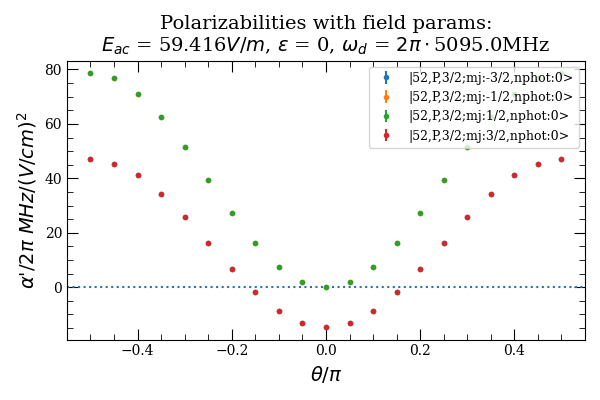

18 |52,P,3/2;mj:-3/2>
19 |52,P,3/2;mj:-1/2>
20 |52,P,3/2;mj:1/2>
21 |52,P,3/2;mj:3/2>


<ipython-input-15-8b3050f25cbe>:4: RuntimeWarning: divide by zero encountered in log10
  x_ac = 20*np.log10(Eacs/scale)


<IPython.core.display.Javascript object>


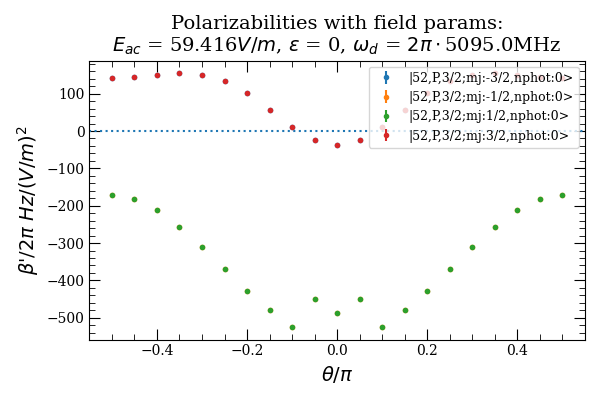

<ipython-input-15-8b3050f25cbe>:45: RuntimeWarning: divide by zero encountered in log10
  x_ac = 20*np.log10(Eacs/scale)


18 |52,P,3/2;mj:-3/2>
19 |52,P,3/2;mj:-1/2>
20 |52,P,3/2;mj:1/2>
21 |52,P,3/2;mj:3/2>


In [15]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
band_c = 0
scale=167
x_ac = 20*np.log10(Eacs/scale)
x_ac = Eacs
for i, state in zip(t_inds,t_states):
    #if state == t_level:  # check n,l,j quantum numbers
    print(i,state.ket())
    k = n_max*len(basis)+i
    band_c +=1
    lab = f"band {band_c}" if energy_bands else basis_n[k].ket()
    if sweep_ac:
        ax.errorbar(x_ac, popts_eac[:,k,1]*1e-2/tau, label=lab,yerr=perrs_eac[:,k,1]*1e-2/tau,fmt=".")
    elif sweep_theta:
        ax.errorbar(thetas/pi, popts_theta2[:,k,1]*1e-3/tau, label=lab,yerr=perrs_theta2[:,k,1]*1e-3/tau,fmt=".")
ax.legend(loc=1,prop={"size":9})
ax.axhline(0,ls=":")
#ax.set_ylim(0,max(np.abs(alphas[0,:]))*1e-3/tau)
#ax.set_yscale("log")
if sweep_ac:
    ax.set_xlabel("AC field strength (V/m)")
    ax.set_title(f"Polarizabilities with field params:\n$\epsilon$ = {ellipticity}, $\omega_d$ = $2\pi \cdot${field_omega*1e-6/tau:.1f}MHz, $\\theta$ = {theta/pi}$\cdot\pi$")
elif sweep_theta:
    ax.set_xlabel("$\\theta/\pi$")
    ax.set_title(f"Polarizabilities with field params:\n$E_{{ac}}$ = {Eac}$V/m$, $\epsilon$ = {ellipticity}, $\omega_d$ = $2\pi \cdot${field_omega*1e-6/tau:.1f}MHz")
    
ax.set_ylabel("$\\alpha$'/$2\pi$ $MHz/(V/cm)^2$")
#ax.set_ylabel("$\\alpha'/\\alpha$ (%)")
for item in [ax.xaxis.label, ax.yaxis.label, ax.title]:
    item.set_fontsize(14)

try:
    for erind in err_eacs:
        ax.axvline(erind,ls=":")
except NameError:
    pass
        
fig.tight_layout()
fig.show()
omega_for_humans = int(field_omega*1e-6/tau)
fig.savefig(f"polarizabilities_omegad-{omega_for_humans}MHz_eps_{ellipticity:.3f}-around{Eacs.mean():.0f}Eac.png")
fig, ax = plt.subplots(1,1, figsize=(6,4))
band_c = 0
scale=167
x_ac = 20*np.log10(Eacs/scale)
x_ac = Eacs
for i, state in zip(t_inds,t_states):
    #if state == t_level:  # check n,l,j quantum numbers
    print(i,state.ket())
    k = n_max*len(basis)+i
    band_c +=1
    lab = f"band {band_c}" if energy_bands else basis_n[k].ket()
    if sweep_ac:
        ax.errorbar(x_ac, popts_eac[:,k,3]/tau, label=lab,yerr=perrs_eac[:,k,3]/tau,fmt=".")
    elif sweep_theta:
        ax.errorbar(thetas/pi, popts_theta[:,k,3]/tau, label=lab,yerr=perrs_theta[:,k,3]/tau,fmt=".")
ax.legend(loc=1,prop={"size":9})
ax.axhline(0,ls=":")
#ax.set_ylim(0,max(np.abs(alphas[0,:]))*1e-3/tau)
#ax.set_yscale("log")
if sweep_ac:
    ax.set_xlabel("AC field strength (V/m)")
    ax.set_title(f"Polarizabilities with field params:\n$\epsilon$ = {ellipticity}, $\omega_d$ = $2\pi \cdot${field_omega*1e-6/tau:.1f}MHz, $\\theta$ = {theta/pi}$\cdot\pi$")
elif sweep_theta:
    ax.set_xlabel("$\\theta/\pi$")
    ax.set_title(f"Polarizabilities with field params:\n$E_{{ac}}$ = {Eac}$V/m$, $\epsilon$ = {ellipticity}, $\omega_d$ = $2\pi \cdot${field_omega*1e-6/tau:.1f}MHz")
    
ax.set_ylabel("$\\alpha$'/$2\pi$ $KHz/(V/m)^2$")
ax.set_ylabel("$\\beta$'/$2\pi$ $Hz/(V/m)^2$")
#ax.set_ylabel("$\\alpha'/\\alpha$ (%)")
for item in [ax.xaxis.label, ax.yaxis.label, ax.title]:
    item.set_fontsize(14)


fig.tight_layout()
fig.show()
omega_for_humans = int(field_omega*1e-6/tau)
#fig.savefig(f"polarizabilities_omegad-{omega_for_humans}MHz_eps_{ellipticity:.3f}-around{Eacs.mean():.0f}Eac.png")

<IPython.core.display.Javascript object>


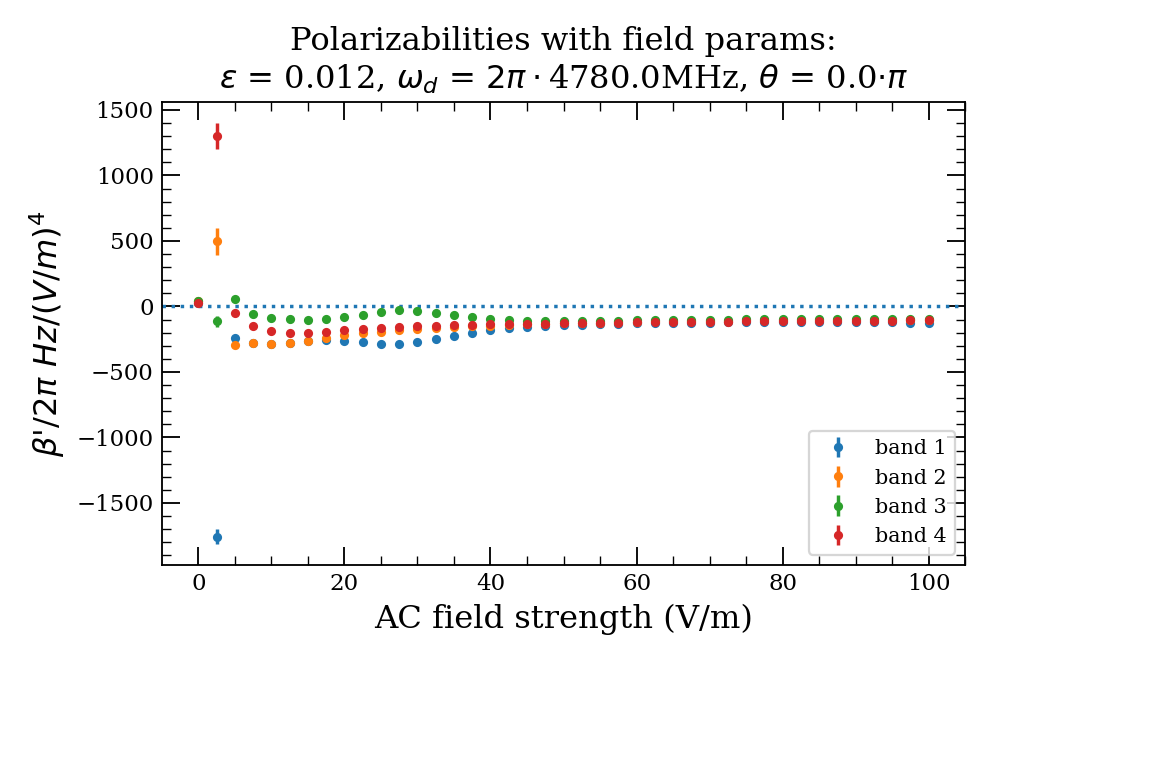

<ipython-input-17-adf5f2240018>:4: RuntimeWarning: divide by zero encountered in log10
  x_ac = 20*np.log10(Eacs/scale)


In [17]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
band_c = 0
scale=167
x_ac = 20*np.log10(Eacs/scale)
x_ac = Eacs
for i, state in enumerate(basis):
    if state == t_level:  # check n,l,j quantum numbers
        band_c +=1
        lab = f"band {band_c}" if energy_bands else basis_n[n_max*len(basis)+i].ket()
        if sweep_ac:
            ax.errorbar(x_ac, popts_eac[:,n_max*len(basis)+i,3]/tau, label=lab,yerr=perrs_eac[:,n_max*len(basis)+i,3]/tau,fmt=".")
        elif sweep_theta:
            ax.errorbar(thetas/pi, popts_theta[:,n_max*len(basis)+i,3]/tau, label=lab,yerr=perrs_theta[:,n_max*len(basis)+i,3]/tau,fmt=".")
ax.legend(loc=4,prop={"size":9})
ax.axhline(0,ls=":")
#ax.set_ylim(0,max(np.abs(alphas[0,:]))*1e-3/tau)
#ax.set_yscale("log")
if sweep_ac:
    ax.set_xlabel("AC field strength (V/m)")
    ax.set_title(f"Polarizabilities with field params:\n$\epsilon$ = {ellipticity}, $\omega_d$ = $2\pi \cdot${field_omega*1e-6/tau:.1f}MHz, $\\theta$ = {theta/pi}$\cdot\pi$")
elif sweep_theta:
    ax.set_xlabel("$\\theta/\pi$")
    ax.set_title(f"Polarizabilities with field params:\n$E_{{ac}}$ = {Eac}$V/m$, $\epsilon$ = {ellipticity}, $\omega_d$ = $2\pi \cdot${field_omega*1e-6/tau:.1f}MHz")
    
ax.set_ylabel("$\\beta$'/$2\pi$ $Hz/(V/m)^4$")
#ax.set_ylabel("$\\alpha'/\\alpha$ (%)")
for item in [ax.xaxis.label, ax.yaxis.label, ax.title]:
    item.set_fontsize(14)
    
fig.tight_layout()
fig.show()
omega_for_humans = int(field_omega*1e-6/tau)
fig.savefig(f"polarizabilities_omegad-{omega_for_humans}MHz_eps_{ellipticity:.3f}-around{Eacs.mean():.0f}Eac.png")

### Plot polarizabilities in mid case

In [5]:
fname = scheme
results_dir = r"Shirley-Floquet_results\PolarizabilityPlots\RawData"
try:
    print(popts_eac[0])
except NameError:
    popts_eac = np.load(os.path.join(results_dir,fname+"popts_eac.npy"))
    perrs_eac = np.load(os.path.join(results_dir,fname+"perrs_eac.npy"))
    Eacs = np.load(os.path.join(results_dir,fname+"eac.npy"))
    es0s_eac = np.load(os.path.join(results_dir,fname+"e0s.npy"))
try:
    print(popts_theta[0])
except NameError:
    popts_theta = np.load(os.path.join(results_dir,fname+"popts_theta.npy"))
    perrs_theta = np.load(os.path.join(results_dir,fname+"perrs_theta.npy"))
    thetas = np.load(os.path.join(results_dir,fname+"thetas.npy"))
    es0s_theta = np.load(os.path.join(results_dir,fname+"e0s_theta.npy"))

try:
    print(popts_theta2[0])
except NameError:
    popts_theta2 = np.load(os.path.join(results_dir,fname+"popts_theta2.npy"))
    perrs_theta2 = np.load(os.path.join(results_dir,fname+"perrs_theta2.npy"))
    thetas = np.load(os.path.join(results_dir,fname+"thetas.npy"))
    es0s_theta2 = np.load(os.path.join(results_dir,fname+"e0s_theta2.npy"))

In [61]:
p_inds = [
    i for i in range(len(basis_n)) if all([
        basis_n[i].n == 52,
        basis_n[i].l == 1,
        basis_n[i].j == 3/2,
        basis_n[i]["mj"] in [1/2],
        basis_n[i]["nphot"] == 0        
    ])
]

thrs=0.1
fig,axar = plt.subplots(2,2,figsize=(4.5*2,3.5*2))
count = 0
zero_x = [27.616, 31.346, 59.416]
cv = ["black","tab:blue","tab:orange"]
alpha0 = popts_eac[0,np.array(p_inds)[0],1]*1e-2/tau

ax_fontsize = 13
tick_labelsize = 11
legend_fontsize = 11
markersize = 3.5
markers = "o*vsD^"
linestyles = ['-',':', '-.', '--']

for i,t in enumerate(p_inds):
    for k in range(len(basis_n))[::-1]:
        if any(np.abs(es0s_eac[:,t,k])**2>thrs):
            color = f"C{count}"
            #color = f"C{i}"
            alphs = np.abs(es0s_eac[:,t,k])**2
            ax=axar[0,0]
            ydat = popts_eac[:,k,1]*1e-2/tau
            yerr = perrs_eac[:,k,1]*1e-2/tau
            ax.set_ylabel("$\\alpha$'/$2\pi$ $kHz/(V/m)^2$")
            for it in range(len(Eacs))[:]:
                kt = basis_n[k]
                ls = {0:"S",1:"P",2:"D",3:"F"}
                lab = f"|{kt.n},{ls[kt.l]},{int(2*kt.j)}/2,{int(2*kt['mj'])}/2;{kt['nphot']}>'"
                lab = "" if (it > 0) else lab
                alph = alphs[it] if (it>0) else 1
                if abs(alphs[it] - alph) > 0.5:
                    xdat = [-5]
                else:
                    xdat = Eacs[it:it+1]
                ax.errorbar(xdat,ydat[it:it+1],yerr=yerr[it:it+1],fmt=markers[count], ms=markersize,c=color,alpha=alph,label=lab)
            #ax.axhline(0,ls=":",c="black")
            #ax.vlines(zero_x,*ax.get_ylim(),linewidth=1,ls=":")
            
            ax=axar[1,0]
            ydat = popts_eac[:,k,3]/tau
            yerr = perrs_eac[:,k,3]/tau
            ax.set_ylabel("$\\beta$'/$2\pi$ $Hz/(V/m)^4$")
            for it in range(len(Eacs))[:]:
                kt = basis_n[k]
                ls = {0:"S",1:"P",2:"D",3:"F"}
                lab = f"|{kt.n},{ls[kt.l]},{int(2*kt.j)}/2,{int(2*kt['mj'])}/2,m={kt['nphot']}>'"
                lab = "" if (it > 0) else lab
                alph = alphs[it] if (it>0) else 1
                if abs(alphs[it] - alph) > 0.5:
                    xdat = [-5]
                else:
                    xdat = Eacs[it:it+1]
                ax.errorbar(xdat,ydat[it:it+1],yerr=yerr[it:it+1],fmt="os"[i], ms=3,c=color,alpha=alph,label=lab)
            lm = ax.get_ylim()
            #ax.vlines(zero_x,*ax.get_ylim(),linewidth=1,ls=":")
            #ax.set_ylim(*lm)
            #ax.axhline(0,ls=":",c="black")            
            count+=1
            
t = p_inds[0]
x_data = thetas/pi*180

y_data = popts_theta[:,t,1]*1e-2/tau
y_err = perrs_theta[:,t,1]*1e-2/tau
axar[0,1].errorbar(x_data,y_data,yerr=y_err, fmt=markers[0],label=f"$E_{{AC}}={zero_x[1]:.1f}V/m$",c=cv[1],ms=markersize)
y_data = popts_theta[:,t,3]/tau
y_err = perrs_theta[:,t,3]/tau
axar[1,1].errorbar(x_data,y_data,yerr=y_err, fmt=markers[0],label=f"$E_{{AC}}={zero_x[1]:.1f}V/m$",c=cv[1],ms=markersize)

y_data = popts_theta2[:,t,1]*1e-2/tau
y_err = perrs_theta2[:,t,1]*1e-2/tau
axar[0,1].errorbar(x_data,y_data,yerr=y_err, fmt=markers[3],label=f"$E_{{AC}}={zero_x[2]:.1f}V/m$",c=cv[2],ms=markersize)
y_data = popts_theta2[:,t,3]/tau
y_err = perrs_theta2[:,t,3]/tau
axar[1,1].errorbar(x_data,y_data,yerr=y_err, fmt=markers[3],label=f"$E_{{AC}}={zero_x[2]:.1f}V/m$",c=cv[2],ms=markersize)
#axar[1,1].set_ylabel("$\\beta$'/$2\pi$ $Hz/(V/m)^4$")

for ax in axar[:,1]:
    ax.axhline(0,c="black",ls=":")
axar[0,1].legend(prop={"size":legend_fontsize})

for ax in axar[:,0]:
    cv = ["black","tab:blue","tab:orange"]
    lm = ax.get_ylim()
    ax.vlines(zero_x,*ax.get_ylim(),linewidth=1.5,ls=linestyles,colors=cv)
    ax.set_ylim(*lm)
    ax.axhline(0,ls=":",c="black")            
    
axar[0,0].set_xlim(0,axar[0,0].get_xlim()[1])
axar[0,0].get_shared_x_axes().join(axar[0,0], axar[1,0])
axar[0,0].set_xticklabels([])
axar[1,0].set_xlim(axar[0,0].get_xlim())
axar[1,0].set_xlabel("$E_{AC}$ $(V/m)$")

#axar[0,1].set_xlim(0,axar[0,0].get_xlim()[1])
axar[0,1].get_shared_x_axes().join(axar[0,1], axar[1,1])
axar[0,1].set_xticklabels([])
axar[1,1].set_xlim(axar[0,1].get_xlim())
axar[1,1].set_xlabel("$\\theta$ (degrees)")
axar[0,0].set_ylabel("$\\alpha'$ ($MHz/(V/cm)^2$)")

#axar[0,0].axhline(alpha0,ls=":")
#axar[0,1].axhline(alpha0*0.2,ls=":")
axar[0,0].set_ylim(-1000,2000)

for ax in axar[0,:]:
    #ax.set_ylabel("$-\\alpha'$ $(KHz/(V/m)^2)$")
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    #ax.axhline(-alpha0*1e-3/tau)
    ax2 = ax.twinx()
    #for k in basis_t:
    #    ax2.plot(x_ac,100*popts_eac[:,n_max*len(basis)+k,1]/alpha0)
    low,high = ax.get_ylim()
    #ax2.set_ylim(-100*low/(alpha0*1e-3/tau),-100*high/(alpha0*1e-3/tau))
    if ax == axar[0,1]:
        #ax.axhline(alpha0*0.2)
        ax2.set_yticks(np.arange(-50,60,10))
        ax2.set_ylim(100*low/(alpha0),100*high/(alpha0))
        ax2.set_ylabel("$\\alpha'/\\alpha_0$ (%)")
    else:
        #ax.axhline(alpha0)
        ax2.set_yticks(np.arange(-200,150,25))
        ax2.set_ylim(100*low/(alpha0),100*high/(alpha0))

    ax.tick_params(labelsize=tick_labelsize)
    ax2.tick_params(labelsize=tick_labelsize)
    for item in [ax.xaxis.label, ax.yaxis.label, ax.title]:
        item.set_fontsize(ax_fontsize)    
    for item in [ax2.xaxis.label, ax2.yaxis.label, ax2.title]:
        item.set_fontsize(ax_fontsize)    
for ax in axar[1,:]:
    ax.tick_params(labelsize=tick_labelsize)
    ax2.tick_params(labelsize=tick_labelsize)
    for item in [ax.xaxis.label, ax.yaxis.label, ax.title]:
        item.set_fontsize(ax_fontsize)    
    for item in [ax2.xaxis.label, ax2.yaxis.label, ax2.title]:
        item.set_fontsize(ax_fontsize)   
axar[1,0].set_ylim(-500,400)
axar[0,0].legend(prop={"size":legend_fontsize})
#axar[1,0].legend(prop={"size":8})
fig.tight_layout()
fig.show()
fig.savefig(os.path.join(plots_dir,"MidDetuning.png"))
fig.savefig(os.path.join(plot_dir,"MidDetuning.eps"))

TypeError: object of type 'NoneType' has no len()

In [8]:
p_inds

[116, 117]

In [54]:
p_inds = [
    i for i in range(len(basis_n)) if all([
        basis_n[i].n == 52,
        basis_n[i].l == 1,
        basis_n[i].j == 3/2,
        basis_n[i]["mj"] in [1/2,3/2],
        basis_n[i]["nphot"] == 0        
    ])
]
print(p_inds)
basis_print([basis_n[i] for i in p_inds])

[116, 117]
[
	|52,P,3/2;mj:1/2,nphot:0>,
	|52,P,3/2;mj:3/2,nphot:0>
]


### find and plot zero-crossings
#### mid case

<IPython.core.display.Javascript object>


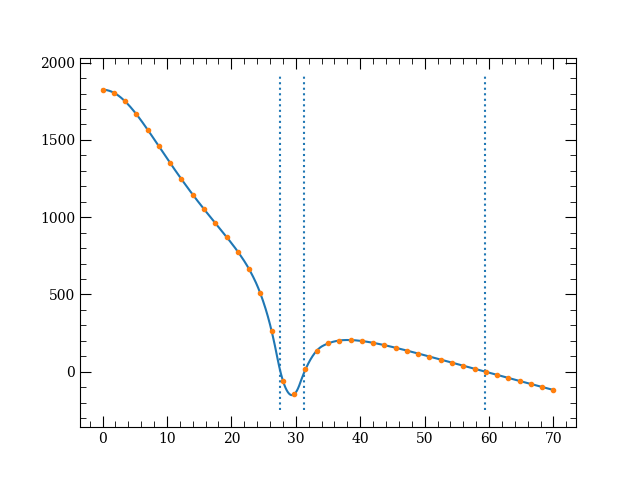

In [45]:
k = t_inds[1]+len(basis)*n_max
fun = interp1d(Eacs,popts_eac[:,k,1]*1e-2/tau,kind="quadratic")
xlin=np.linspace(min(Eacs),max(Eacs),50000)
fig,ax=plt.subplots(1,1)
ax.plot(xlin,fun(xlin))
ax.errorbar(x_ac, popts_eac[:,k,1]*1e-2/tau,yerr=perrs_eac[:,k,1]*1e-2/tau,fmt=".")

zerx = xlin[np.argwhere(np.abs(fun(xlin))<1e-1)][:,0]
zerx[2:].mean()
zero_x = [zerx[0],zerx[1:3].mean(),zerx[3:].mean()]

ax.vlines(zero_x,*ax.get_ylim(),ls = ":")
fig.show()

#zero_x = [27.20,30.55,zerx[2:].mean()]

In [49]:
zero_x

[27.615552311046223, 31.34592691853837, 59.415788315766314]

In [43]:
zero_x = [27.616, 31.346, 59.416]

array([59.40738815, 59.40878818, 59.4101882 , 59.41158823, 59.41298826,
       59.41438829, 59.41578832, 59.41718834, 59.41858837, 59.4199884 ,
       59.42138843, 59.42278846, 59.42418848])

#### simple cases

<IPython.core.display.Javascript object>


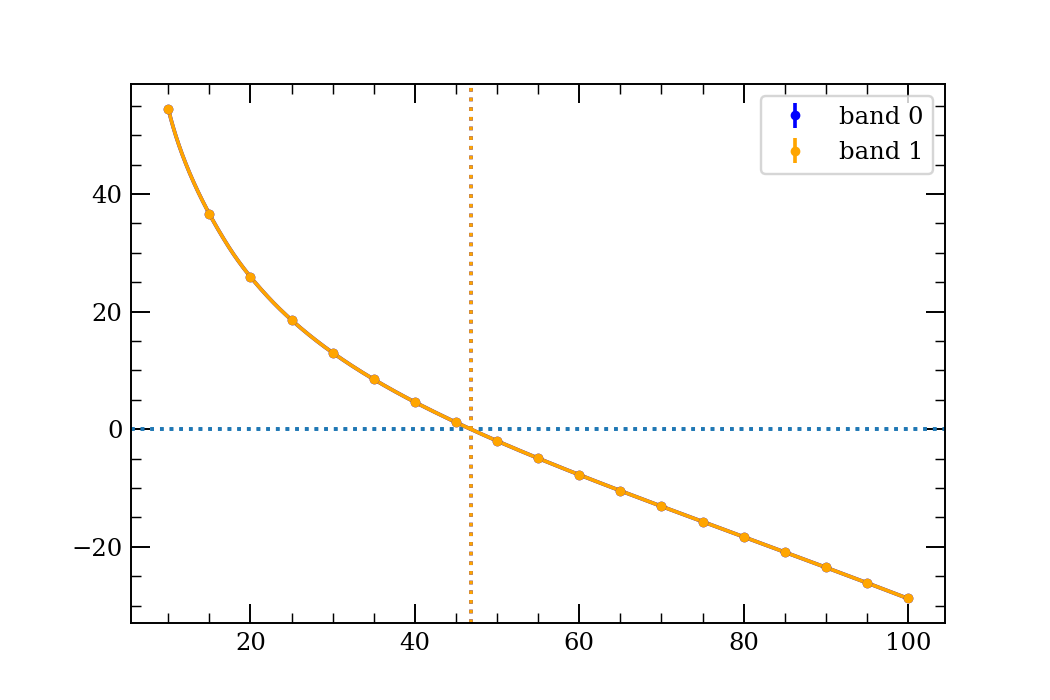

band 0 zero-crossing at Eac = 46.830693717750044 V/m
band 1 zero-crossing at Eac = 46.83090793269037 V/m


<ipython-input-94-8aca5ac183c5>:4: RuntimeWarning: divide by zero encountered in log10
  x_ac = 20*np.log10(Eacs/scale)


In [94]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
band_c = 0
scale=167
x_ac = 20*np.log10(Eacs/scale)
x_ac = Eacs

basis_t = np.array([i+len(basis)*n_max for i, state in enumerate(basis) if [state.n, state.l, state.j] == [t_level.n, t_level.l, t_level.j]])
colors = ["blue","orange","green","red"]
for i,k in enumerate(basis_t):
    x_dat = Eacs[2:]
    y_dat = 1e-3*popts_eac[2:,k,1]/tau
    y_err = 1e-3*perrs_eac[2:,k,1]/tau
    good_inds = np.argwhere(np.invert(np.isnan(y_dat)))[:,0]
    y_dat = y_dat[good_inds]
    y_err = y_err[good_inds]
    x_dat = x_dat[good_inds]
    
#    y_dat[1]=np.NaN
#    y_err[1]=np.NaN
    
    ax.errorbar(x_dat,y_dat,yerr=y_err,fmt=".",c=colors[i],label=f"band {i}")
    ax.axhline(0,ls=":")
    cal_fun = interp1d(y_dat,x_dat,kind="quadratic")
    xlin=np.linspace(min(y_dat),max(y_dat),1000)
    ax.plot(cal_fun(xlin),xlin,colors[i])
    #zerox = np.interp(0,y_dat,x_dat)
    print(f"band {i} zero-crossing at Eac = {cal_fun(0)} V/m")
    ax.axvline(cal_fun(0),ls=":",c=colors[i])
ax.legend()
fig.show()

<IPython.core.display.Javascript object>


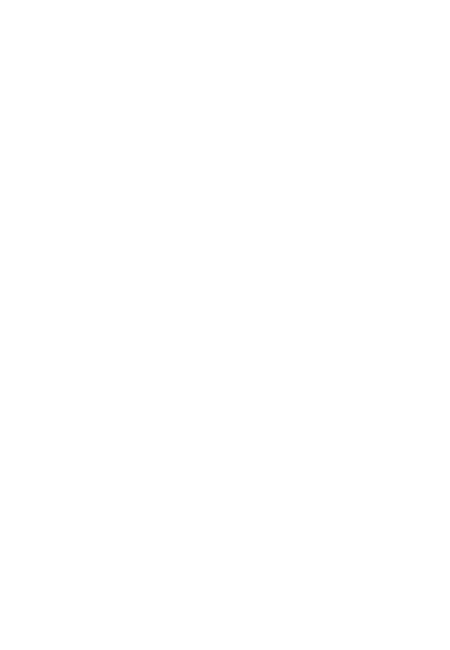

NameError: name 'popts_theta' is not defined

In [47]:
fig, axar = plt.subplots(2,1, figsize=(4.5,6.5))
band_c = 0
scale=167
# convert from SI
si_conv = 1e-2/tau
#x_ac = 20*np.log10(Eacs/scale)
x_ac = Eacs
basis_t = np.array([i+len(basis)*n_max for i, state in enumerate(basis) if [state.n, state.l, state.j] == [t_level.n, t_level.l, t_level.j]])

ax_fontsize = 13
tick_labelsize = 11
legend_fontsize = 10
markersize = 3.5
markers = "o^sD"

alpha0 = popts_eac[0,n_max*len(basis)+basis_t,1].mean()
for i, state in enumerate(basis):
    if scheme != "red" and state["mj"] < 0:
        continue
    if state == t_level:  # check n,l,j quantum numbers
        band_c +=1
        lab = f"band {band_c}" if energy_bands else basis_n[n_max*len(basis)+i].ket()
        #lab=""
        axar[0].errorbar(x_ac, popts_eac[:,n_max*len(basis)+i,1]*si_conv, label=lab,yerr=perrs_eac[:,n_max*len(basis)+i,1]*si_conv,fmt=markers[band_c-1],markersize=markersize)
        axar[1].errorbar(thetas/pi*180, popts_theta[:,n_max*len(basis)+i,1]*si_conv, label=lab,yerr=perrs_theta[:,n_max*len(basis)+i,1]*si_conv,fmt=markers[band_c-1],markersize=markersize)
if scheme == "low":
    pass
else:
    axar[0].legend(loc=1,prop={"size":legend_fontsize})
#axar[1].legend(loc="upper center",prop={"size":legend_fontsize})
axar[0].axhline(0,ls=":")
axar[1].axhline(0,ls=":")
#ax.set_ylim(0,max(np.abs(alphas[0,:]))*1e-3/tau)
#ax.set_yscale("log")
axar[0].set_xlabel("$E_{AC}$ (V/cm)")
axar[1].set_xlabel("$\\theta$ (Degrees)")
axar[1].set_xticks(np.arange(-90,114,45))

y_vals = popts_eac[:,n_max*len(basis)+basis_t,1]*1e-3
axar[0].set_yticks(np.arange(-500,2000,500))
y_vals = popts_theta[:,n_max*len(basis)+basis_t,1]*1e-3
axar[1].set_yticks(np.arange(-0,600,100))
#axar[0].axvline(zerox,ls=":",c="tab:blue")

#axar[0].set_ylim(-50,150)
#axar[1].set_ylim(-5,50)

for ax in axar:
    # ax.set_ylabel("$\\alpha$'/$2\pi$ $KHz/(V/m)^2$")
    ax.set_ylabel("$\\alpha'$ ($MHz/(V/cm)^2$)")
    #ax.set_ylabel("$-\\alpha'$ $(KHz/(V/m)^2)$")
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    #ax.axhline(-alpha0*1e-3/tau)
    ax2 = ax.twinx()
    #for k in basis_t:
    #    ax2.plot(x_ac,100*popts_eac[:,n_max*len(basis)+k,1]/alpha0)
    low,high = ax.get_ylim()
    #ax2.set_ylim(-100*low/(alpha0*1e-3/tau),-100*high/(alpha0*1e-3/tau))
    if ax == axar[0]:
        #ax.axhline(alpha0*si_conv)
        ax2.set_yticks(np.arange(-50,150,50))
        ax2.set_ylim(100*low/(alpha0*si_conv),100*high/(alpha0*si_conv))
    elif ax == axar[1]:
        #ax.axhline(0.3*alpha0*si_conv)
        ax2.set_yticks(np.arange(0,60,10))
        ax2.set_ylim(100*low/(alpha0*si_conv),100*high/(alpha0*si_conv))
    ax2.set_ylabel("$\\alpha'/\\alpha_0$ (%)")
    
    for item in [ax.xaxis.label, ax.yaxis.label, ax.title]:
        item.set_fontsize(ax_fontsize)    
    for item in [ax2.xaxis.label, ax2.yaxis.label, ax2.title]:
        item.set_fontsize(ax_fontsize)
    ax.tick_params(labelsize=tick_labelsize)
    ax.tick_params(labelsize=tick_labelsize)
    
#axar[1].set_yticks(np.arange(0,75,25))
    
fig.tight_layout()
fig.show()
omega_for_humans = int(field_omega*1e-6/tau)
#fig.savefig(os.path.join(plots_dir,f"{scheme}-PolarizabilityAnisotropy_TwoAxes.png"))
#fig.savefig(os.path.join(plots_dir,f"{scheme}-PolarizabilityAnisotropy_TwoAxes.eps"))

#fig.savefig(f"polarizabilities_omegad-{omega_for_humans}MHz_eps_{ellipticity:.3f}-around{Eacs.mean():.0f}Eac.png")

In [101]:
alpha0*si_conv

1281.1304343355134

<IPython.core.display.Javascript object>


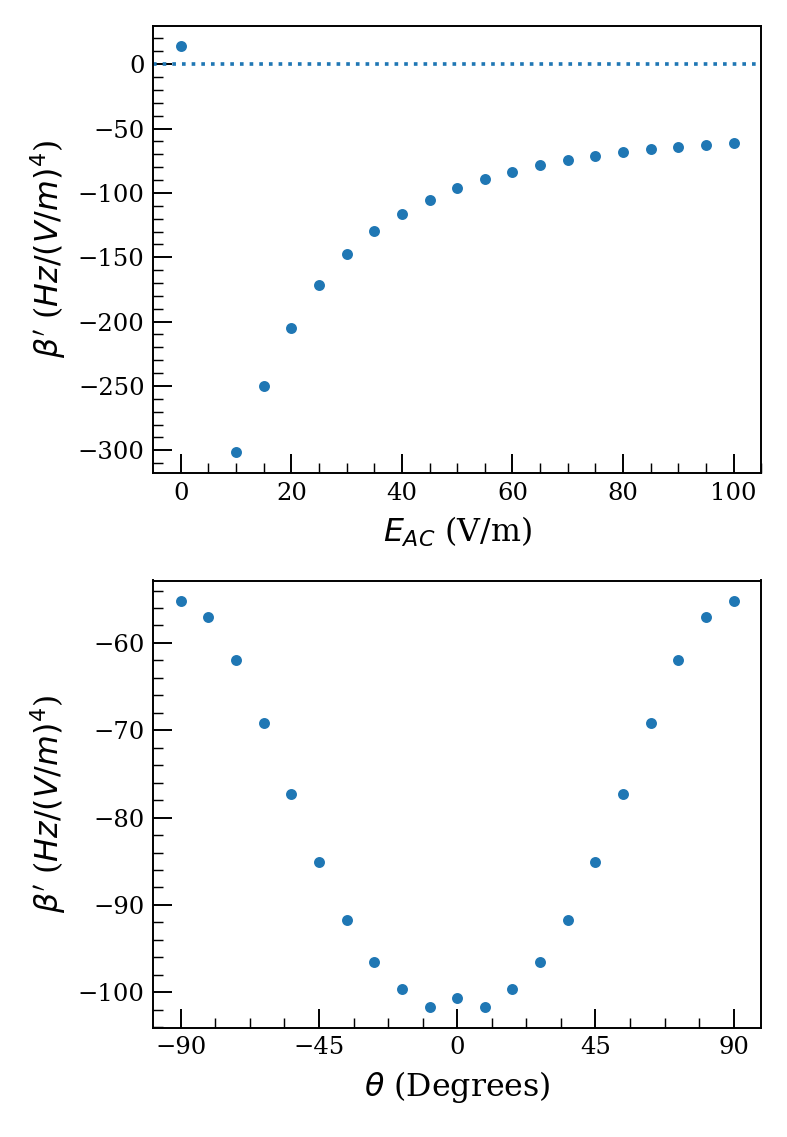

<ipython-input-109-da2fcf1e19b8>:4: RuntimeWarning: divide by zero encountered in log10
  x_ac = 20*np.log10(Eacs/scale)


In [109]:
fig, axar = plt.subplots(2,1, figsize=(4.5,6.5))
band_c = 0
scale=167
x_ac = 20*np.log10(Eacs/scale)
x_ac = Eacs

ax_fontsize = 13
tick_labelsize = 11
legend_fontsize = 10
markersize = 3.5
markers = "o^sD"

basis_t = np.array([i+len(basis)*n_max for i, state in enumerate(basis) if [state.n, state.l, state.j] == [t_level.n, t_level.l, t_level.j]])
alpha0 = popts_eac[0,n_max*len(basis)+basis_t,1].mean()
popts_eac[1,:] = np.NaN
for i, state in enumerate(basis):
    if scheme != "red" and state["mj"] < 0:
        continue
    if state == t_level:  # check n,l,j quantum numbers
        band_c +=1
        lab = f"band {band_c}" if energy_bands else basis_n[n_max*len(basis)+i].ket()
        #lab = ""
        axar[0].errorbar(x_ac, popts_eac[:,n_max*len(basis)+i,3]/tau, label=lab,yerr=perrs_eac[:,n_max*len(basis)+i,3]/tau,fmt=markers[band_c-1],markersize=markersize)
        axar[1].errorbar(thetas/pi*180, popts_theta[:,n_max*len(basis)+i,3]/tau, label=lab,yerr=perrs_theta[:,n_max*len(basis)+i,3]/tau,fmt=markers[band_c-1],markersize=markersize)
if scheme != "low":
        axar[0].legend(loc=4,prop={"size":legend_fontsize})
#axar[1].legend(loc="upper center",prop={"size":legend_fontsize})
axar[0].axhline(0,ls=":")
#axar[1].axhline(0,ls=":")
#ax.set_ylim(0,max(np.abs(alphas[0,:]))*1e-3/tau)
#ax.set_yscale("log")
axar[0].set_xlabel("$E_{AC}$ (V/m)")
axar[1].set_xlabel("$\\theta$ (Degrees)")
axar[1].set_xticks(np.arange(-90,114,45))
#axar[0].set_ylim(-60,210)
#axar[1].set_ylim(-30,100)
#axar[0].axvline(zerox,ls=":",c="tab:blue")


for ax in axar:
    # ax.set_ylabel("$\\alpha$'/$2\pi$ $KHz/(V/m)^2$")
    ax.set_ylabel("$\\beta'$ ($Hz/(V/m)^4$)")
    #ax.set_ylabel("$-\\alpha'$ $(KHz/(V/m)^2)$")
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    low,high = ax.get_ylim()
    for item in [ax.xaxis.label, ax.yaxis.label, ax.title]:
        item.set_fontsize(ax_fontsize)    
        
    
    
    
y_vals = popts_eac[:,n_max*len(basis)+basis_t,1]*1e-3
#axar[0].set_yticks(np.linspace(-50,200,6))
y_vals = popts_theta[:,n_max*len(basis)+basis_t,1]*1e-3
#axar[1].set_yticks(np.linspace(-25,100,6))
#axar[1].set_yticks(np.arange(0,75,25))
    
fig.tight_layout()
fig.show()
omega_for_humans = int(field_omega*1e-6/tau)

fig.savefig(f"Shirley-Floquet_results/{scheme}-HyperPolarizabilityAnisotropy_TwoAxes.png")
fig.savefig(f"Shirley-Floquet_results/{scheme}-HyperPolarizabilityAnisotropy_TwoAxes.eps")

#fig.savefig(f"AvoidedX-PolarizabilityAnisotropy_TwoAxes.png")
#fig.savefig(f"polarizabilities_omegad-{omega_for_humans}MHz_eps_{ellipticity:.3f}-around{Eacs.mean():.0f}Eac.png")

In [ ]:
results_dir = r"Shirley-Floquet_results\PolarizabilityPlots"
#np.save(os.path.join(results_dir,"popts_eac.npy"),popts_eac)
#np.save(os.path.join(results_dir,"perrs_eac.npy"),perrs_eac)
#np.save(os.path.join(results_dir,"popts_theta.npy"),popts_theta)
#np.save(os.path.join(results_dir,"perrs_theta.npy"),perrs_theta)

In [ ]:
Eacs = np.linspace(0,100,21)
thetas = np.linspace(-pi/2,pi/2,21)
popts_eac = np.load(os.path.join(results_dir,"popts_eac.npy"))
perrs_eac = np.load(os.path.join(results_dir,"perrs_eac.npy"))
popts_theta = np.load(os.path.join(results_dir,"popts_theta.npy"))
perrs_theta = np.load(os.path.join(results_dir,"perrs_theta.npy"))

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4.5,4))
band_c = 0
for i, state in enumerate(basis):
    if state == t_level:  # check n,l,j quantum numbers
        band_c +=1
        lab = f"band {band_c}" if energy_bands else basis_n[n_max*len(basis)+i].ket()
        if sweep_ac:
            ax.errorbar(Eacs, popts_eac[:,n_max*len(basis)+i,3]/tau, label=lab,yerr=perrs_eac[:,n_max*len(basis)+i,3]/tau,fmt=".")
        elif sweep_theta:
            ax.errorbar(180*thetas/pi, popts_theta[:,n_max*len(basis)+i,3]/tau, label=lab,yerr=perrs[:,n_max*len(basis)+i,3]/tau,fmt=".")
ax.legend(loc=3,prop={"size":9})
ax.axhline(0,ls=":")
#ax.set_ylim(0,max(np.abs(alphas[0,:]))*1e-3/tau)
#ax.set_yscale("log")
if sweep_ac:
    ax.set_xlabel("AC field strength (V/m)")
   # ax.set_title(f"Polarizabilities with field params:\n$\epsilon$ = {ellipticity}, $\omega_d$ = $2\pi \cdot${field_omega*1e-6/tau:.1f}MHz, $\\theta$ = {theta/pi}$\cdot\pi$")
elif sweep_theta:
    ax.set_xlabel("$\\theta$ (Degrees)")
   # ax.set_title(f"Polarizabilities with field params:\n$E_{{ac}}$ = {Eac}$V/m$, $\epsilon$ = {ellipticity}, $\omega_d$ = $2\pi \cdot${field_omega*1e-6/tau:.1f}MHz")
    
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel("$\\beta$ $(Hz/(V/m)^4)$")
for item in [ax.xaxis.label, ax.yaxis.label, ax.title]:
    item.set_fontsize(12)
    
fig.tight_layout()
fig.show()
omega_for_humans = int(field_omega*1e-6/tau)
fig.savefig(r"Plots/beta_theta")

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
band_c = 0
for i, state in enumerate(basis):
    if state == t_level:  # check n,l,j quantum numbers
        band_c +=1
        lab = t_level.ket()+f"band {band_c}" if energy_bands else basis_n[n_max*len(basis)+i].ket()
        if sweep_ac:
            ax.plot(Eacs, perrs[:,n_max*len(basis)+i,3], label=lab)
        elif sweep_theta:
            ax.errorbar(thetas/pi, 100*popts[:,n_max*len(basis)+i,3]*1e-3/tau, label=lab,yerr=perrs[:,n_max*len(basis)+i,3]*1e-3/tau,fmt=".")
ax.legend(loc=1,prop={"size":9})
ax.axhline(0,ls=":")
#ax.set_ylim(0,max(np.abs(alphas[0,:]))*1e-3/tau)
#ax.set_yscale("log")
if sweep_ac:
    ax.set_xlabel("AC field strength (V/m)")
    ax.set_title(f"Polarizabilities with field params:\n$\epsilon$ = {ellipticity}, $\omega_d$ = $2\pi \cdot${field_omega*1e-6/tau:.1f}MHz, $\\theta$ = {theta/pi}$\cdot\pi$")
elif sweep_theta:
    ax.set_xlabel("$\\theta/\pi$")
    ax.set_title(f"Polarizabilities with field params:\n$E_{{ac}}$ = {Eac}$V/m$, $\epsilon$ = {ellipticity}, $\omega_d$ = $2\pi \cdot${field_omega*1e-6/tau:.1f}MHz")
    
ax.set_ylabel("$\\alpha$'/$2\pi$ $KHz/(V/m)^2$")
ax.set_ylabel("$\\beta (KHz/V^4)$")
ax.set_yscale("log")
for item in [ax.xaxis.label, ax.yaxis.label, ax.title]:
    item.set_fontsize(14)
    
fig.tight_layout()
fig.show()
omega_for_humans = int(field_omega*1e-6/tau)
fig.savefig(f"polarizabilities_omegad-{omega_for_humans}MHz_eps_{ellipticity:.3f}-around{Eacs.mean():.0f}Eac.png")

# Plot_1Ds
## plot all relevant Energies and one overlap

<IPython.core.display.Javascript object>


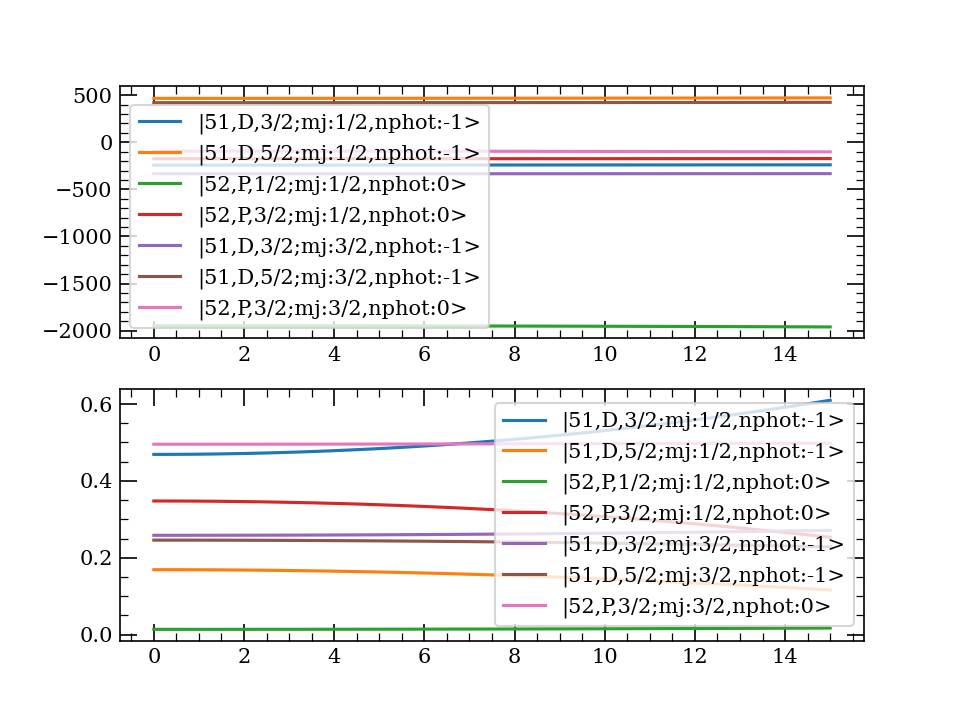

In [8]:
fig,axar = plt.subplots(2,1)
for t in t_inds:
    k = t + n_max*len(basis)
    if basis_n[k]["mj"]<0:
        continue
    label = basis_n[t].ket()

    for j in range(len(basis_n)):
        label = basis_n[j].ket()
        if any(np.abs(eigenstates[k,j,:])**2 > 1e-2):
            ax=axar[0]
            ax.plot(varied[1],1e-6*energies[j,:]/tau,label=label)
            ax=axar[1]        
            ax.plot(varied[1],np.abs(eigenstates[k,j,:])**2,label=label)

#    ax.set_yscale("log")
for ax in axar:
    ax.legend()
fig.show()

<IPython.core.display.Javascript object>


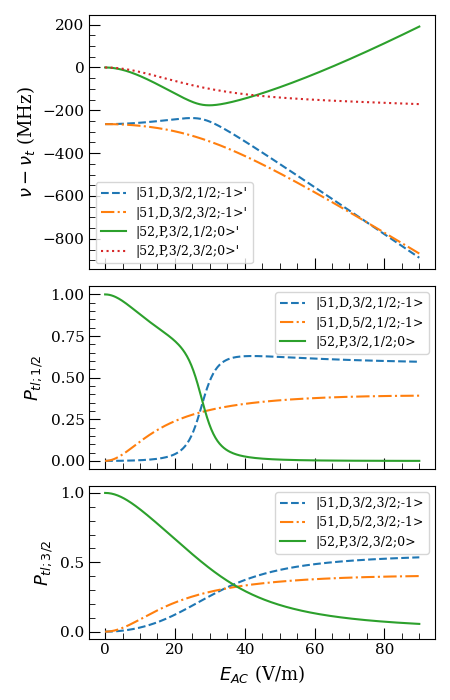

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [8]:
thrs = 0.2# threshold for caring about population
thrs2 = 0.5
fig,axar = plt.subplots(3,1,figsize=(4.5,7),gridspec_kw={'height_ratios': [2.5, 1.8, 1.5]})
iis = []
interesting_inds = []
e_inds = []

ax_fontsize = 13
tick_labelsize = 11
legend_fontsize = 9
markersize = 3.5
markers = "o^sD"
linestyles = ['--', '-.', '-', ':']


for i, state in enumerate(basis):
#    if [state.n,state.l,state.j,state["mj"]] == [t_level.n, t_level.l, t_level.j,3/2]:
    if [state.n,state.l,state.j] == [t_level.n, t_level.l, t_level.j]:
        iis.append(i+len(basis)*n_max)
for ii in iis:
    for k, p in enumerate(eigenstates[:,ii,:]):
        if max(np.absolute(p)**2)>thrs:
            interesting_inds.append(k)
        if max(np.absolute(p)**2)>thrs2:
            e_inds.append(k)
interesting_inds = list(set(interesting_inds))
j,jj,jjj = 0,0,0
for k in interesting_inds:
    kt = basis_n[k]
    ls = {0:"S",1:"P",2:"D",3:"F"}
    lab = f"|{kt.n},{ls[kt.l]},{int(2*kt.j)}/2,{int(2*kt['mj'])}/2;{kt['nphot']}>"
    if basis_n[k]["mj"] < 0:
        continue
    if theta_list is None:
        if basis_n[k]["mj"] is not None:
            if k in e_inds:
                axar[0].plot(varied[1], 1e-6*np.real(energies[k,:]-0*energies[k,0])/tau, ls=linestyles[j],label=lab+"\'")
                j += 1
            y_st = np.absolute(eigenstates[k,ii-1,:])**2
            if any(y_st > thrs):
                axar[1].plot(varied[1], y_st, ls=linestyles[jj],label=lab)
                jj +=1
            y_st = np.absolute(eigenstates[k,ii,:])**2
            if any(y_st > thrs):
                axar[2].plot(varied[1], y_st, ls=linestyles[jjj],label=lab)
                jjj += 1
        else:
            axar[0].plot(varied[1], 1e-6*np.real(energies[k,:]-0*energies[k,0])/tau) #, label=basis_n[k].ket())
            axar[1].plot(varied[1], np.absolute(eigenstates[k,ii-1,:])**2) # , label=basis_n[k].ket())

    else:
        if basis_n[k]["mj"] is not None:
            axar[0].plot(varied[1]/pi, 1e-6*np.real(energies[k,:]-0*energies[k,0])/tau, label=basis_n[k].ket())
            axar[1].plot(varied[1]/pi, np.absolute(eigenstates[k,ii,:])**2, label=basis_n[k].ket())
        else:
            axar[0].plot(varied[1]/pi, 1e-6*np.real(energies[k,:]-0*energies[k,0])/tau) #, label=basis_n[k].ket())
            axar[1].plot(varied[1]/pi, np.absolute(eigenstates[k,ii,:])**2)# , label=basis_n[k].ket())            
    #print(f"state = {basis[k%len(basis)].ket()}, dE = 2pix{1e-6*np.real(Energies[k,-1]-Energies[k,0])/tau}MHz")
#axar[0].set_title("Change in Stark Shifts\n$E_{ac}$ = "+f"{Eac}V/m\n" + "$E_{dc}$ = " + f"{Edc}V/m")
#axar[0].set_ylim(-1.05e3,300)
#axar[1].set_title(f"Overlap with {basis_n[ii-1].ket()}")
#axar[1].set_yscale("log")
axar[1].set_ylabel("$P_{tl;1/2}$")
axar[2].set_ylabel("$P_{tl;3/2}$")
#axar[1].set_ylim(thrs*0.8,1)
if Edc_list is not None:
    axar[0].set_ylabel("DC Stark Shift/$2\pi$ (MHz)")
    axar[0].set_xlabel("DC Electric Field strength (V/m)")
    axar[1].set_xlabel("DC Electric Field strength (V/m)")
elif Eac_list is not None:
    #axar[0].set_title(f"Energy Levels\n$\omega_D = 2\pi\cdot{1e-6*field_omega/tau:.0f}$; $\epsilon$ = {ellipticity}")#"\n $E_{{dc}}$ = {Edc}V/m")
    axar[0].set_ylabel("$\\nu-\\nu_t$ (MHz)")
    #axar[0].set_xlabel("$E_{AC}$ (V/m)")
    axar[2].set_xlabel("$E_{AC}$ (V/m)")
elif theta_list is not None:
    #axar[0].set_ylabel("Change in DC Stark Shift/$2\pi$ (MHz)")
    axar[0].set_xlabel("$\\theta/\pi$ (radians)")
    axar[1].set_xlabel("Angle Between AC and DC fields/$\pi$/ (radians)")
axar[0].legend(loc=3,prop={"size":legend_fontsize})
axar[1].legend(loc=1,prop={"size":legend_fontsize})
axar[2].legend(loc=1,prop={"size":legend_fontsize})

axar[0].get_shared_x_axes().join(axar[0], axar[1])
axar[0].get_shared_x_axes().join(axar[1], axar[2])
axar[0].set_xticklabels([])
axar[1].set_xticklabels([])
axar[2].set_xlim(axar[0].get_xlim())

for ax in axar:
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    ax.tick_params(labelsize=tick_labelsize)
    for item in [ax.xaxis.label, ax.yaxis.label, ax.title]:
        item.set_fontsize(ax_fontsize)
#axar[1].legend()


fig.tight_layout()
#fig.savefig("Shirley-Floquet_results/AvoidedXEac.png")
#fig.savefig("Shirley-Floquet_results/AvoidedXEac.eps")
fig.show()

<IPython.core.display.Javascript object>


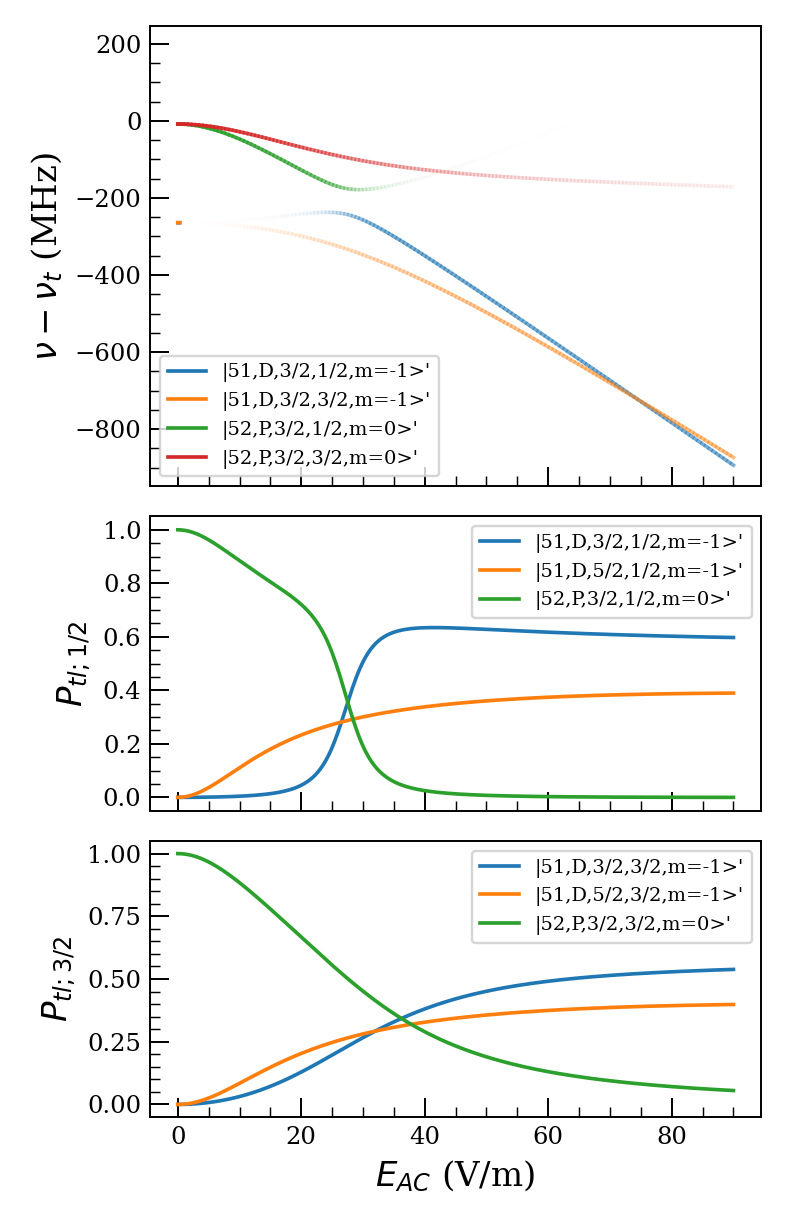

In [121]:
thrs = 0.2# threshold for caring about population
thrs2 = 0.5
fig,axar = plt.subplots(3,1,figsize=(4.5,7),gridspec_kw={'height_ratios': [2.5, 1.6, 1.5]})
iis = []
interesting_inds = []
e_inds = []
for i, state in enumerate(basis):
#    if [state.n,state.l,state.j,state["mj"]] == [t_level.n, t_level.l, t_level.j,3/2]:
    if [state.n,state.l,state.j] == [t_level.n, t_level.l, t_level.j]:
        iis.append(i+len(basis)*n_max)
for ii in iis:
    for k, p in enumerate(eigenstates[:,ii,:]):
        if max(np.absolute(p)**2)>thrs:
            interesting_inds.append(k)
        if max(np.absolute(p)**2)>thrs2:
            e_inds.append(k)
interesting_inds = list(set(interesting_inds))
count=0

for k in interesting_inds:
    kt = basis_n[k]
    ls = {0:"S",1:"P",2:"D",3:"F"}
    lab = f"|{kt.n},{ls[kt.l]},{int(2*kt.j)}/2,{int(2*kt['mj'])}/2,m={kt['nphot']}>'"
    if basis_n[k]["mj"] < 0:
        continue
    if theta_list is None:
        if basis_n[k]["mj"] is not None:
            if k in e_inds:
                color = f"C{count}"
                count+=1
                y_st = np.zeros(energies.shape[1],dtype=float)
                for ii in iis:
                    y_st += np.abs(eigenstates[k,ii,:])**2
                for i in range(len(energies[k,:]))[::2]:
                    if i == 0:
                        axar[0].plot(varied[1][i:i+2], 1e-6*np.real(energies[k,i:i+2]-0*energies[k,0])/tau, label=lab, alpha=y_st[i]*0+1,c=color)
                    else:
                        axar[0].plot(varied[1][i:i+2], 1e-6*np.real(energies[k,i:i+2]-0*energies[k,0])/tau, alpha=y_st[i],c=color)
            y_st = np.absolute(eigenstates[k,ii-1,:])**2
            if any(y_st > thrs):
                axar[1].plot(varied[1], y_st, label=lab)
            y_st = np.absolute(eigenstates[k,ii,:])**2
            if any(y_st > thrs):
                axar[2].plot(varied[1], y_st, label=lab)
        else:
            axar[0].plot(varied[1], 1e-6*np.real(energies[k,:]-0*energies[k,0])/tau) #, label=basis_n[k].ket())
            axar[1].plot(varied[1], np.absolute(eigenstates[k,ii-1,:])**2) # , label=basis_n[k].ket())

    else:
        if basis_n[k]["mj"] is not None:
            axar[0].plot(varied[1]/pi, 1e-6*np.real(energies[k,:]-0*energies[k,0])/tau, label=basis_n[k].ket())
            axar[1].plot(varied[1]/pi, np.absolute(eigenstates[k,ii,:])**2, label=basis_n[k].ket())
        else:
            axar[0].plot(varied[1]/pi, 1e-6*np.real(energies[k,:]-0*energies[k,0])/tau) #, label=basis_n[k].ket())
            axar[1].plot(varied[1]/pi, np.absolute(eigenstates[k,ii,:])**2)# , label=basis_n[k].ket())            
    #print(f"state = {basis[k%len(basis)].ket()}, dE = 2pix{1e-6*np.real(Energies[k,-1]-Energies[k,0])/tau}MHz")
#axar[0].set_title("Change in Stark Shifts\n$E_{ac}$ = "+f"{Eac}V/m\n" + "$E_{dc}$ = " + f"{Edc}V/m")
#axar[0].set_ylim(-1.05e3,300)
#axar[1].set_title(f"Overlap with {basis_n[ii-1].ket()}")
#axar[1].set_yscale("log")
axar[1].set_ylabel("$P_{tl;1/2}$")
axar[2].set_ylabel("$P_{tl;3/2}$")
#axar[1].set_ylim(thrs*0.8,1)
if Edc_list is not None:
    axar[0].set_ylabel("DC Stark Shift/$2\pi$ (MHz)")
    axar[0].set_xlabel("DC Electric Field strength (V/m)")
    axar[1].set_xlabel("DC Electric Field strength (V/m)")
elif Eac_list is not None:
    #axar[0].set_title(f"Energy Levels\n$\omega_D = 2\pi\cdot{1e-6*field_omega/tau:.0f}$; $\epsilon$ = {ellipticity}")#"\n $E_{{dc}}$ = {Edc}V/m")
    axar[0].set_ylabel("$\\nu-\\nu_t$ (MHz)")
    #axar[0].set_xlabel("$E_{AC}$ (V/m)")
    axar[2].set_xlabel("$E_{AC}$ (V/m)")
elif theta_list is not None:
    #axar[0].set_ylabel("Change in DC Stark Shift/$2\pi$ (MHz)")
    axar[0].set_xlabel("$\\theta/\pi$ (radians)")
    axar[1].set_xlabel("Angle Between AC and DC fields/$\pi$/ (radians)")
axar[0].legend(loc=3,prop={"size":8})
axar[1].legend(loc=1,prop={"size":8})
axar[2].legend(loc=1,prop={"size":8})

axar[0].get_shared_x_axes().join(axar[0], axar[1])
axar[0].get_shared_x_axes().join(axar[1], axar[2])
axar[0].set_xticklabels([])
axar[1].set_xticklabels([])
axar[2].set_xlim(axar[0].get_xlim())
for ax in axar:
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    for item in [ax.xaxis.label, ax.yaxis.label, ax.title]:
        item.set_fontsize(14)
#axar[1].legend()
fig.tight_layout()
#fig.savefig("Plots/AvoidedXEac.png")
fig.show()

In [ ]:
thrs = 0.11 # threshold for caring about population
fig,axar = plt.subplots(1,2,figsize=(10,5))
iis = []
interesting_inds = []
for i, state in enumerate(basis):
#    if [state.n,state.l,state.j,state["mj"]] == [t_level.n, t_level.l, t_level.j,3/2]:
    if [state.n,state.l,state.j] == [t_level.n, t_level.l, t_level.j]:
        iis.append(i+len(basis)*n_max)
for ii in iis:
    for k, p in enumerate(eigenstates[:,ii,:]):
        if max(np.absolute(p)**2)>thrs:
            interesting_inds.append(k)
interesting_inds = list(set(interesting_inds))
band_c = 0
for k in interesting_inds:
    band_c +=1
#    lab = t_level.ket()+f"band {band_c}" if energy_bands else basis_n[k].ket()
    lab = basis_n[k].ket()
    if theta_list is None:
        axar[0].plot(varied[1], 1e-6*np.real(energies[k,:]-0*energies[k,0])/tau, label=lab)
        axar[1].plot(varied[1], np.absolute(eigenstates[k,ii-1,:])**2, label=lab)
    else:
        axar[0].plot(varied[1]/pi, 1e-6*np.real(energies[k,:]-0*energies[k,0])/tau, label=basis_n[k].ket())
        axar[1].plot(varied[1]/pi, np.absolute(eigenstates[k,ii,:])**2, label=basis_n[k].ket())
    #print(f"state = {basis[k%len(basis)].ket()}, dE = 2pix{1e-6*np.real(Energies[k,-1]-Energies[k,0])/tau}MHz")
axar[0].set_title("Change in Stark Shifts\n$E_{ac}$ = "+f"{Eac}V/m\n" + "$E_{dc}$ = " + f"{Edc}V/m")
axar[0].set_title(f"DC field response\n$E_{{ac}}$ = {Eac}V/m, $\epsilon$ = {ellipticity:.3f}, $\\theta$ = {theta/pi}$\pi$")
#axar[0].set_ylim(-40,2)
axar[1].set_title(f"Overlap with {basis_n[ii-1].ket()}")
axar[1].set_yscale("log")
axar[1].set_ylim(thrs*0.8,1)
axar[0].legend(loc=3,prop={"size":14})
if Edc_list is not None:
    axar[0].set_ylabel("DC Stark Shift/$2\pi$ (MHz)")
    axar[0].set_xlabel("DC Electric Field strength (V/m)")
    axar[1].set_xlabel("DC Electric Field strength (V/m)")
elif Eac_list is not None:
    axar[0].set_title("Change in Stark Shifts\n$\epsilon$ = "+f"{ellipticity}\n" + "$E_{dc}$ = " + f"{Edc}V/m")
    axar[0].set_ylabel("AC Stark Shift/$2\pi$ (MHz)")
    axar[0].set_xlabel("AC Electric Field strength (V/m)")
    axar[1].set_xlabel("AC Electric Field strength (V/m)")
elif theta_list is not None:
    axar[0].set_ylabel("Change in DC Stark Shift/$2\pi$ (MHz)")
    axar[0].set_xlabel("$\\theta/\pi$ (radians)")
    axar[1].set_xlabel("Angle Between AC and DC fields/$\pi$/ (radians)")
#axar[1].legend()
for txt in [axar[0].xaxis.label,axar[0].yaxis.label,axar[0].title]:
    txt.set_fontsize(14)
fig.tight_layout()
fig.show()

## Fit to quadratic shifts, compare to alphas

In [ ]:
quad = lambda v, alpha, e0: -1/2*alpha*(v-0)**2+e0
four_pol = lambda v, alpha, beta, e0: -1/2*alpha*(v-0)**2+e0+beta*(v-0)**4
interesting_inds = list(set(interesting_inds))
 
func = four_pol
dim = len(basis_n)
#alphas = np.zeros(dim, dtype=float)
#dalphas = np.zeros(dim, dtype=float)
print("\n".join(basis_n[k].ket() for k in interesting_inds))
for k in iis:
    band_energies = energies[k,:]
#    guess = guess = [(band_energies[-1]-band_energies[0])/varied[1][-1]**2, band_energies[0]]
    guess = guess = [-2*(band_energies[-1]-band_energies[0])/varied[1][-1]**2, 0, band_energies[0]]
    try:
        popt, pcov = curve_fit(func, varied[1], band_energies, p0 = guess)
        perr = np.sqrt(np.diag(pcov))
    except RuntimeError:
        popt = [np.NaN]*len(guess)
        perr = popt
    print(f"state {basis_n[k].ket()} has polarizability fits:\n\t {popt}\n\t {perr}")
    
    fig,axar = plt.subplots(1,2,figsize=(10,4))
    ax=axar[0]
    ax.plot(varied[1],(band_energies - band_energies[0])*1e-6/tau, label = "Band energy")
    ax.plot(varied[1], (func(varied[1],*popt)-band_energies[0])*1e-6/tau, ls="-.", label = "Quadratic fit to band energy")
    ax.plot(varied[1], func(varied[1],guess[0],0,0*band_energies[0])*1e-6/tau, ls=":", label="Manual Guess")
    #ax.plot(varied[1], (quad(varied[1],popt[0], alphas[k], popt[2])-band_energies[0])*1e-6/tau, ls = ":", label = "fit from alphas")
    ax.legend()
    ax.set_xlabel(varied[0])
    ax.set_ylabel("DC Stark Shift/$2\pi$ (MHz)")
    ax.set_title(
        f"Quadratic fit on state {basis_n[k].ket()}\n$\\alpha$' = 2$\pi \cdot$ {popt[0]*1e-3/tau:.2f} $\pm$ {perr[0]*1e-3/tau:.2f} $KHz/(V/m)^2$\n$\\beta$' = 2$\pi \cdot$ {popt[1]/tau:.2e} $\pm$ {perr[1]/tau:.3e} $Hz/(V/m)^4$")# \n$\\alpha$'2 = 2$\pi \cdot$ {alphas[k]*1e-3/tau:.2f} $\pm$ {dalphas[k]*1e-3/tau:.2f} $KHz/(V/m)^2$")
    ax=axar[1]
    ax.plot(varied[1], (band_energies-func(varied[1],*popt))/tau, label = "Fit Residuals")
    ax.plot(varied[1], (band_energies-quad(varied[1],guess[0],guess[2]))/tau, ls=":", label="Guess residuals")
    ax.legend()
    ax.set_xlabel(varied[0])
    ax.set_ylabel("Fit Residuals (Hz)")
    fig.tight_layout()
    fig.show()

## Plot Energies for each relevant m_j

In [ ]:
thrs = 2e-1  # threshold for caring about population
look_at = t_level
#look_at = RydStateFS(51,2,5/2)
for i, state in enumerate(basis):
    if state == look_at:
        interesting_inds = []
        #print(state.ket())
        ii = i+len(basis)*n_max
        #print(ii)
        for k, p in enumerate(eigenstates[:,ii,:]):
            #check 
            #print(k)
            if max(np.absolute(p)**2)>thrs:
                interesting_inds.append(k)
                #print(f"index {k} is interesting")
                #print(f"corresponds to {basis_n[k].ket()}")
                #print(f"{p}")
                #print(max(p))
            #print(k,p.shape,p[1:].max())
        fig,axar = plt.subplots(1,2,figsize=(8,6))
        for k in interesting_inds:
            axar[0].plot(varied[1], 1e-6*np.real(energies[k,:])/tau, label=basis_n[k].ket())
            axar[1].plot(varied[1], np.absolute(eigenstates[k,ii,:])**2, label=basis_n[k].ket())
        axar[0].set_title("Energies")
        #axar[0].set_ylim(-1e3,6e3)
        axar[1].axhline(0.5,ls=":")
        axar[1].set_title("Probability")
        axar[1].set_yscale("log")
        axar[1].set_ylim(thrs*0.8,1)
        axar[0].legend()
        axar[0].set_ylabel("Rydberg State Energy/$2\pi$ (MHz)")
        if Edc_list is not None:
            axar[0].set_xlabel("DC Electric Field strength (V/m)")
            axar[1].set_xlabel("DC Electric Field strength (V/m)")
        elif Eac_list is not None:
            axar[0].set_xlabel("AC Electric Field strength (V/m)")
            axar[1].set_xlabel("AC Electric Field strength (V/m)")
        #axar[1].legend()
        fig.suptitle(f"State = {state.ket()}")
        fig.tight_layout()
        fig.show()

## Plot Relative Shifts for each relevant m_j

In [ ]:
thrs = 5e-2  # threshold for caring about population
look_at = t_level
#look_at = RydStateFS(51,2,5/2)
for i, state in enumerate(basis):
    if state == look_at:
        interesting_inds = []
        #print(state.ket())
        ii = i+len(basis)*n_max
        #print(ii)
        for k, p in enumerate(eigenstates[:,ii,:]):
            #check 
            #print(k)
            if max(np.absolute(p)**2)>thrs:
                interesting_inds.append(k)
                #print(f"index {k} is interesting")
                #print(f"corresponds to {basis_n[k].ket()}")
                #print(f"{p}")
                #print(max(p))
            #print(k,p.shape,p[1:].max())
        fig,axar = plt.subplots(1,2,figsize=(8,6))
        for k in interesting_inds:
            axar[0].plot(varied[1], 1e-6*np.real(energies[k,:]-energies[k,0])/tau, label=basis_n[k].ket())
            axar[1].plot(varied[1], np.absolute(eigenstates[k,ii,:])**2, label=basis_n[k].ket())
        axar[0].set_title("Energies")
        #axar[0].set_ylim(-1e3,6e3)
        axar[1].set_title("Probability")
        axar[1].set_yscale("log")
        axar[1].set_ylim(thrs*0.8,1)
        axar[0].legend()
        axar[0].set_ylabel("State DC Stark Shift/$2\pi$ (MHz)")
        if Edc_list is not None:
            axar[0].set_xlabel("DC Electric Field strength (V/m)")
            axar[1].set_xlabel("DC Electric Field strength (V/m)")
        elif Eac_list is not None:
            axar[0].set_xlabel("AC Electric Field strength (V/m)")
            axar[1].set_xlabel("AC Electric Field strength (V/m)")
        #axar[1].legend()
        fig.suptitle(f"State = {state.ket()}")
        fig.tight_layout()
        fig.show()

In [ ]:
thrs = 5e-2  # threshold for caring about population
look_at = t_level
#look_at = RydStateFS(51,2,5/2)
for i, state in enumerate(basis):
    if state == look_at:
        interesting_inds = []
        #print(state.ket())
        ii = i+len(basis)*n_max
        #print(ii)
        for k, p in enumerate(eigenstates[:,ii,:]):
            #check 
            #print(k)
            if max(np.absolute(p)**2)>thrs:
                interesting_inds.append(k)
                #print(f"index {k} is interesting")
                #print(f"corresponds to {basis_n[k].ket()}")
                #print(f"{p}")
                #print(max(p))
            #print(k,p.shape,p[1:].max())
        fig,axar = plt.subplots(1,2,figsize=(8,6))
        for k in interesting_inds:
            axar[0].plot(varied[1], 1e-6*np.real(energies[k,:]-energies[k,0])/tau, label=basis_n[k].ket())
            axar[1].plot(varied[1], np.absolute(eigenstates[k,ii,:])**2, label=basis_n[k].ket())
        axar[0].set_title("Energies")
        #axar[0].set_ylim(-1e3,6e3)
        axar[1].set_title("Probability")
        axar[1].set_yscale("log")
        axar[1].set_ylim(thrs*0.8,1)
        axar[0].legend()
        axar[0].set_ylabel("State DC Stark Shift/$2\pi$ (MHz)")
        if Edc_list is not None:
            axar[0].set_xlabel("DC Electric Field strength (V/m)")
            axar[1].set_xlabel("DC Electric Field strength (V/m)")
        elif Eac_list is not None:
            axar[0].set_xlabel("AC Electric Field strength (V/m)")
            axar[1].set_xlabel("AC Electric Field strength (V/m)")
        #axar[1].legend()
        fig.suptitle(f"State = {state.ket()}")
        fig.tight_layout()
        fig.show()

# Analytical comparison (NOT COMPLETE)

In [ ]:
# Mixing Parameters : TODO
pt = 0.7
pm = 0.3
th = np.arccos(np.sqrt(pt))
s2th = np.sin(2*th)**2
# Effective tensor polarizabilities : TODO
alpha2_t = 9
alpha2_m = -7
# Quantum numbers
j = t_level.j
mjs = np.arange(-j,j+1,1)


In [ ]:
def anisotropy_coefficient(mj):
    t1 = -3/4*(3*mj**2-j*(j+1))/j/(2*j-1)
    t2 = -3/4*(3*mj**2-(j+2)*(j+1))/(j+1)/(2*j+1)
    t3 = ((1+j)**2-0.5*(3+2*j)*mj-mj**2)/((j+1)*(2*j+1)*(2*j+3))
    
    return pt*alpha2_t*t1+pm*alpha2_m*t2+0.5*s2th*d10*t3/(omegam-omegap)

# Debugging

In [ ]:
Ht = np.diag([1,1,1,1,2,2,2,2,2])
print(Ht)
e, ev = np.linalg.eig(H0)
print((e-laser_dAC)*1e-6/tau)
print(np.diag(ev)-1)

In [ ]:
Eac = Eac_list[1]
Edc = 0
ellipticity = 0.012
theta = 0
HF = build_floquet(
    basis,
    H0,
    Eac,
    ellipticity,
    field_omega,
    Edc,
    theta,
    n_max
)
(HF-np.diag(np.diag(HF))).sum()

In [ ]:
e,ev =np.linalg.eig(HF)
print((ev-np.diag(np.diag(ev))).sum())

In [ ]:
np.dot(Ht,[1,1,0,0])

# Debugging

In [ ]:
fields
H_floquet = build_floquet(basis,H0,Eac,0.02,field_omega,Edc_list[-1],pi/2,n_max)
H_floquet = H_floquet
fig,ax = plt.subplots(1,1)
ax.imshow(np.real(H_floquet[(n_max-1)*len(basis):(n_max+1)*len(basis),(n_max-1)*len(basis):(n_max+1)*len(basis)]))
fig.show()

In [ ]:
fields
eigenvalues, eigenvectors = floquet_diag(basis, H0, n_max = n_max, **fields)

In [ ]:
energies = np.zeros((len(basis)*(2*n_max+1),2), dtype=complex)
eigenstates = np.zeros((len(basis)*(2*n_max+1), len(basis)*(2*n_max+1), 2), dtype=complex)
starts = level_starts(levels)
ips_summer = level_projector(basis, levels, n_max)

# compute overlaps wrt unperturbed eigenstates
ips = np.abs(eigenvectors)**2
# sum over all zeeman states in each level
ips_levels = np.dot(ips, ips_summer)
# sum over all level in each fourier sub basis
used_inds = []
troublesome_level = RydStateFS(51,2,5/2)
for j, level in enumerate(levels):
    for k, n in enumerate(range(-n_max, n_max+1)):
        print(f"finding good eigenvectors for |level, n> = |{level.ket()},{n}>")
        # eigenvectors that have >50% population in this level
        thrsh = 0.5
        inds_l = np.argwhere(ips_levels[:, j+k*len(levels)] > thrsh)
        # if the 50% threshold is too high to accommodate all m levels, lower the
        # threshold incrementally
        while len(inds_l) < 2*level.j+1:
            thrsh *= 0.95
            print(f"expansion required, threshold reduced to {thrsh}")
            inds_l = np.argwhere(ips_levels[:, j + k * len(levels)] > thrsh)

        # find the band that has the greatest overlap with each mj level
        print(f"inds_l = {inds_l[:,0]}")
        strt = starts[j]+k*len(basis)
        for a in range(int(2*level.j + 1)):
            # print(f"m = {-level.j + a}")
            # print(f"sub_ips = {ips[inds_l, strt + a]}")
            ev_ind = np.argmax(ips[inds_l, strt + a])
            if inds_l[ev_ind, 0] in used_inds:
                print(f"WARNING: index {inds_l[ev_ind, 0]} has been used")
            print(f"inds used = {inds_l[ev_ind,0]}")
            used_inds.append(inds_l[ev_ind, 0])
            # print(f"new inds = {inds_l[ev_ind,0]}")
            # print(f"New energy = {eigenvalues[inds_l[ev_ind, 0]]}")
            eigenstates[strt + a, :, 0] = eigenvectors[inds_l[ev_ind, 0], :]
            energies[strt + a, 0] = np.real(eigenvalues[inds_l[ev_ind, 0]])


In [ ]:
n = -2
k = n+n_max
j = 2
strt = starts[j]+k*len(basis)
end = starts[j+1]+k*len(basis)
ind_l = [32, 33, 34, 35]
for ind in ind_l:
    print(f"overlaps in range {basis_n[strt].ket()}-{basis_n[end-1].ket()} for ind = {ind}")
    print(f"\t{ips[ind,strt:end]}")

In [ ]:
basis[j].ket()

In [ ]:
strt

In [ ]:
ips_levels[32,j+k*len(levels)]

In [ ]:
thrs = 1e-2
print([f"{ev*(ev > thrs):.2e}" for ev in ips[32]])

In [ ]:
basis_print(levels)

# Convergence

In [ ]:
class ConvTest:
    def __init__(self, n_max, dw, dl, energies=None, eigenstates=None):
        self.n_max=n_max
        self.max_det = dw
        self.dl = dl
        self.energies = energies
        self.eigenstates = eigenstates
    def __repr__(self):
        return f"ConvTest({self.n_max},{self.max_det},{self.dl})"
    def __str__(self):
        return self.__repr__()

In [ ]:
filepath = "Shirley-Floquet_results\\convergence_tests"

ConvTests = [None]*(len(os.listdir(filepath))//2)
for i, file in enumerate(os.listdir(filepath)):
    test_str = "eigenstates.npy"
    nrg = "energies.npy"
    print(file)
    if file[-len(test_str):] == test_str:
        print(file)
        settings = file.split("-")[1:4]
        for setting in settings:
            exec(setting)
        ConvTests[i//2] = ConvTest(nmax,dw,dl)
        ConvTests[i//2].energies = np.load(os.path.join(filepath,file[:-len(test_str)]+nrg))
        # ConvTests[i//2].eigenstates = np.load(os.path.join(filepath,file))

In [ ]:
ConvTests

In [ ]:
for test in ConvTests:
    levels, basis = build_basis(t_level,test.max_det,single_side=False, dl=test.dl)
    target_inds = [i for i, state in enumerate(basis) if [state.n,state.l,state.j] == [t_level.n,t_level.l,t_level.j]]
    dim = len(basis)
    t_level_nrgs = {basis[k].ket(): test.energies[test.n_max*dim + k] for k in target_inds}
    #t_level_estates = {basis[k].ket(): test.eigenstates[test.n_max*dim + k] for k in target_inds}
    test.sub_nrgs = t_level_nrgs
    #test.sub_estates = t_level_estates

In [ ]:
ConvTests[0].desc = "$\Delta l = 2$, $m_{max} = 2$"#", $\omega_{max} = 2\pi\\times30GHz$"
ConvTests[1].desc = "$\Delta l = 1$, $m_{max} = 3$, $\omega_{max} = 2\pi\\times30GHz$"
ConvTests[2].desc = "$\Delta l = 2$, $m_{max} = 3$"#", $\omega_{max} = 2\pi\\times30GHz$"
ConvTests[3].desc = "$\Delta l = 1$, $m_{max} = 3$, $\omega_{max} = 2\pi\\times60GHz$"
ConvTests[4].desc = "$\Delta l = 1$, $m_{max} = 4$, $\omega_{max} = 2\pi\\times30GHz$"

In [ ]:
ConvTests[0].desc = "$\Delta l = 2$, $m_{max} = 2$"#", $\omega_{max} = 2\pi\\times30GHz$"
ConvTests[1].desc = "Baseline"
ConvTests[2].desc = "$\Delta l = 2$, $m_{max} = 3$"#", $\omega_{max} = 2\pi\\times30GHz$"
ConvTests[3].desc = "$\omega_{max} = 2\pi\\times60GHz$"
ConvTests[4].desc = "$m_{max} = 4$"

In [ ]:
ms = int(2*t_level.j+1)
#fig,axar = plt.subplots(ms,2,figsize=(8,ms*3))
#names = ["$\Delta l = 2, m_{max}-1$", "Baseline", "$\Delta l = 2$", "$2\\times \omega_{max}$", "$m_{max} + 1$"]
sub_list = ConvTests[1:]+[ConvTests[0]]
for m in range(ms):
    fig,axar = plt.subplots(2,1,figsize=(4,4.5),gridspec_kw={'height_ratios': [3, 2]})#,sharex=True)
    ax = axar[1]
    for t,test in enumerate(sub_list):
        m_key = list(test.sub_nrgs.keys())[m]
        ax.plot(varied[1],(test.sub_nrgs[m_key]-ConvTests[1].sub_nrgs[m_key])*1e-6/tau,label=test.desc)
    #ax.set_title(m_key)
    ax.set_ylabel("Correction (MHz)")
    ax.set_xlabel("$E_{DC}$ (V/m)")
    #ax.legend(loc="center right",prop={"size":9})
#ax.set_ylim(-1,1)
    
    ax = axar[0]
    for t,test in enumerate(sub_list):
        m_key = list(test.sub_nrgs.keys())[m]
        ax.plot(varied[1],(test.sub_nrgs[m_key]-test.sub_nrgs[m_key][0])*1e-6/tau,label=test.desc)
    #ax.set_title(m_key)
    ax.set_ylabel("$\Delta_{DC}$ (MHz)")
    #ax.set_xlabel("$E_{DC}$ (V/m)")
    ax.legend(loc=3,prop={"size":9})

    axar[0].get_shared_x_axes().join(axar[0], axar[1])
    axar[0].set_xticklabels([])
    axar[1].set_xlim(axar[0].get_xlim())

    for ax in axar:
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        for txt in [ax.xaxis.label, ax.yaxis.label, ax.title]:
            txt.set_fontsize("10")
    
    fig.tight_layout()
    fig.show()

In [ ]:
ms = int(2*t_level.j+1)
#fig,axar = plt.subplots(ms,2,figsize=(8,ms*3))
#names = ["$\Delta l = 2, m_{max}-1$", "Baseline", "$\Delta l = 2$", "$2\\times \omega_{max}$", "$m_{max} + 1$"]
sub_list = ConvTests[1:]+[ConvTests[0]]

sub_lists = [ConvTests[1:]+[ConvTests[0]],[ConvTests[0],ConvTests[2]]]
labs="abcd"
for m in range(ms):
    fig,axar = plt.subplots(2,2,figsize=(7,4.5),gridspec_kw={'height_ratios': [3, 2]})#,sharex=True)
    for i,sub_list in enumerate(sub_lists):
        ax = axar[1,i]
        for t,test in enumerate(sub_list):
            m_key = list(test.sub_nrgs.keys())[m]
            ax.plot(varied[1],(test.sub_nrgs[m_key]-sub_list[0].sub_nrgs[m_key])*1e-6/tau,label=test.desc)
        #ax.set_title(m_key)
        ax.set_ylabel("Correction (MHz)")
        ax.set_xlabel("$E_{DC}$ (V/m)")
        #ax.legend(loc="center right",prop={"size":9})
    #ax.set_ylim(-1,1)

        ax = axar[0,i]
        for t,test in enumerate(sub_list):
            m_key = list(test.sub_nrgs.keys())[m]
            ax.plot(varied[1],(test.sub_nrgs[m_key]-test.sub_nrgs[m_key][0])*1e-6/tau,label=test.desc)
        #ax.set_title(m_key)
        ax.set_ylabel("$\Delta_{DC}$ (MHz)")
        #ax.set_xlabel("$E_{DC}$ (V/m)")
        ax.legend(loc=3,prop={"size":9})

        axar[0,i].get_shared_x_axes().join(axar[0,i], axar[1,i])
        axar[0,i].set_xticklabels([])
        axar[1,i].set_xlim(axar[0,i].get_xlim())
        #axar[0,i].text(0,3, labs[2*i])
        #axar[1,i].text(-2,0, labs[2*i+1])
        
        for axs in axar:
            for ax in axs:
                ax.yaxis.set_ticks_position('left')
                ax.xaxis.set_ticks_position('bottom')
                for txt in [ax.xaxis.label, ax.yaxis.label, ax.title]:
                    txt.set_fontsize("11")

    fig.tight_layout()
    fig.savefig(f"plots/Convergence_DCStark{m}n.png")
    fig.show()

In [ ]:
axar[1,1].text(5,5,"Test")
fig.show()

In [ ]:
func = lambda x, alpha, beta: -1/2*alpha*x**2+beta*x**4
popts = np.zeros((len(ConvTests),len(t_inds),2),dtype=float)
perrs = np.zeros(popts.shape,dtype=float)

ConvTests=ConvTests[1:]+[ConvTests[0]]
for j,m in enumerate(range(ms)):
    for i,test in enumerate(ConvTests):
        m_key = list(test.sub_nrgs.keys())[m]
        x_dat = varied[1]
        y_dat = test.sub_nrgs[m_key]-test.sub_nrgs[m_key][0]
        guess = [-2*y_dat[-1]/x_dat[-1]**2,0]
        popts[i,j], pcov = curve_fit(func,x_dat,y_dat,p0=guess)
        perrs[i,j] = np.sqrt(np.diag(pcov))

In [ ]:
fig,axar=plt.subplots(2,1,figsize=(6,4))
w=1/(ms+1)
for m in range(ms):
    ax=axar[0]
    locs = np.arange(len(ConvTests)-1)+(m-ms/2+1/2)*w
    ax.bar(locs,(popts[1:,m,0]-popts[0,m,0])*1e-3/tau,width=w,label=f"band {m}")
    ax.set_ylabel("$\Delta\\alpha'$ ($kHz/(V/m)^2$)")
    ax.legend()
    
    ax=axar[1]
    ax.bar(locs,(popts[1:,m,1]-popts[0,m,1])/tau,width=w)
    ax.set_ylabel("$\Delta\\beta'$ ($Hz/(V/m)^4$)")
    #ax.tick_params(axis='x', labelrotation = 90)
    axar[0].get_shared_x_axes().join(axar[0], axar[1])
    axar[0].set_xticklabels([])
    axar[1].set_xlim(axar[0].get_xlim())
    axar[1].set_xticks(np.arange(len(ConvTests)-1),minor=False)
    axar[1].set_xticklabels([test.desc for test in ConvTests[1:]])
    axar[1].set_xlim(-w*3,max(locs)+w)
    for ax in axar:
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.minorticks_off()
        
        for txt in [ax.xaxis.label, ax.yaxis.label, ax.title]:
            txt.set_fontsize("10")
    [test.desc for test in ConvTests]
fig.tight_layout()
fig.savefig("Plots/ConvergencePolarizabilitiesn.png")
fig.show()